In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df_train_est_A = pd.read_csv('train_est_B.csv')
df_train_obs_A = pd.read_csv('train_obs_B.csv')
df_test_A = pd.read_csv('X_test_B.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [6]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [7]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [23]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Sample DataFrame (replace this with your own dataset)
data = X_selected

# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [24]:
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-0),
        'n_estimators': trial.suggest_int('n_estimators',10,1000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_int('random_state', 1,1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
            # Create an XGBoost DMatrix for training and testing data
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train the XGBoost model
        model = xgb.train(param, dtrain)

        # Make predictions on the test data
        y_pred = model.predict(dtest)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [25]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize')

[I 2023-10-25 14:58:49,539] A new study created in memory with name: no-name-f4b6e1db-8bb7-4bfb-a9d3-b59e2c239d74


In [26]:
study.optimize(objective, n_trials=500)

[I 2023-10-25 14:58:50,413] Trial 0 finished with value: 53.063754183715474 and parameters: {'lambda': 0.0030880950168794734, 'alpha': 0.05681670991764318, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6289383477196305, 'n_estimators': 887, 'max_depth': 5, 'random_state': 53, 'min_child_weight': 294}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 63.62265997060744
Mean Absolute Error: 64.68354049362665
Mean Absolute Error: 30.885062086912352


[I 2023-10-25 14:58:50,671] Trial 1 finished with value: 133.90627334931006 and parameters: {'lambda': 8.058792444691612, 'alpha': 0.06464719355670283, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0002463364130430397, 'n_estimators': 36, 'max_depth': 7, 'random_state': 379, 'min_child_weight': 73}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 134.92388897097774
Mean Absolute Error: 146.45876605556884
Mean Absolute Error: 120.33616502138356
Mean Absolute Error: 134.99207978941405
Mean Absolute Error: 146.49928846265178


[I 2023-10-25 14:58:50,951] Trial 2 finished with value: 133.96058395852103 and parameters: {'lambda': 0.3312819669442674, 'alpha': 0.011966535114554824, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.00019021152161690223, 'n_estimators': 313, 'max_depth': 9, 'random_state': 948, 'min_child_weight': 120}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 120.39038362349726
Mean Absolute Error: 65.78476726148868
Mean Absolute Error: 63.847310024751415


[I 2023-10-25 14:58:51,185] Trial 3 finished with value: 53.79903113395762 and parameters: {'lambda': 0.10105686316723728, 'alpha': 1.5776478474856013, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.6009336862959808, 'n_estimators': 541, 'max_depth': 11, 'random_state': 461, 'min_child_weight': 202}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 31.76501611563275
Mean Absolute Error: 81.71739203532393
Mean Absolute Error: 92.58537267104903


[I 2023-10-25 14:58:51,477] Trial 4 finished with value: 79.90399033398354 and parameters: {'lambda': 0.004086177250944791, 'alpha': 0.3683944425819761, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.08237229436362523, 'n_estimators': 142, 'max_depth': 15, 'random_state': 608, 'min_child_weight': 102}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 65.40920629557769
Mean Absolute Error: 65.11366631867114
Mean Absolute Error: 70.96542734632304


[I 2023-10-25 14:58:51,737] Trial 5 finished with value: 57.99328088204643 and parameters: {'lambda': 0.011001063231643763, 'alpha': 2.0830586375747906, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.18654722901227946, 'n_estimators': 120, 'max_depth': 13, 'random_state': 377, 'min_child_weight': 215}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 37.90074898114511
Mean Absolute Error: 128.92517524025152
Mean Absolute Error: 141.3952703968179


[I 2023-10-25 14:58:51,960] Trial 6 finished with value: 128.62737158826 and parameters: {'lambda': 1.2752127052034072, 'alpha': 0.004582330212373525, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.005142646879744389, 'n_estimators': 17, 'max_depth': 17, 'random_state': 540, 'min_child_weight': 288}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 115.56166912771057
Mean Absolute Error: 81.59551886550518
Mean Absolute Error: 94.77423747774309


[I 2023-10-25 14:58:52,259] Trial 7 finished with value: 80.98145592860403 and parameters: {'lambda': 1.216804758748616, 'alpha': 7.548151005041129, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.07778365385159243, 'n_estimators': 500, 'max_depth': 11, 'random_state': 700, 'min_child_weight': 98}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 66.57461144256382
Mean Absolute Error: 63.950427053117735
Mean Absolute Error: 65.39933404376745


[I 2023-10-25 14:58:52,504] Trial 8 finished with value: 53.81544454389289 and parameters: {'lambda': 0.5661568812735485, 'alpha': 1.4105471424314557, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.5731070476598457, 'n_estimators': 371, 'max_depth': 5, 'random_state': 494, 'min_child_weight': 64}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 32.09657253479348
Mean Absolute Error: 60.983905621664405
Mean Absolute Error: 70.53915181174492


[I 2023-10-25 14:58:52,898] Trial 9 finished with value: 56.26324370953779 and parameters: {'lambda': 8.46920823814001, 'alpha': 2.1975120695033517, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.22842948432152535, 'n_estimators': 622, 'max_depth': 15, 'random_state': 204, 'min_child_weight': 42}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 37.26667369520406
Mean Absolute Error: 117.11513210153075
Mean Absolute Error: 130.69396303376882


[I 2023-10-25 14:58:53,143] Trial 10 finished with value: 117.71171011408597 and parameters: {'lambda': 0.0015026723863756403, 'alpha': 0.0011980986118294101, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.01651501601727304, 'n_estimators': 942, 'max_depth': 5, 'random_state': 3, 'min_child_weight': 294}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 105.32603520695834
Mean Absolute Error: 68.83505705680783
Mean Absolute Error: 70.89282966026681


[I 2023-10-25 14:58:53,417] Trial 11 finished with value: 58.30873044583004 and parameters: {'lambda': 0.031763416132768105, 'alpha': 0.09433414405385952, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.8322131716058825, 'n_estimators': 874, 'max_depth': 11, 'random_state': 69, 'min_child_weight': 200}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 35.198304620415485
Mean Absolute Error: 69.56014655410786
Mean Absolute Error: 62.94878310241851


[I 2023-10-25 14:58:53,647] Trial 12 finished with value: 53.942208491941194 and parameters: {'lambda': 0.05556089288407841, 'alpha': 0.4222997727293186, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.6668486539323246, 'n_estimators': 748, 'max_depth': 5, 'random_state': 835, 'min_child_weight': 230}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 29.317695819297224
Mean Absolute Error: 67.82808116824542
Mean Absolute Error: 69.62521002959312


[I 2023-10-25 14:58:53,941] Trial 13 finished with value: 59.49058058366908 and parameters: {'lambda': 0.022180887522124087, 'alpha': 0.043810456348340875, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.9385511143460418, 'n_estimators': 721, 'max_depth': 11, 'random_state': 207, 'min_child_weight': 168}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 41.0184505531687
Mean Absolute Error: 107.08890848936805
Mean Absolute Error: 120.64395441982839


[I 2023-10-25 14:58:54,245] Trial 14 finished with value: 107.74794676040419 and parameters: {'lambda': 0.1027939732541835, 'alpha': 0.29112844178636044, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.02954665537524569, 'n_estimators': 576, 'max_depth': 9, 'random_state': 203, 'min_child_weight': 254}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 95.51097737201607
Mean Absolute Error: 62.97541946050617


[I 2023-10-25 14:58:54,587] Trial 15 finished with value: 56.39328449871601 and parameters: {'lambda': 0.001365853471514466, 'alpha': 0.021960597439379257, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.22391328109068684, 'n_estimators': 843, 'max_depth': 7, 'random_state': 364, 'min_child_weight': 3}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 70.29200861690657
Mean Absolute Error: 35.912425418735275
Mean Absolute Error: 126.99979785124286
Mean Absolute Error: 140.5790507065598


[I 2023-10-25 14:58:54,905] Trial 16 finished with value: 127.34753622948706 and parameters: {'lambda': 0.007604401429729274, 'alpha': 0.17295618601666252, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.006394401975123179, 'n_estimators': 415, 'max_depth': 17, 'random_state': 742, 'min_child_weight': 175}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 114.46376013065853
Mean Absolute Error: 96.85731093295524
Mean Absolute Error: 108.30021763649307


[I 2023-10-25 14:58:55,166] Trial 17 finished with value: 95.84878202088915 and parameters: {'lambda': 0.14610201293189415, 'alpha': 0.6007886180568422, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.04814793236968698, 'n_estimators': 722, 'max_depth': 13, 'random_state': 141, 'min_child_weight': 262}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 82.38881749321911
Mean Absolute Error: 62.43875654389226
Mean Absolute Error: 66.3539710828033


[I 2023-10-25 14:58:55,418] Trial 18 finished with value: 53.21415354462551 and parameters: {'lambda': 0.02003870866527975, 'alpha': 0.15373654920354263, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3215740889834342, 'n_estimators': 279, 'max_depth': 5, 'random_state': 337, 'min_child_weight': 142}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 30.84973300718098
Mean Absolute Error: 62.269814398726886
Mean Absolute Error: 69.7024462647276


[I 2023-10-25 14:58:55,672] Trial 19 finished with value: 55.981196964933424 and parameters: {'lambda': 0.0032604559308257583, 'alpha': 0.1348769174849357, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.21523216857203648, 'n_estimators': 270, 'max_depth': 5, 'random_state': 274, 'min_child_weight': 138}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 35.9713302313458
Mean Absolute Error: 116.5451297719591
Mean Absolute Error: 131.8198069274999


[I 2023-10-25 14:58:55,931] Trial 20 finished with value: 117.91207191099032 and parameters: {'lambda': 0.014583217676897249, 'alpha': 0.057436504379391046, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.016290039229857674, 'n_estimators': 226, 'max_depth': 5, 'random_state': 81, 'min_child_weight': 151}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 105.37127903351195
Mean Absolute Error: 63.364901396814034
Mean Absolute Error: 66.62848991532663


[I 2023-10-25 14:58:56,214] Trial 21 finished with value: 53.5173862766153 and parameters: {'lambda': 0.029670095373370328, 'alpha': 0.1479290475662991, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.44008344819379713, 'n_estimators': 466, 'max_depth': 11, 'random_state': 462, 'min_child_weight': 198}. Best is trial 0 with value: 53.063754183715474.


Mean Absolute Error: 30.55876751770522
Mean Absolute Error: 62.422509847197205
Mean Absolute Error: 62.99462770231603


[I 2023-10-25 14:58:56,441] Trial 22 finished with value: 50.867223910232816 and parameters: {'lambda': 0.035852870853427955, 'alpha': 0.16659851894229194, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3270282047670017, 'n_estimators': 419, 'max_depth': 5, 'random_state': 315, 'min_child_weight': 249}. Best is trial 22 with value: 50.867223910232816.


Mean Absolute Error: 27.184534181185217
Mean Absolute Error: 77.39925589700256
Mean Absolute Error: 85.74627086103739


[I 2023-10-25 14:58:56,670] Trial 23 finished with value: 73.29331198340141 and parameters: {'lambda': 0.0068154484846627335, 'alpha': 0.035584186242137335, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.11807542185299563, 'n_estimators': 372, 'max_depth': 5, 'random_state': 283, 'min_child_weight': 252}. Best is trial 22 with value: 50.867223910232816.


Mean Absolute Error: 56.73440919216426
Mean Absolute Error: 62.59005049688781
Mean Absolute Error: 64.87220125520089


[I 2023-10-25 14:58:56,910] Trial 24 finished with value: 51.808089141320245 and parameters: {'lambda': 0.015342156837625394, 'alpha': 0.19689031096970505, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.41652457501148227, 'n_estimators': 191, 'max_depth': 5, 'random_state': 266, 'min_child_weight': 300}. Best is trial 22 with value: 50.867223910232816.


Mean Absolute Error: 27.96201567187205
Mean Absolute Error: 62.28820212209955
Mean Absolute Error: 63.53205896398499


[I 2023-10-25 14:58:57,149] Trial 25 finished with value: 50.59524542992219 and parameters: {'lambda': 0.002644086727220505, 'alpha': 0.08080125319764783, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.37697205940555306, 'n_estimators': 169, 'max_depth': 5, 'random_state': 111, 'min_child_weight': 276}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 25.965475203682022
Mean Absolute Error: 72.61388341801246
Mean Absolute Error: 80.46619108499962


[I 2023-10-25 14:58:57,386] Trial 26 finished with value: 68.13062131225395 and parameters: {'lambda': 0.009681118551407467, 'alpha': 0.02359931567817021, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.12144709029107235, 'n_estimators': 194, 'max_depth': 5, 'random_state': 156, 'min_child_weight': 265}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 51.311789433749766
Mean Absolute Error: 62.34876743474057
Mean Absolute Error: 64.47844731800157


[I 2023-10-25 14:58:57,643] Trial 27 finished with value: 52.13840692536681 and parameters: {'lambda': 0.05585195892818336, 'alpha': 0.26702160495192356, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3348244677782088, 'n_estimators': 151, 'max_depth': 5, 'random_state': 283, 'min_child_weight': 237}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 29.588006023358282
Mean Absolute Error: 68.2352899549018
Mean Absolute Error: 67.51449979772494


[I 2023-10-25 14:58:57,880] Trial 28 finished with value: 57.45453445599216 and parameters: {'lambda': 0.0055846398820954225, 'alpha': 0.6707635587111476, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.9633451068796326, 'n_estimators': 81, 'max_depth': 5, 'random_state': 144, 'min_child_weight': 272}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 36.613813615349756
Mean Absolute Error: 63.45046858774181
Mean Absolute Error: 63.52803746311024


[I 2023-10-25 14:58:58,121] Trial 29 finished with value: 51.27663444206112 and parameters: {'lambda': 0.0023401953137168418, 'alpha': 0.06882100337842566, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.31304297368158085, 'n_estimators': 207, 'max_depth': 5, 'random_state': 7, 'min_child_weight': 294}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 26.85139727533133
Mean Absolute Error: 70.64192409429434
Mean Absolute Error: 77.07700463093934


[I 2023-10-25 14:58:58,377] Trial 30 finished with value: 64.70250361982015 and parameters: {'lambda': 0.001966503946096224, 'alpha': 0.08826331894345116, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1380154560752292, 'n_estimators': 341, 'max_depth': 7, 'random_state': 13, 'min_child_weight': 281}. Best is trial 25 with value: 50.59524542992219.


Mean Absolute Error: 46.38858213422675
Mean Absolute Error: 63.08806068247411
Mean Absolute Error: 61.688769765951186


[I 2023-10-25 14:58:58,610] Trial 31 finished with value: 50.443059004622285 and parameters: {'lambda': 0.0027443628104996645, 'alpha': 0.0962627986604231, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.36756377602770923, 'n_estimators': 218, 'max_depth': 5, 'random_state': 86, 'min_child_weight': 299}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 26.55234656544154
Mean Absolute Error: 62.10678004501014
Mean Absolute Error: 65.19749036331207


[I 2023-10-25 14:58:58,849] Trial 32 finished with value: 52.15054755949347 and parameters: {'lambda': 0.0010416348812090804, 'alpha': 0.08347627880915258, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3336470403120683, 'n_estimators': 242, 'max_depth': 5, 'random_state': 98, 'min_child_weight': 238}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 29.14737227015819
Mean Absolute Error: 86.05673961051706
Mean Absolute Error: 98.51820158312084


[I 2023-10-25 14:58:59,119] Trial 33 finished with value: 84.86686148053973 and parameters: {'lambda': 0.0029761395807936125, 'alpha': 0.06103331038613575, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0723301560313613, 'n_estimators': 96, 'max_depth': 9, 'random_state': 1, 'min_child_weight': 279}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 70.0256432479813
Mean Absolute Error: 63.84323071580525
Mean Absolute Error: 63.07256483464886


[I 2023-10-25 14:58:59,361] Trial 34 finished with value: 51.01233975859672 and parameters: {'lambda': 0.0021275727264277156, 'alpha': 0.0934295171839794, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.48239600297213325, 'n_estimators': 444, 'max_depth': 5, 'random_state': 90, 'min_child_weight': 299}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 26.12122372533605
Mean Absolute Error: 65.83913197117054
Mean Absolute Error: 65.63318956307555


[I 2023-10-25 14:58:59,633] Trial 35 finished with value: 54.75921623502574 and parameters: {'lambda': 0.004793899820092244, 'alpha': 0.032149129990532245, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.5646509456556356, 'n_estimators': 472, 'max_depth': 15, 'random_state': 113, 'min_child_weight': 272}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 32.80532717083113
Mean Absolute Error: 65.98225751269854
Mean Absolute Error: 71.8672437380734


[I 2023-10-25 14:58:59,929] Trial 36 finished with value: 58.85051199040627 and parameters: {'lambda': 0.002103874286364794, 'alpha': 0.125592162198889, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.17938345935842478, 'n_estimators': 415, 'max_depth': 13, 'random_state': 209, 'min_child_weight': 218}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 38.70203472044688
Mean Absolute Error: 67.87978493340225


[I 2023-10-25 14:59:00,281] Trial 37 finished with value: 59.65206098816207 and parameters: {'lambda': 0.004028910583690628, 'alpha': 0.01311188244510525, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.9905158557065363, 'n_estimators': 295, 'max_depth': 17, 'random_state': 70, 'min_child_weight': 258}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 70.76529794032152
Mean Absolute Error: 40.311100090762444


[I 2023-10-25 14:59:00,518] Trial 38 finished with value: 51.23859108820841 and parameters: {'lambda': 0.001095208007393954, 'alpha': 0.09088658034919245, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.44796214469686524, 'n_estimators': 567, 'max_depth': 5, 'random_state': 328, 'min_child_weight': 300}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 62.99603976812103
Mean Absolute Error: 63.48077980627853
Mean Absolute Error: 27.238953690225657


[I 2023-10-25 14:59:00,797] Trial 39 finished with value: 70.15562731762937 and parameters: {'lambda': 0.010209939442035024, 'alpha': 0.23959585095984012, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.11045806467105221, 'n_estimators': 631, 'max_depth': 9, 'random_state': 434, 'min_child_weight': 243}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 74.0782517981027
Mean Absolute Error: 82.80301255744261
Mean Absolute Error: 53.58561759734279


[I 2023-10-25 14:59:01,042] Trial 40 finished with value: 58.21989205163382 and parameters: {'lambda': 0.0048175363952890566, 'alpha': 0.050946228508944987, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.17762719492268597, 'n_estimators': 45, 'max_depth': 5, 'random_state': 410, 'min_child_weight': 222}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 65.32148024622089
Mean Absolute Error: 71.37944209900571
Mean Absolute Error: 37.95875380967484
Mean Absolute Error: 63.33480610095428
Mean Absolute Error: 58.8308003541236


[I 2023-10-25 14:59:01,909] Trial 41 finished with value: 50.519151173846815 and parameters: {'lambda': 0.0010561709245017251, 'alpha': 0.09348476246389599, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.49996041206296776, 'n_estimators': 553, 'max_depth': 5, 'random_state': 603, 'min_child_weight': 300}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 29.391847066462567
Mean Absolute Error: 64.0231353522494


[I 2023-10-25 14:59:04,168] Trial 42 finished with value: 52.121556870041054 and parameters: {'lambda': 0.0018456085338591707, 'alpha': 0.11006240387922574, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5656383652103065, 'n_estimators': 436, 'max_depth': 5, 'random_state': 565, 'min_child_weight': 283}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 64.62338625492515
Mean Absolute Error: 27.71814900294862
Mean Absolute Error: 64.93698275404891


[I 2023-10-25 14:59:05,109] Trial 43 finished with value: 54.707390315337555 and parameters: {'lambda': 0.0032862187584737986, 'alpha': 0.1953048292989502, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.27661337531862923, 'n_estimators': 508, 'max_depth': 5, 'random_state': 619, 'min_child_weight': 283}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 67.6432758743675
Mean Absolute Error: 31.54191231759626
Mean Absolute Error: 64.96936886936024
Mean Absolute Error: 65.57166665087132


[I 2023-10-25 14:59:06,040] Trial 44 finished with value: 53.55332079915419 and parameters: {'lambda': 0.0011435728988976582, 'alpha': 0.06224657946558402, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5345561042327542, 'n_estimators': 619, 'max_depth': 15, 'random_state': 668, 'min_child_weight': 268}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 30.118926877231022
Mean Absolute Error: 66.20354530941248
Mean Absolute Error: 66.69345349350854


[I 2023-10-25 14:59:06,283] Trial 45 finished with value: 55.3154513178611 and parameters: {'lambda': 0.002646420021684938, 'alpha': 0.4266103753742518, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.6917942502861408, 'n_estimators': 349, 'max_depth': 5, 'random_state': 167, 'min_child_weight': 250}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 33.04935515066228
Mean Absolute Error: 63.1304007932484
Mean Absolute Error: 67.02514492071963


[I 2023-10-25 14:59:06,539] Trial 46 finished with value: 54.04084783754916 and parameters: {'lambda': 0.001757471744157773, 'alpha': 0.04026430323941387, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.23886407745525248, 'n_estimators': 153, 'max_depth': 7, 'random_state': 783, 'min_child_weight': 288}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 31.966997798679436
Mean Absolute Error: 87.07889199201728
Mean Absolute Error: 96.80876942324356


[I 2023-10-25 14:59:06,817] Trial 47 finished with value: 84.51636556196269 and parameters: {'lambda': 0.006959369294461493, 'alpha': 0.11763365530651351, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.06976147803904198, 'n_estimators': 526, 'max_depth': 13, 'random_state': 227, 'min_child_weight': 297}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 69.66143527062725
Mean Absolute Error: 67.8037128521426
Mean Absolute Error: 75.5635839185156


[I 2023-10-25 14:59:07,104] Trial 48 finished with value: 62.002939423646815 and parameters: {'lambda': 0.001472224240369364, 'alpha': 0.2980548217952683, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1597252180357569, 'n_estimators': 661, 'max_depth': 17, 'random_state': 535, 'min_child_weight': 274}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 42.64152150028226
Mean Absolute Error: 65.44775637096411
Mean Absolute Error: 66.0155065133821


[I 2023-10-25 14:59:07,347] Trial 49 finished with value: 54.72550763839492 and parameters: {'lambda': 0.0039036545658978706, 'alpha': 0.07927240592848368, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.6780379724598978, 'n_estimators': 388, 'max_depth': 5, 'random_state': 930, 'min_child_weight': 103}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 32.713260030838526
Mean Absolute Error: 63.78937598584762
Mean Absolute Error: 64.24225070467094


[I 2023-10-25 14:59:07,587] Trial 50 finished with value: 52.10361283489852 and parameters: {'lambda': 0.0025828034233588595, 'alpha': 0.026954141715625494, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.4028270133786454, 'n_estimators': 322, 'max_depth': 5, 'random_state': 637, 'min_child_weight': 204}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 28.279211814177014
Mean Absolute Error: 64.5123507773509
Mean Absolute Error: 63.48611290808074


[I 2023-10-25 14:59:07,831] Trial 51 finished with value: 52.55892829603798 and parameters: {'lambda': 0.0011051059914297635, 'alpha': 0.11372462957598155, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.47959076120907607, 'n_estimators': 552, 'max_depth': 5, 'random_state': 318, 'min_child_weight': 292}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 29.67832120268231
Mean Absolute Error: 64.47869964681377
Mean Absolute Error: 65.75913975664184


[I 2023-10-25 14:59:08,074] Trial 52 finished with value: 53.700313854855004 and parameters: {'lambda': 0.0014542480208565812, 'alpha': 0.08532562932170308, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.22878849295449816, 'n_estimators': 589, 'max_depth': 5, 'random_state': 55, 'min_child_weight': 300}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 30.863102161109403
Mean Absolute Error: 65.52655515673028
Mean Absolute Error: 67.8053279520925


[I 2023-10-25 14:59:08,314] Trial 53 finished with value: 55.188679170977714 and parameters: {'lambda': 0.0019046571289465717, 'alpha': 0.050077678788779105, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7535276674974479, 'n_estimators': 686, 'max_depth': 5, 'random_state': 494, 'min_child_weight': 262}. Best is trial 31 with value: 50.443059004622285.


Mean Absolute Error: 32.23415440411038
Mean Absolute Error: 63.22807746831859
Mean Absolute Error: 61.947990446802955


[I 2023-10-25 14:59:08,559] Trial 54 finished with value: 50.35635728223246 and parameters: {'lambda': 0.0010147056068139809, 'alpha': 0.18141467890857363, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.4041983602135832, 'n_estimators': 479, 'max_depth': 5, 'random_state': 386, 'min_child_weight': 282}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 25.89300393157583
Mean Absolute Error: 62.19494070084577
Mean Absolute Error: 65.92540914127616


[I 2023-10-25 14:59:08,863] Trial 55 finished with value: 53.29910268987454 and parameters: {'lambda': 0.002822164056649886, 'alpha': 0.15597188454057215, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2630175729912338, 'n_estimators': 492, 'max_depth': 11, 'random_state': 588, 'min_child_weight': 247}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 31.776958227501698
Mean Absolute Error: 64.41247001014257
Mean Absolute Error: 63.17019582027902


[I 2023-10-25 14:59:09,110] Trial 56 finished with value: 51.59934351960829 and parameters: {'lambda': 0.0014941820578805538, 'alpha': 0.20409838149056217, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.38739581987113153, 'n_estimators': 432, 'max_depth': 5, 'random_state': 388, 'min_child_weight': 285}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 27.215364728403284
Mean Absolute Error: 70.72278589087513
Mean Absolute Error: 71.24712644903934


[I 2023-10-25 14:59:09,401] Trial 57 finished with value: 59.525463369881216 and parameters: {'lambda': 0.006035195900225814, 'alpha': 0.04113960860711372, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.9832940343348433, 'n_estimators': 779, 'max_depth': 15, 'random_state': 237, 'min_child_weight': 229}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 36.6064777697292
Mean Absolute Error: 64.8744647572761
Mean Absolute Error: 72.69926536717087


[I 2023-10-25 14:59:09,651] Trial 58 finished with value: 58.95097187459864 and parameters: {'lambda': 0.0038447011242323773, 'alpha': 0.3877559488212487, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.18022015071061326, 'n_estimators': 248, 'max_depth': 5, 'random_state': 118, 'min_child_weight': 181}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 39.279185499348955
Mean Absolute Error: 80.08196406682102
Mean Absolute Error: 88.85586803279715


[I 2023-10-25 14:59:09,914] Trial 59 finished with value: 76.26718224657401 and parameters: {'lambda': 0.0010397237815772033, 'alpha': 0.1656728551792399, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.09413591256168247, 'n_estimators': 462, 'max_depth': 7, 'random_state': 41, 'min_child_weight': 259}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 59.86371464010385
Mean Absolute Error: 67.9780360939808
Mean Absolute Error: 69.36539421501485


[I 2023-10-25 14:59:10,184] Trial 60 finished with value: 56.8382614357806 and parameters: {'lambda': 0.009329092427525611, 'alpha': 0.23390213807546198, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.7213938877709212, 'n_estimators': 518, 'max_depth': 9, 'random_state': 178, 'min_child_weight': 274}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 33.171353998346135
Mean Absolute Error: 63.68781151879851
Mean Absolute Error: 63.63013307720572


[I 2023-10-25 14:59:10,437] Trial 61 finished with value: 52.48625156666668 and parameters: {'lambda': 0.0010596311157955536, 'alpha': 0.10142151535110813, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4660295752246416, 'n_estimators': 544, 'max_depth': 5, 'random_state': 343, 'min_child_weight': 300}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 30.14081010399583
Mean Absolute Error: 63.67763822707926
Mean Absolute Error: 64.77403970621285


[I 2023-10-25 14:59:10,675] Trial 62 finished with value: 53.40234606716524 and parameters: {'lambda': 0.002064954645486047, 'alpha': 0.06715549070159636, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.31596296884189395, 'n_estimators': 1000, 'max_depth': 5, 'random_state': 312, 'min_child_weight': 289}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 31.755360268203603
Mean Absolute Error: 63.66665428650683
Mean Absolute Error: 62.81436286313375


[I 2023-10-25 14:59:10,923] Trial 63 finished with value: 51.12541927079553 and parameters: {'lambda': 0.0014266720732060748, 'alpha': 0.11210097399426974, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4335601198790738, 'n_estimators': 597, 'max_depth': 5, 'random_state': 452, 'min_child_weight': 276}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 26.895240662746012
Mean Absolute Error: 68.11628821966143
Mean Absolute Error: 75.74575614464615


[I 2023-10-25 14:59:11,172] Trial 64 finished with value: 62.390820584646924 and parameters: {'lambda': 0.002608884986330686, 'alpha': 0.14838863253480206, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1480422800800614, 'n_estimators': 602, 'max_depth': 5, 'random_state': 482, 'min_child_weight': 268}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 43.31041738963321
Mean Absolute Error: 64.3119431999798
Mean Absolute Error: 65.7128273366125


[I 2023-10-25 14:59:11,422] Trial 65 finished with value: 53.47819150653337 and parameters: {'lambda': 0.0015276097081897634, 'alpha': 0.05053274793248136, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.2498344037941507, 'n_estimators': 659, 'max_depth': 5, 'random_state': 518, 'min_child_weight': 280}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 30.409803983007805
Mean Absolute Error: 61.71080848820069
Mean Absolute Error: 65.08531551832056


[I 2023-10-25 14:59:11,681] Trial 66 finished with value: 52.350906592325096 and parameters: {'lambda': 0.0033624234120844536, 'alpha': 0.13437171217207222, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.5664599730862363, 'n_estimators': 394, 'max_depth': 5, 'random_state': 409, 'min_child_weight': 55}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 30.25659577045406
Mean Absolute Error: 67.13033333324715
Mean Absolute Error: 71.24394280264393


[I 2023-10-25 14:59:12,485] Trial 67 finished with value: 57.69085569434964 and parameters: {'lambda': 0.005202695201013983, 'alpha': 0.07197619821456988, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.36559404983843435, 'n_estimators': 11, 'max_depth': 13, 'random_state': 452, 'min_child_weight': 10}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 34.698290947157815
Mean Absolute Error: 64.93993941992647


[I 2023-10-25 14:59:12,817] Trial 68 finished with value: 55.260904813008636 and parameters: {'lambda': 0.0022521380809204135, 'alpha': 0.19144870431769462, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.6194169389421091, 'n_estimators': 169, 'max_depth': 17, 'random_state': 368, 'min_child_weight': 255}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 67.52800216645767
Mean Absolute Error: 33.31477285264176


[I 2023-10-25 14:59:13,079] Trial 69 finished with value: 56.19441369967016 and parameters: {'lambda': 0.0014819660300466203, 'alpha': 0.3135283374203819, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.20765267314271316, 'n_estimators': 456, 'max_depth': 5, 'random_state': 568, 'min_child_weight': 290}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 63.107595532507545
Mean Absolute Error: 69.5667415236544
Mean Absolute Error: 35.90890404284852


[I 2023-10-25 14:59:13,392] Trial 70 finished with value: 52.276996300843706 and parameters: {'lambda': 0.013429010151393944, 'alpha': 0.101790315789076, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.29694773455715856, 'n_estimators': 118, 'max_depth': 11, 'random_state': 703, 'min_child_weight': 239}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 61.76424614412459
Mean Absolute Error: 65.1921169567117
Mean Absolute Error: 29.874625801694837


[I 2023-10-25 14:59:13,653] Trial 71 finished with value: 51.93363158279242 and parameters: {'lambda': 0.001304264438960014, 'alpha': 0.08089127505391627, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4333730052624091, 'n_estimators': 574, 'max_depth': 5, 'random_state': 255, 'min_child_weight': 277}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 63.91387590038808
Mean Absolute Error: 64.1806663645481
Mean Absolute Error: 27.706352483441076


[I 2023-10-25 14:59:13,907] Trial 72 finished with value: 50.78773076870433 and parameters: {'lambda': 0.00100945356635041, 'alpha': 0.10513057695769164, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4779178174245179, 'n_estimators': 555, 'max_depth': 5, 'random_state': 309, 'min_child_weight': 291}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 63.22620800654188
Mean Absolute Error: 63.194999106452116
Mean Absolute Error: 25.941985193118988


[I 2023-10-25 14:59:14,155] Trial 73 finished with value: 54.06032370656039 and parameters: {'lambda': 0.0017802930194399866, 'alpha': 0.1285255156248695, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.8163138277091777, 'n_estimators': 485, 'max_depth': 5, 'random_state': 90, 'min_child_weight': 264}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 67.13715545113695
Mean Absolute Error: 66.61437971137327
Mean Absolute Error: 28.429435957170973


[I 2023-10-25 14:59:14,416] Trial 74 finished with value: 51.22283080864775 and parameters: {'lambda': 0.0022928930030379044, 'alpha': 0.2248433302214653, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.334174022819383, 'n_estimators': 517, 'max_depth': 5, 'random_state': 128, 'min_child_weight': 289}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 63.34732412173555
Mean Absolute Error: 62.31542536080239
Mean Absolute Error: 28.005742943405302


[I 2023-10-25 14:59:14,679] Trial 75 finished with value: 52.54360782229236 and parameters: {'lambda': 0.0035014020998303573, 'alpha': 0.0639053211107296, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.6921719571646237, 'n_estimators': 548, 'max_depth': 5, 'random_state': 39, 'min_child_weight': 277}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 64.64790615888829
Mean Absolute Error: 64.50674308560797
Mean Absolute Error: 28.47617422238081


[I 2023-10-25 14:59:14,939] Trial 76 finished with value: 64.83679549984275 and parameters: {'lambda': 0.0012701289851126164, 'alpha': 0.16373213371325804, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.14523949976113143, 'n_estimators': 651, 'max_depth': 5, 'random_state': 297, 'min_child_weight': 267}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 72.01465940706595
Mean Absolute Error: 76.41647177786705
Mean Absolute Error: 46.07925531459523


[I 2023-10-25 14:59:15,197] Trial 77 finished with value: 52.865878555034016 and parameters: {'lambda': 0.004397467412951105, 'alpha': 0.10250570415933404, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.5617908424956191, 'n_estimators': 68, 'max_depth': 5, 'random_state': 180, 'min_child_weight': 284}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 64.70881751296422
Mean Absolute Error: 64.60209077924051
Mean Absolute Error: 29.286727372897342


[I 2023-10-25 14:59:15,491] Trial 78 finished with value: 57.09558206711614 and parameters: {'lambda': 0.0017859938737264346, 'alpha': 0.04669313913380435, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.20109614187308916, 'n_estimators': 696, 'max_depth': 9, 'random_state': 351, 'min_child_weight': 292}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 64.85113066676878
Mean Absolute Error: 70.03841533171914
Mean Absolute Error: 36.39720020286053
Mean Absolute Error: 62.97551300818425
Mean Absolute Error: 65.17645188512894


[I 2023-10-25 14:59:15,840] Trial 79 finished with value: 53.506389074410926 and parameters: {'lambda': 0.00760934876342572, 'alpha': 0.033838546062512194, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.39867002905708854, 'n_estimators': 609, 'max_depth': 15, 'random_state': 398, 'min_child_weight': 253}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 32.36720232991959
Mean Absolute Error: 68.30770813991957
Mean Absolute Error: 73.67061002065856


[I 2023-10-25 14:59:16,118] Trial 80 finished with value: 59.82150847183874 and parameters: {'lambda': 0.0029150612689662083, 'alpha': 0.28474959474674183, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.8370774469098797, 'n_estimators': 795, 'max_depth': 7, 'random_state': 427, 'min_child_weight': 232}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 37.48620725493811
Mean Absolute Error: 63.230685921934
Mean Absolute Error: 64.00049995151714


[I 2023-10-25 14:59:16,373] Trial 81 finished with value: 51.47705283139707 and parameters: {'lambda': 0.0021795883821691406, 'alpha': 0.21889669638364734, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.33243966532387575, 'n_estimators': 516, 'max_depth': 5, 'random_state': 147, 'min_child_weight': 292}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 27.19997262074006
Mean Absolute Error: 62.64230880681555
Mean Absolute Error: 64.69150753863299


[I 2023-10-25 14:59:16,634] Trial 82 finished with value: 51.97945324110962 and parameters: {'lambda': 0.001024422325502543, 'alpha': 0.1290741728667201, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.27386462883321383, 'n_estimators': 435, 'max_depth': 5, 'random_state': 97, 'min_child_weight': 272}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 28.60454337788033
Mean Absolute Error: 64.62765555688692
Mean Absolute Error: 63.888897252837765


[I 2023-10-25 14:59:16,886] Trial 83 finished with value: 52.32518650364239 and parameters: {'lambda': 0.0023380650595878814, 'alpha': 0.182637410282194, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.534441929590007, 'n_estimators': 490, 'max_depth': 5, 'random_state': 118, 'min_child_weight': 284}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 28.4590067012025
Mean Absolute Error: 62.83542753764794
Mean Absolute Error: 63.513582277104156


[I 2023-10-25 14:59:17,143] Trial 84 finished with value: 51.42563319591897 and parameters: {'lambda': 0.0013954928362782163, 'alpha': 0.09029142891041073, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3580304173238572, 'n_estimators': 357, 'max_depth': 5, 'random_state': 62, 'min_child_weight': 293}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 27.92788977300481
Mean Absolute Error: 63.91738310089038
Mean Absolute Error: 64.320566458331


[I 2023-10-25 14:59:17,401] Trial 85 finished with value: 52.75516403243759 and parameters: {'lambda': 0.0016990891298452886, 'alpha': 0.24830490690350607, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4646931061045789, 'n_estimators': 284, 'max_depth': 5, 'random_state': 196, 'min_child_weight': 279}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 30.027542538091392
Mean Absolute Error: 66.70766949006114
Mean Absolute Error: 69.21261213182053


[I 2023-10-25 14:59:17,661] Trial 86 finished with value: 56.21780040371217 and parameters: {'lambda': 0.0029399102340624005, 'alpha': 0.055255011545944026, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.21581796472447867, 'n_estimators': 562, 'max_depth': 5, 'random_state': 128, 'min_child_weight': 299}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 32.73311958925484
Mean Absolute Error: 62.64297934626128


[I 2023-10-25 14:59:17,970] Trial 87 finished with value: 52.90189313894046 and parameters: {'lambda': 0.0012663096094636503, 'alpha': 0.13248088906497602, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.26671707133643247, 'n_estimators': 409, 'max_depth': 13, 'random_state': 446, 'min_child_weight': 247}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 66.28424000027496
Mean Absolute Error: 29.77846007028513


[I 2023-10-25 14:59:18,227] Trial 88 finished with value: 55.44929689278651 and parameters: {'lambda': 0.0021768890723839343, 'alpha': 0.07756923246064816, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.8495893657753113, 'n_estimators': 627, 'max_depth': 5, 'random_state': 478, 'min_child_weight': 260}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 65.97100575638375
Mean Absolute Error: 67.22038163983666
Mean Absolute Error: 33.15650328213913


[I 2023-10-25 14:59:18,489] Trial 89 finished with value: 53.389665602113304 and parameters: {'lambda': 0.004798342427346627, 'alpha': 0.11355426687044412, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.6299709578534427, 'n_estimators': 318, 'max_depth': 5, 'random_state': 27, 'min_child_weight': 270}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 63.6333264269226
Mean Absolute Error: 64.15664258475513
Mean Absolute Error: 32.3790277946622
Mean Absolute Error: 63.67080420317292
Mean Absolute Error: 68.95291270479666


[I 2023-10-25 14:59:18,867] Trial 90 finished with value: 56.31028318764687 and parameters: {'lambda': 0.0035688300134311926, 'alpha': 0.3420043586636234, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.47528554517899607, 'n_estimators': 536, 'max_depth': 17, 'random_state': 240, 'min_child_weight': 85}. Best is trial 54 with value: 50.35635728223246.


Mean Absolute Error: 36.30713265497101
Mean Absolute Error: 61.92320155164034
Mean Absolute Error: 62.51364111305227


[I 2023-10-25 14:59:19,137] Trial 91 finished with value: 50.01237700655386 and parameters: {'lambda': 0.0012356524385637856, 'alpha': 0.09230729247081462, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3989557170526681, 'n_estimators': 594, 'max_depth': 5, 'random_state': 325, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 25.600288354968967
Mean Absolute Error: 63.46094061792942
Mean Absolute Error: 63.118030672325396


[I 2023-10-25 14:59:19,394] Trial 92 finished with value: 51.5377278298634 and parameters: {'lambda': 0.0010203172145422288, 'alpha': 0.06421880441167038, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.352096464689896, 'n_estimators': 595, 'max_depth': 5, 'random_state': 378, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.0342121993354
Mean Absolute Error: 62.29456659436821
Mean Absolute Error: 64.19426857814648


[I 2023-10-25 14:59:19,648] Trial 93 finished with value: 52.012859842706916 and parameters: {'lambda': 0.0017387756641108947, 'alpha': 0.1700296410447641, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.28220251720924516, 'n_estimators': 578, 'max_depth': 5, 'random_state': 315, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.549744355606077
Mean Absolute Error: 64.44113317773775
Mean Absolute Error: 63.72134619542124


[I 2023-10-25 14:59:19,916] Trial 94 finished with value: 52.37028517224116 and parameters: {'lambda': 0.0013444782499171396, 'alpha': 0.09890994464508143, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.41450798013136747, 'n_estimators': 459, 'max_depth': 5, 'random_state': 287, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.948376143564506
Mean Absolute Error: 65.00065970782633
Mean Absolute Error: 72.76420384398797


[I 2023-10-25 14:59:20,192] Trial 95 finished with value: 59.11771288887264 and parameters: {'lambda': 0.0023610085418946077, 'alpha': 0.21036876249750955, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.17782177586669656, 'n_estimators': 507, 'max_depth': 5, 'random_state': 518, 'min_child_weight': 278}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 39.58827511480362
Mean Absolute Error: 65.46184010646648
Mean Absolute Error: 68.60136953151373


[I 2023-10-25 14:59:20,508] Trial 96 finished with value: 57.01009107113706 and parameters: {'lambda': 0.0012351562170415682, 'alpha': 0.1471112501221404, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7023406522238073, 'n_estimators': 535, 'max_depth': 11, 'random_state': 219, 'min_child_weight': 284}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 36.96706357543098
Mean Absolute Error: 64.2526447710261
Mean Absolute Error: 65.37508654678048


[I 2023-10-25 14:59:20,776] Trial 97 finished with value: 52.69061272757869 and parameters: {'lambda': 0.001597834885830055, 'alpha': 0.08707278054703002, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5002482342890867, 'n_estimators': 224, 'max_depth': 5, 'random_state': 254, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.444106864929456
Mean Absolute Error: 72.58454281759094
Mean Absolute Error: 70.54385334118291


[I 2023-10-25 14:59:21,045] Trial 98 finished with value: 60.69149020926978 and parameters: {'lambda': 0.0027477275477690412, 'alpha': 0.07208601959595368, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.974316795681603, 'n_estimators': 642, 'max_depth': 5, 'random_state': 348, 'min_child_weight': 264}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 38.9460744690355
Mean Absolute Error: 61.31742540396403
Mean Absolute Error: 65.1664429909941


[I 2023-10-25 14:59:21,312] Trial 99 finished with value: 51.97433723411927 and parameters: {'lambda': 0.0019936174824817295, 'alpha': 0.114731194988799, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.32466983399224625, 'n_estimators': 478, 'max_depth': 5, 'random_state': 81, 'min_child_weight': 161}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.43914330739967
Mean Absolute Error: 67.44582723511976
Mean Absolute Error: 70.5137010853788


[I 2023-10-25 14:59:21,583] Trial 100 finished with value: 57.04445877470358 and parameters: {'lambda': 0.004176327260178483, 'alpha': 0.2529277667344545, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.2260700144245767, 'n_estimators': 687, 'max_depth': 15, 'random_state': 426, 'min_child_weight': 271}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 33.173848003612164
Mean Absolute Error: 63.484325819027994
Mean Absolute Error: 64.25845472948544


[I 2023-10-25 14:59:21,841] Trial 101 finished with value: 52.63440754640059 and parameters: {'lambda': 0.0011686513101628704, 'alpha': 0.09130257421752035, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4266465942650351, 'n_estimators': 570, 'max_depth': 5, 'random_state': 335, 'min_child_weight': 288}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 30.16044209068836
Mean Absolute Error: 63.64794806403432
Mean Absolute Error: 67.55054328163304


[I 2023-10-25 14:59:22,101] Trial 102 finished with value: 53.690606214632176 and parameters: {'lambda': 0.0015774141015393278, 'alpha': 0.056402073473174844, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6117216481984716, 'n_estimators': 126, 'max_depth': 5, 'random_state': 377, 'min_child_weight': 299}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.873327298229196
Mean Absolute Error: 64.32606834528464
Mean Absolute Error: 65.30713670501724


[I 2023-10-25 14:59:22,363] Trial 103 finished with value: 51.83820345762508 and parameters: {'lambda': 0.0010077435253122132, 'alpha': 0.14936590084844328, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4963263836185882, 'n_estimators': 556, 'max_depth': 5, 'random_state': 325, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 25.881405322573364
Mean Absolute Error: 61.62451743543576
Mean Absolute Error: 62.22125986551718


[I 2023-10-25 14:59:22,614] Trial 104 finished with value: 50.89459940847217 and parameters: {'lambda': 0.0012652830725490272, 'alpha': 0.04188551685198161, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3680346454067817, 'n_estimators': 502, 'max_depth': 5, 'random_state': 300, 'min_child_weight': 278}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.838020924463546
Mean Absolute Error: 62.659278121207706
Mean Absolute Error: 63.805003392387135


[I 2023-10-25 14:59:22,868] Trial 105 finished with value: 51.62334239365512 and parameters: {'lambda': 0.0013462783212877, 'alpha': 0.04147333382735422, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.30974029524832286, 'n_estimators': 503, 'max_depth': 5, 'random_state': 290, 'min_child_weight': 277}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.40574566737052
Mean Absolute Error: 62.15129524975155
Mean Absolute Error: 63.434284464737814


[I 2023-10-25 14:59:23,152] Trial 106 finished with value: 51.243317463303775 and parameters: {'lambda': 0.0018910905870238004, 'alpha': 0.07726500822926344, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.37948013884159076, 'n_estimators': 454, 'max_depth': 9, 'random_state': 136, 'min_child_weight': 281}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.144372675421955
Mean Absolute Error: 64.90290215614434
Mean Absolute Error: 65.7689158957647


[I 2023-10-25 14:59:23,429] Trial 107 finished with value: 54.25714426090926 and parameters: {'lambda': 0.0024301833122225033, 'alpha': 0.1845455271215396, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.24716823193206922, 'n_estimators': 525, 'max_depth': 7, 'random_state': 166, 'min_child_weight': 258}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 32.09961473081872
Mean Absolute Error: 64.73643136832271
Mean Absolute Error: 66.3587548637721


[I 2023-10-25 14:59:23,692] Trial 108 finished with value: 55.834168723797234 and parameters: {'lambda': 0.005851710317496097, 'alpha': 0.0578396895700495, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.7747671718198491, 'n_estimators': 170, 'max_depth': 5, 'random_state': 196, 'min_child_weight': 189}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 36.40731993929687
Mean Absolute Error: 71.09696733286344
Mean Absolute Error: 80.11031008399718


[I 2023-10-25 14:59:23,968] Trial 109 finished with value: 66.67355900977067 and parameters: {'lambda': 0.0033663697141235877, 'alpha': 0.11234457913766997, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.12804545900745223, 'n_estimators': 381, 'max_depth': 5, 'random_state': 400, 'min_child_weight': 288}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 48.81339961245141
Mean Absolute Error: 66.50271364750256


[I 2023-10-25 14:59:24,277] Trial 110 finished with value: 58.9621969163854 and parameters: {'lambda': 0.0012236098397986064, 'alpha': 0.06999180997271726, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.17616223875569564, 'n_estimators': 484, 'max_depth': 13, 'random_state': 355, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 71.12693858424838
Mean Absolute Error: 39.25693851740528


[I 2023-10-25 14:59:24,543] Trial 111 finished with value: 52.545531281282585 and parameters: {'lambda': 0.0015646889823607893, 'alpha': 0.09430401156401437, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.5535278833479128, 'n_estimators': 594, 'max_depth': 5, 'random_state': 303, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.45229495411566
Mean Absolute Error: 65.07119967815699
Mean Absolute Error: 28.113099211575097


[I 2023-10-25 14:59:24,814] Trial 112 finished with value: 51.16820503745347 and parameters: {'lambda': 0.0011942878898792927, 'alpha': 0.1285673553845278, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3822473260936439, 'n_estimators': 421, 'max_depth': 5, 'random_state': 264, 'min_child_weight': 275}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.65864875983298
Mean Absolute Error: 63.66534368042649
Mean Absolute Error: 27.180622672100924


[I 2023-10-25 14:59:25,080] Trial 113 finished with value: 53.45150055965354 and parameters: {'lambda': 0.0010019802332252533, 'alpha': 0.12978693275683212, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3409102895977967, 'n_estimators': 418, 'max_depth': 5, 'random_state': 257, 'min_child_weight': 271}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.9529629700179
Mean Absolute Error: 65.22907052493359
Mean Absolute Error: 28.172468184009134


[I 2023-10-25 14:59:25,346] Trial 114 finished with value: 52.36743086327843 and parameters: {'lambda': 0.0020218116302871776, 'alpha': 0.158042113678943, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2795460096751649, 'n_estimators': 438, 'max_depth': 5, 'random_state': 106, 'min_child_weight': 275}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.11419595895623
Mean Absolute Error: 64.6846403235481
Mean Absolute Error: 29.30345630733095


[I 2023-10-25 14:59:25,613] Trial 115 finished with value: 51.53133359091643 and parameters: {'lambda': 0.0012633307517127671, 'alpha': 0.04612116807144749, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4040945215557574, 'n_estimators': 261, 'max_depth': 5, 'random_state': 51, 'min_child_weight': 266}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.58152728596292
Mean Absolute Error: 63.70372490413862
Mean Absolute Error: 27.308748582647745


[I 2023-10-25 14:59:25,934] Trial 116 finished with value: 53.501504103917284 and parameters: {'lambda': 0.0016509293992606974, 'alpha': 0.22404630901652473, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.6336915652693127, 'n_estimators': 396, 'max_depth': 17, 'random_state': 272, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.01367064222482
Mean Absolute Error: 65.47420105409164
Mean Absolute Error: 31.016640615435396


[I 2023-10-25 14:59:26,201] Trial 117 finished with value: 55.60592763504658 and parameters: {'lambda': 0.0025420285875725765, 'alpha': 0.11495355013016881, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.20949228258721408, 'n_estimators': 360, 'max_depth': 5, 'random_state': 28, 'min_child_weight': 112}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.6405123922831
Mean Absolute Error: 68.4531472399034
Mean Absolute Error: 35.72412327295323


[I 2023-10-25 14:59:26,473] Trial 118 finished with value: 50.98758249667242 and parameters: {'lambda': 0.0014023503474904892, 'alpha': 0.03502205721088352, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.47040990177993314, 'n_estimators': 448, 'max_depth': 5, 'random_state': 75, 'min_child_weight': 288}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.80157549986957
Mean Absolute Error: 61.69543974243204
Mean Absolute Error: 28.465732247715643
Mean Absolute Error: 62.93668649271938
Mean Absolute Error: 65.74731477653827


[I 2023-10-25 14:59:26,817] Trial 119 finished with value: 53.95084474806634 and parameters: {'lambda': 0.0014247553786470618, 'alpha': 0.04083325829507839, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.5213867926479059, 'n_estimators': 444, 'max_depth': 11, 'random_state': 68, 'min_child_weight': 280}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 33.16853297494135
Mean Absolute Error: 64.92661322272227
Mean Absolute Error: 66.80350506782837


[I 2023-10-25 14:59:27,076] Trial 120 finished with value: 53.380124768306196 and parameters: {'lambda': 0.0019272858331568182, 'alpha': 0.02925076243012019, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.8042521472623223, 'n_estimators': 342, 'max_depth': 5, 'random_state': 465, 'min_child_weight': 253}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.410256014367953
Mean Absolute Error: 61.52421922392189
Mean Absolute Error: 62.874104832502255


[I 2023-10-25 14:59:27,349] Trial 121 finished with value: 51.568160570339444 and parameters: {'lambda': 0.0012269511408598281, 'alpha': 0.03623046735712368, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.37568319376836995, 'n_estimators': 476, 'max_depth': 5, 'random_state': 146, 'min_child_weight': 130}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 30.306157654594177
Mean Absolute Error: 65.82362986244247
Mean Absolute Error: 64.69418653643476


[I 2023-10-25 14:59:27,614] Trial 122 finished with value: 52.30968176312957 and parameters: {'lambda': 0.00300188592821022, 'alpha': 0.023822489634427662, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.45761410131868113, 'n_estimators': 423, 'max_depth': 5, 'random_state': 114, 'min_child_weight': 288}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 26.41122889051146
Mean Absolute Error: 63.00051120463743
Mean Absolute Error: 64.03078802521314


[I 2023-10-25 14:59:27,903] Trial 123 finished with value: 51.809982873215034 and parameters: {'lambda': 0.001735593409874484, 'alpha': 0.055465072777478815, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2951154323065489, 'n_estimators': 508, 'max_depth': 5, 'random_state': 85, 'min_child_weight': 293}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.39864938979454
Mean Absolute Error: 66.2295208724215
Mean Absolute Error: 64.60193374492614


[I 2023-10-25 14:59:28,166] Trial 124 finished with value: 53.114753900527944 and parameters: {'lambda': 0.002252440275798931, 'alpha': 0.07589671410000318, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6316165458052747, 'n_estimators': 613, 'max_depth': 5, 'random_state': 307, 'min_child_weight': 274}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.512807084236194
Mean Absolute Error: 63.71653805945158
Mean Absolute Error: 67.77790057614725


[I 2023-10-25 14:59:28,430] Trial 125 finished with value: 54.8312114261401 and parameters: {'lambda': 0.001457226490038488, 'alpha': 0.10071277957760409, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.24084213370670743, 'n_estimators': 546, 'max_depth': 5, 'random_state': 639, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 32.99919564282146
Mean Absolute Error: 65.55273519860103
Mean Absolute Error: 63.803753289476894


[I 2023-10-25 14:59:28,685] Trial 126 finished with value: 52.31484573988745 and parameters: {'lambda': 0.003937960470152868, 'alpha': 0.019424012064264, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.36676355032876923, 'n_estimators': 470, 'max_depth': 5, 'random_state': 359, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.58804873158441
Mean Absolute Error: 64.06998275570321
Mean Absolute Error: 62.37247511287011


[I 2023-10-25 14:59:28,944] Trial 127 finished with value: 51.506171498390984 and parameters: {'lambda': 0.0010143662444295118, 'alpha': 0.1393747446409266, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.47653475826020164, 'n_estimators': 405, 'max_depth': 5, 'random_state': 238, 'min_child_weight': 263}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.076056626599627
Mean Absolute Error: 67.39335297001598
Mean Absolute Error: 75.04757103437396


[I 2023-10-25 14:59:29,218] Trial 128 finished with value: 62.03936868843771 and parameters: {'lambda': 0.03599371288098168, 'alpha': 0.19428843621492925, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.15384004299475668, 'n_estimators': 495, 'max_depth': 5, 'random_state': 718, 'min_child_weight': 243}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 43.67718206092317
Mean Absolute Error: 66.23150025697656
Mean Absolute Error: 64.84904757489369


[I 2023-10-25 14:59:29,494] Trial 129 finished with value: 53.610932834270955 and parameters: {'lambda': 0.0030452607216798918, 'alpha': 0.06828604560832863, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.30336891751797307, 'n_estimators': 202, 'max_depth': 9, 'random_state': 859, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.752250670942615
Mean Absolute Error: 66.13169215916788
Mean Absolute Error: 65.1680730249255


[I 2023-10-25 14:59:29,786] Trial 130 finished with value: 53.888593221445014 and parameters: {'lambda': 0.0011936489750456218, 'alpha': 0.050861541265532176, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.5703998334740877, 'n_estimators': 523, 'max_depth': 15, 'random_state': 423, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 30.366014480241645
Mean Absolute Error: 62.45516726951363
Mean Absolute Error: 62.915453512049254


[I 2023-10-25 14:59:30,042] Trial 131 finished with value: 51.398290757211576 and parameters: {'lambda': 0.0015711013447256088, 'alpha': 0.08770502004786938, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.41644415017788355, 'n_estimators': 590, 'max_depth': 5, 'random_state': 334, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.824251490071852
Mean Absolute Error: 65.61969841873584
Mean Absolute Error: 65.10404328438125


[I 2023-10-25 14:59:30,299] Trial 132 finished with value: 52.94239055741883 and parameters: {'lambda': 0.0011721703073930454, 'alpha': 0.12557926463176006, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7966903457651617, 'n_estimators': 567, 'max_depth': 5, 'random_state': 282, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.10342996913944
Mean Absolute Error: 64.06009747867694
Mean Absolute Error: 63.325896460429476


[I 2023-10-25 14:59:30,565] Trial 133 finished with value: 52.3056859308032 and parameters: {'lambda': 0.00201022764091501, 'alpha': 0.1597607633706177, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4771595345121155, 'n_estimators': 628, 'max_depth': 5, 'random_state': 387, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.531063853303166
Mean Absolute Error: 63.82867518824923
Mean Absolute Error: 64.89553762072114


[I 2023-10-25 14:59:30,824] Trial 134 finished with value: 53.3648121848885 and parameters: {'lambda': 0.001390675846018793, 'alpha': 0.10273381394694947, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6597143318550779, 'n_estimators': 548, 'max_depth': 5, 'random_state': 324, 'min_child_weight': 269}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 31.370223745695107
Mean Absolute Error: 63.485281103657044
Mean Absolute Error: 65.5349802516407


[I 2023-10-25 14:59:31,095] Trial 135 finished with value: 53.781155022151495 and parameters: {'lambda': 0.0024930482674187593, 'alpha': 0.08043826329271185, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.25831943556757736, 'n_estimators': 572, 'max_depth': 5, 'random_state': 18, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 32.32320371115673
Mean Absolute Error: 62.86210597361986
Mean Absolute Error: 63.08938313237846


[I 2023-10-25 14:59:31,371] Trial 136 finished with value: 51.14554962680574 and parameters: {'lambda': 0.001788778708085929, 'alpha': 0.18240771913562445, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3309562087047951, 'n_estimators': 533, 'max_depth': 7, 'random_state': 364, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.485159774418882
Mean Absolute Error: 66.71159458352041
Mean Absolute Error: 70.3599896377426


[I 2023-10-25 14:59:31,653] Trial 137 finished with value: 57.93083856515687 and parameters: {'lambda': 0.0017256077241007194, 'alpha': 0.30157732438527673, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.19707552963552957, 'n_estimators': 522, 'max_depth': 7, 'random_state': 375, 'min_child_weight': 276}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 36.72093147420758
Mean Absolute Error: 62.74373952135537
Mean Absolute Error: 64.17871315905535


[I 2023-10-25 14:59:31,929] Trial 138 finished with value: 53.11271829044813 and parameters: {'lambda': 0.0021897590124964287, 'alpha': 0.24781442494013922, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3381234212326816, 'n_estimators': 462, 'max_depth': 7, 'random_state': 184, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 32.415702190933665
Mean Absolute Error: 64.67739818167809
Mean Absolute Error: 69.15947471736425


[I 2023-10-25 14:59:32,208] Trial 139 finished with value: 55.607631279307846 and parameters: {'lambda': 0.01761344054275946, 'alpha': 0.18107540016460458, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.9955380048498055, 'n_estimators': 496, 'max_depth': 7, 'random_state': 99, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 32.986020938881204
Mean Absolute Error: 62.75015498937273
Mean Absolute Error: 62.912771249206536


[I 2023-10-25 14:59:32,483] Trial 140 finished with value: 50.91167094514318 and parameters: {'lambda': 0.012625339566523543, 'alpha': 0.13099500535104638, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3870729593883974, 'n_estimators': 379, 'max_depth': 7, 'random_state': 76, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.07208659685027
Mean Absolute Error: 63.27196077729147
Mean Absolute Error: 62.86420184074054


[I 2023-10-25 14:59:32,763] Trial 141 finished with value: 51.13938016240832 and parameters: {'lambda': 0.0010022688416005939, 'alpha': 0.1347359908276276, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3984072630260737, 'n_estimators': 392, 'max_depth': 7, 'random_state': 41, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.281977869192964
Mean Absolute Error: 63.51668282699286
Mean Absolute Error: 63.71740351720961


[I 2023-10-25 14:59:33,052] Trial 142 finished with value: 51.626477313467035 and parameters: {'lambda': 0.0011746855916721223, 'alpha': 0.14356612086709433, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.39596636953942826, 'n_estimators': 383, 'max_depth': 7, 'random_state': 62, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.64534559619863
Mean Absolute Error: 65.04708660264015
Mean Absolute Error: 64.3512336430589


[I 2023-10-25 14:59:33,325] Trial 143 finished with value: 52.645642187867104 and parameters: {'lambda': 0.012532235244275505, 'alpha': 0.12573323906934333, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5204001412269798, 'n_estimators': 371, 'max_depth': 7, 'random_state': 41, 'min_child_weight': 291}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.538606317902254
Mean Absolute Error: 62.79733203427537
Mean Absolute Error: 65.66910875159805


[I 2023-10-25 14:59:33,593] Trial 144 finished with value: 53.227363918010475 and parameters: {'lambda': 0.0010117698468298066, 'alpha': 0.10523991895512194, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.26745631824983307, 'n_estimators': 301, 'max_depth': 7, 'random_state': 558, 'min_child_weight': 285}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 31.215650968158016
Mean Absolute Error: 62.209468666381426
Mean Absolute Error: 63.286382259440295


[I 2023-10-25 14:59:33,867] Trial 145 finished with value: 51.461830498249924 and parameters: {'lambda': 0.0014010682187740688, 'alpha': 0.16921222557201268, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.41431805278739386, 'n_estimators': 133, 'max_depth': 7, 'random_state': 76, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 28.889640568928062
Mean Absolute Error: 65.33136220029145
Mean Absolute Error: 67.00032216914279


[I 2023-10-25 14:59:34,139] Trial 146 finished with value: 54.277433583432604 and parameters: {'lambda': 0.0016784742863716945, 'alpha': 0.06271073851569405, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.5908975944978733, 'n_estimators': 448, 'max_depth': 7, 'random_state': 14, 'min_child_weight': 277}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 30.500616380863573
Mean Absolute Error: 68.90837044676174
Mean Absolute Error: 69.93952346664155


[I 2023-10-25 14:59:34,412] Trial 147 finished with value: 57.563316053563646 and parameters: {'lambda': 0.026729642292799238, 'alpha': 0.08833581901190989, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.7301358104972931, 'n_estimators': 177, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 33.84205424728765
Mean Absolute Error: 61.51399450336896
Mean Absolute Error: 66.05741566428601


[I 2023-10-25 14:59:34,715] Trial 148 finished with value: 53.11715852465983 and parameters: {'lambda': 0.0013210381117314265, 'alpha': 0.120216838118121, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.31469570383045464, 'n_estimators': 428, 'max_depth': 7, 'random_state': 49, 'min_child_weight': 210}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 31.78006540632451
Mean Absolute Error: 75.81913782746243
Mean Absolute Error: 84.90354237564007


[I 2023-10-25 14:59:35,000] Trial 149 finished with value: 72.18122094114564 and parameters: {'lambda': 0.0018223468864920237, 'alpha': 0.20765315038143994, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.10434507691134016, 'n_estimators': 328, 'max_depth': 7, 'random_state': 513, 'min_child_weight': 268}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 55.820982620334426
Mean Absolute Error: 63.58982877840501


[I 2023-10-25 14:59:35,335] Trial 150 finished with value: 55.564809015177616 and parameters: {'lambda': 0.0049302263549002865, 'alpha': 0.14938369389326212, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.2233193178926311, 'n_estimators': 93, 'max_depth': 17, 'random_state': 405, 'min_child_weight': 282}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 67.80593921010728
Mean Absolute Error: 35.298659057020565


[I 2023-10-25 14:59:35,643] Trial 151 finished with value: 52.784503197096626 and parameters: {'lambda': 0.0028266096521325592, 'alpha': 0.22109269337525062, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.34961311863771977, 'n_estimators': 406, 'max_depth': 13, 'random_state': 91, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.390875734116705
Mean Absolute Error: 64.49743993822398
Mean Absolute Error: 31.4651939189492


[I 2023-10-25 14:59:35,979] Trial 152 finished with value: 52.07310100831524 and parameters: {'lambda': 0.008195154550769343, 'alpha': 0.27299954181737457, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.45601829933588184, 'n_estimators': 476, 'max_depth': 5, 'random_state': 114, 'min_child_weight': 287}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.65439731262224
Mean Absolute Error: 62.18842894210693
Mean Absolute Error: 28.376476770216545


[I 2023-10-25 14:59:36,271] Trial 153 finished with value: 52.402557509195056 and parameters: {'lambda': 0.011580869363421668, 'alpha': 0.17676913769993918, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2944118386261109, 'n_estimators': 535, 'max_depth': 5, 'random_state': 138, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.99688861708943
Mean Absolute Error: 65.57138093400852
Mean Absolute Error: 28.639402976487215


[I 2023-10-25 14:59:36,573] Trial 154 finished with value: 97.55166089441953 and parameters: {'lambda': 0.0010063617422750512, 'alpha': 0.11356041592688196, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.046111774480908335, 'n_estimators': 509, 'max_depth': 11, 'random_state': 160, 'min_child_weight': 273}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 98.49256216543279
Mean Absolute Error: 109.86736888427883
Mean Absolute Error: 84.29505163354693


[I 2023-10-25 14:59:36,864] Trial 155 finished with value: 54.99942257802427 and parameters: {'lambda': 0.006782191208656055, 'alpha': 0.07481819732635407, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.5363796490970404, 'n_estimators': 584, 'max_depth': 7, 'random_state': 72, 'min_child_weight': 280}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.8892005965286
Mean Absolute Error: 64.19678708721842
Mean Absolute Error: 35.9122800503258


[I 2023-10-25 14:59:37,129] Trial 156 finished with value: 50.129561024358345 and parameters: {'lambda': 0.00154438674124853, 'alpha': 0.09380812525964412, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.37264128554304543, 'n_estimators': 230, 'max_depth': 5, 'random_state': 300, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.933141426210085
Mean Absolute Error: 62.51619460348553
Mean Absolute Error: 25.939347043379435


[I 2023-10-25 14:59:37,388] Trial 157 finished with value: 51.483742365086584 and parameters: {'lambda': 0.0013889840031850044, 'alpha': 0.09352718491368794, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3880305673900043, 'n_estimators': 424, 'max_depth': 5, 'random_state': 310, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.57413781994285
Mean Absolute Error: 64.34268688339218
Mean Absolute Error: 25.53440239192473


[I 2023-10-25 14:59:37,657] Trial 158 finished with value: 50.985840571356846 and parameters: {'lambda': 0.001190423697663288, 'alpha': 0.0647056005375064, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4408793893880223, 'n_estimators': 224, 'max_depth': 5, 'random_state': 349, 'min_child_weight': 293}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.73229131411692
Mean Absolute Error: 62.50343927990111
Mean Absolute Error: 26.721791120052497


[I 2023-10-25 14:59:37,919] Trial 159 finished with value: 53.482885173659895 and parameters: {'lambda': 0.015703197626060688, 'alpha': 0.047922475903077875, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6680225260343071, 'n_estimators': 220, 'max_depth': 5, 'random_state': 349, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.78937668503426
Mean Absolute Error: 66.44403709803147
Mean Absolute Error: 29.21524173791396


[I 2023-10-25 14:59:38,186] Trial 160 finished with value: 52.8640542540815 and parameters: {'lambda': 0.0015757271347244348, 'alpha': 0.061977191663160756, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.4940393916677739, 'n_estimators': 254, 'max_depth': 5, 'random_state': 370, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 68.73620691404986
Mean Absolute Error: 63.781766021607375
Mean Absolute Error: 26.074189826587247


[I 2023-10-25 14:59:38,445] Trial 161 finished with value: 52.35878739198236 and parameters: {'lambda': 0.001214530781338905, 'alpha': 0.08133030036535593, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.429667842806303, 'n_estimators': 189, 'max_depth': 5, 'random_state': 274, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.41369511712964
Mean Absolute Error: 64.419903910102
Mean Absolute Error: 29.242763148715447


[I 2023-10-25 14:59:38,720] Trial 162 finished with value: 52.88273968532789 and parameters: {'lambda': 0.0011766398815772948, 'alpha': 0.10242363647886023, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3478319529068797, 'n_estimators': 207, 'max_depth': 5, 'random_state': 317, 'min_child_weight': 21}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.24331440371583
Mean Absolute Error: 65.52006707272768
Mean Absolute Error: 30.884837579540164


[I 2023-10-25 14:59:38,999] Trial 163 finished with value: 54.54749063650186 and parameters: {'lambda': 0.0019055605330988911, 'alpha': 0.13138131213124227, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.24592814030959867, 'n_estimators': 235, 'max_depth': 5, 'random_state': 340, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.95827030385838
Mean Absolute Error: 67.57496006371781
Mean Absolute Error: 33.109241541929414


[I 2023-10-25 14:59:39,275] Trial 164 finished with value: 52.45008718555726 and parameters: {'lambda': 0.0014978437210728056, 'alpha': 0.035655313248432255, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5598047440629016, 'n_estimators': 279, 'max_depth': 5, 'random_state': 299, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.7993809292311
Mean Absolute Error: 64.23610947180094
Mean Absolute Error: 29.314771155639743


[I 2023-10-25 14:59:39,541] Trial 165 finished with value: 52.153421522596204 and parameters: {'lambda': 0.0021142376159902668, 'alpha': 0.06640125795808159, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3077319798275791, 'n_estimators': 443, 'max_depth': 5, 'random_state': 442, 'min_child_weight': 281}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.19668050471735
Mean Absolute Error: 64.2545833260986
Mean Absolute Error: 29.009000736972677


[I 2023-10-25 14:59:39,841] Trial 166 finished with value: 131.12609610737363 and parameters: {'lambda': 0.0011822315546389129, 'alpha': 0.09057620024623357, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0029036568546550344, 'n_estimators': 394, 'max_depth': 15, 'random_state': 263, 'min_child_weight': 275}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 131.80794102932762
Mean Absolute Error: 143.79330933022308
Mean Absolute Error: 117.77703796257013


[I 2023-10-25 14:59:40,155] Trial 167 finished with value: 53.7221159998607 and parameters: {'lambda': 0.04256934994887405, 'alpha': 0.11917366846549746, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4254804081699783, 'n_estimators': 365, 'max_depth': 9, 'random_state': 338, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.66994650790323
Mean Absolute Error: 66.49377838133343
Mean Absolute Error: 31.00262311034544


[I 2023-10-25 14:59:40,419] Trial 168 finished with value: 51.31405861333922 and parameters: {'lambda': 0.023239298702340212, 'alpha': 0.05518039777916833, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.35351554994045437, 'n_estimators': 156, 'max_depth': 5, 'random_state': 390, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.807373853080264
Mean Absolute Error: 63.26878414327981
Mean Absolute Error: 27.866017843657566


[I 2023-10-25 14:59:40,679] Trial 169 finished with value: 54.49797911699494 and parameters: {'lambda': 0.0015290163252950574, 'alpha': 0.1428918385360514, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.49874491235993823, 'n_estimators': 215, 'max_depth': 5, 'random_state': 360, 'min_child_weight': 262}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 67.50801724252102
Mean Absolute Error: 63.076723817690265
Mean Absolute Error: 32.909196290773544


[I 2023-10-25 14:59:40,962] Trial 170 finished with value: 58.44060626110666 and parameters: {'lambda': 0.10317386076953018, 'alpha': 0.07449898511330781, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.17581868977783663, 'n_estimators': 609, 'max_depth': 7, 'random_state': 300, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.56338050585835
Mean Absolute Error: 71.31769256066816
Mean Absolute Error: 38.44074571679345


[I 2023-10-25 14:59:41,230] Trial 171 finished with value: 52.58469410836267 and parameters: {'lambda': 0.0024221917647151894, 'alpha': 0.15593346152101764, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2817932203393932, 'n_estimators': 554, 'max_depth': 5, 'random_state': 100, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.11836105753655
Mean Absolute Error: 65.25441009000629
Mean Absolute Error: 29.381311177545186


[I 2023-10-25 14:59:41,506] Trial 172 finished with value: 51.72552702899872 and parameters: {'lambda': 0.0018667801554221072, 'alpha': 0.1984902911680559, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3668783274951764, 'n_estimators': 464, 'max_depth': 5, 'random_state': 124, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.17455817092686
Mean Absolute Error: 62.81068019646376
Mean Absolute Error: 29.191342719605533


[I 2023-10-25 14:59:41,786] Trial 173 finished with value: 51.89769104152325 and parameters: {'lambda': 0.0010114558272771787, 'alpha': 0.10479686897767214, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4389217153861331, 'n_estimators': 484, 'max_depth': 5, 'random_state': 34, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.49705135498831
Mean Absolute Error: 62.065014226326866
Mean Absolute Error: 30.131007543254587


[I 2023-10-25 14:59:42,062] Trial 174 finished with value: 53.03188238785233 and parameters: {'lambda': 0.0032897326902184268, 'alpha': 0.133096261539041, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.5842581841706702, 'n_estimators': 418, 'max_depth': 5, 'random_state': 217, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.54052342663887
Mean Absolute Error: 63.99346722444422
Mean Absolute Error: 30.561656512473878


[I 2023-10-25 14:59:42,338] Trial 175 finished with value: 54.93068320013814 and parameters: {'lambda': 0.0013431016032374981, 'alpha': 0.04379271061422504, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7126953410115116, 'n_estimators': 237, 'max_depth': 5, 'random_state': 52, 'min_child_weight': 272}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.92599002038094
Mean Absolute Error: 66.48309935607627
Mean Absolute Error: 32.382960223957234


[I 2023-10-25 14:59:42,606] Trial 176 finished with value: 54.57975940392828 and parameters: {'lambda': 0.008902343700716431, 'alpha': 0.08702134173873072, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.23152087505115052, 'n_estimators': 533, 'max_depth': 5, 'random_state': 599, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.97592754540556
Mean Absolute Error: 67.78659411504576
Mean Absolute Error: 32.97675655133351


[I 2023-10-25 14:59:42,878] Trial 177 finished with value: 51.37495001211324 and parameters: {'lambda': 0.002406974022441289, 'alpha': 0.17574647429346493, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.33873449581796133, 'n_estimators': 182, 'max_depth': 5, 'random_state': 326, 'min_child_weight': 287}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.44033954828495
Mean Absolute Error: 64.00145110211294
Mean Absolute Error: 27.683059385941824


[I 2023-10-25 14:59:43,147] Trial 178 finished with value: 52.68601806985087 and parameters: {'lambda': 0.0016130496796502964, 'alpha': 0.10534334419473107, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2787339110835336, 'n_estimators': 151, 'max_depth': 5, 'random_state': 282, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.25438695507355
Mean Absolute Error: 65.57953529908441
Mean Absolute Error: 29.22413195539466


[I 2023-10-25 14:59:43,472] Trial 179 finished with value: 52.65258348983138 and parameters: {'lambda': 0.0010045575591930338, 'alpha': 0.4269242780359036, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.48984263096042985, 'n_estimators': 503, 'max_depth': 13, 'random_state': 413, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.56923897466632
Mean Absolute Error: 64.99903698802181
Mean Absolute Error: 28.389474506806


[I 2023-10-25 14:59:43,756] Trial 180 finished with value: 52.13375289265511 and parameters: {'lambda': 0.0019619427641066507, 'alpha': 0.06470216692848593, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.39293494150758057, 'n_estimators': 445, 'max_depth': 7, 'random_state': 357, 'min_child_weight': 278}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.02791766850704
Mean Absolute Error: 63.49118966459357
Mean Absolute Error: 29.882151344864713


[I 2023-10-25 14:59:44,019] Trial 181 finished with value: 50.60438878878259 and parameters: {'lambda': 0.0012332193146144651, 'alpha': 0.08741526898519437, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.43102554734181764, 'n_estimators': 564, 'max_depth': 5, 'random_state': 325, 'min_child_weight': 293}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.548727550952016
Mean Absolute Error: 63.622805180816464
Mean Absolute Error: 26.641633634579293


[I 2023-10-25 14:59:44,285] Trial 182 finished with value: 53.12799192525307 and parameters: {'lambda': 0.0012441957273386334, 'alpha': 0.07907763421071758, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5976951190719668, 'n_estimators': 581, 'max_depth': 5, 'random_state': 294, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.41059913702475
Mean Absolute Error: 66.00047214749546
Mean Absolute Error: 28.972904491238996


[I 2023-10-25 14:59:44,551] Trial 183 finished with value: 50.361475704658666 and parameters: {'lambda': 0.0013782448861857453, 'alpha': 0.11784460463027698, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.42925408430027984, 'n_estimators': 543, 'max_depth': 5, 'random_state': 249, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.59001989709288
Mean Absolute Error: 62.279085354814576
Mean Absolute Error: 26.21532186206856


[I 2023-10-25 14:59:44,823] Trial 184 finished with value: 51.88961203594101 and parameters: {'lambda': 0.001412148371607969, 'alpha': 0.11694645185055916, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.42758824009302654, 'n_estimators': 559, 'max_depth': 5, 'random_state': 256, 'min_child_weight': 285}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.984640623169774
Mean Absolute Error: 63.57615698813783
Mean Absolute Error: 28.10803849651542


[I 2023-10-25 14:59:45,099] Trial 185 finished with value: 51.74515632823728 and parameters: {'lambda': 0.001208298242717832, 'alpha': 0.09457654775591162, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5176026658922447, 'n_estimators': 595, 'max_depth': 5, 'random_state': 309, 'min_child_weight': 292}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.3132933498389
Mean Absolute Error: 63.058950211722944
Mean Absolute Error: 27.863225423149995


[I 2023-10-25 14:59:45,367] Trial 186 finished with value: 52.93843540908762 and parameters: {'lambda': 0.0016383102195883963, 'alpha': 0.14196197224934723, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7076086150425427, 'n_estimators': 551, 'max_depth': 5, 'random_state': 234, 'min_child_weight': 269}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.35431390491883
Mean Absolute Error: 65.66974919844364
Mean Absolute Error: 29.791243123900376


[I 2023-10-25 14:59:45,631] Trial 187 finished with value: 53.10754194694642 and parameters: {'lambda': 0.001008197960311086, 'alpha': 0.05448341565877877, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.3132371519999404, 'n_estimators': 530, 'max_depth': 5, 'random_state': 375, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.18831814664274
Mean Absolute Error: 67.00713512358865
Mean Absolute Error: 29.127172570607883


[I 2023-10-25 14:59:45,949] Trial 188 finished with value: 51.821940433644386 and parameters: {'lambda': 0.06474134605949468, 'alpha': 0.0721447596165253, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.3897445798873364, 'n_estimators': 629, 'max_depth': 17, 'random_state': 332, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.686424978942156
Mean Absolute Error: 62.88768281230804
Mean Absolute Error: 29.891713509682972


[I 2023-10-25 14:59:46,257] Trial 189 finished with value: 54.89002954794581 and parameters: {'lambda': 0.01061359267571781, 'alpha': 0.11040989438561136, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.800438437558812, 'n_estimators': 572, 'max_depth': 11, 'random_state': 278, 'min_child_weight': 278}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.40582926965523
Mean Absolute Error: 67.078956659485
Mean Absolute Error: 32.1853027146972


[I 2023-10-25 14:59:46,517] Trial 190 finished with value: 51.92219246894742 and parameters: {'lambda': 0.0013914183243230703, 'alpha': 0.08839798055303398, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4997358433306343, 'n_estimators': 403, 'max_depth': 5, 'random_state': 248, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.21137677576652
Mean Absolute Error: 63.39352525619856
Mean Absolute Error: 29.161675374877166


[I 2023-10-25 14:59:46,786] Trial 191 finished with value: 50.75067150089361 and parameters: {'lambda': 0.019846326016835912, 'alpha': 0.16689450153288762, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3366720704103975, 'n_estimators': 527, 'max_depth': 5, 'random_state': 72, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.26228108129131
Mean Absolute Error: 62.810721351499026
Mean Absolute Error: 27.179012069890483


[I 2023-10-25 14:59:47,059] Trial 192 finished with value: 51.527265641546045 and parameters: {'lambda': 0.0011986884060927881, 'alpha': 0.15781484556298805, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3562120734339962, 'n_estimators': 492, 'max_depth': 5, 'random_state': 71, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.43559813616976
Mean Absolute Error: 62.43791219929426
Mean Absolute Error: 29.7082865891741


[I 2023-10-25 14:59:47,326] Trial 193 finished with value: 52.624588400459544 and parameters: {'lambda': 0.018865632797303827, 'alpha': 0.12196772283835376, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2719204854413146, 'n_estimators': 521, 'max_depth': 5, 'random_state': 87, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.113662218324535
Mean Absolute Error: 65.71511726660468
Mean Absolute Error: 29.044985716449407


[I 2023-10-25 14:59:47,583] Trial 194 finished with value: 52.09204750023864 and parameters: {'lambda': 0.015095832146966403, 'alpha': 0.18331980779292215, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.4269778115645133, 'n_estimators': 110, 'max_depth': 5, 'random_state': 318, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.41361655857949
Mean Absolute Error: 63.48757008503523
Mean Absolute Error: 28.374955857101224


[I 2023-10-25 14:59:47,855] Trial 195 finished with value: 53.18536843144246 and parameters: {'lambda': 0.0016741248443631605, 'alpha': 0.10142143006835458, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5810002986128853, 'n_estimators': 547, 'max_depth': 5, 'random_state': 347, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.29130182140072
Mean Absolute Error: 65.91029540503189
Mean Absolute Error: 29.354508067894766


[I 2023-10-25 14:59:48,140] Trial 196 finished with value: 51.92446959602029 and parameters: {'lambda': 0.006189114213205035, 'alpha': 0.13883419233017397, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3099597108747838, 'n_estimators': 607, 'max_depth': 7, 'random_state': 55, 'min_child_weight': 273}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.83317125551471
Mean Absolute Error: 63.96709082171478
Mean Absolute Error: 27.97314671083137


[I 2023-10-25 14:59:48,415] Trial 197 finished with value: 56.00104599151772 and parameters: {'lambda': 0.02409430002449001, 'alpha': 0.028697920693287658, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.20938487278791199, 'n_estimators': 458, 'max_depth': 5, 'random_state': 271, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.07118789834063
Mean Absolute Error: 68.84357569774312
Mean Absolute Error: 35.088374378469425


[I 2023-10-25 14:59:48,682] Trial 198 finished with value: 52.237278272429826 and parameters: {'lambda': 0.010910621619293074, 'alpha': 7.361543985804264, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4555638901768279, 'n_estimators': 910, 'max_depth': 5, 'random_state': 291, 'min_child_weight': 294}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.09704780623184
Mean Absolute Error: 64.3545826109082
Mean Absolute Error: 28.26020440014943


[I 2023-10-25 14:59:48,944] Trial 199 finished with value: 52.63171183793281 and parameters: {'lambda': 0.03365833507960583, 'alpha': 0.07642017087078454, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.36816129443354173, 'n_estimators': 508, 'max_depth': 5, 'random_state': 464, 'min_child_weight': 283}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.93038739055275
Mean Absolute Error: 64.19510648373112
Mean Absolute Error: 26.769641639514564


[I 2023-10-25 14:59:49,220] Trial 200 finished with value: 54.22871204824664 and parameters: {'lambda': 0.0012327344541646185, 'alpha': 0.12657007971710574, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2502626525699145, 'n_estimators': 431, 'max_depth': 5, 'random_state': 37, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.50037519458789
Mean Absolute Error: 68.57778636522144
Mean Absolute Error: 30.607974584930584


[I 2023-10-25 14:59:49,490] Trial 201 finished with value: 51.820411411137535 and parameters: {'lambda': 0.02338187845952151, 'alpha': 0.21849858114964918, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3229784223725621, 'n_estimators': 567, 'max_depth': 5, 'random_state': 666, 'min_child_weight': 288}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.436378962176825
Mean Absolute Error: 65.96906039786533
Mean Absolute Error: 27.05579487337043


[I 2023-10-25 14:59:49,752] Trial 202 finished with value: 52.51923614181096 and parameters: {'lambda': 0.01939915946335696, 'alpha': 0.2537514010681173, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.43285865650129624, 'n_estimators': 523, 'max_depth': 5, 'random_state': 102, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.7275327496277
Mean Absolute Error: 63.06956623973473
Mean Absolute Error: 28.760609436070443


[I 2023-10-25 14:59:50,022] Trial 203 finished with value: 52.64352845240041 and parameters: {'lambda': 0.003945014860069415, 'alpha': 0.1698267373255604, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5444282244791225, 'n_estimators': 476, 'max_depth': 5, 'random_state': 81, 'min_child_weight': 276}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.943898977072685
Mean Absolute Error: 64.90808976907203
Mean Absolute Error: 29.078596611056515


[I 2023-10-25 14:59:50,290] Trial 204 finished with value: 51.16943379276799 and parameters: {'lambda': 0.0020840955818906665, 'alpha': 0.09496400248107116, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3740628961678199, 'n_estimators': 541, 'max_depth': 5, 'random_state': 131, 'min_child_weight': 282}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.53708419179439
Mean Absolute Error: 63.25827394826391
Mean Absolute Error: 27.71294323824566


[I 2023-10-25 14:59:50,586] Trial 205 finished with value: 51.09104145391152 and parameters: {'lambda': 0.014012690196543824, 'alpha': 0.09013041452222709, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.388257740998163, 'n_estimators': 56, 'max_depth': 5, 'random_state': 124, 'min_child_weight': 151}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.52237641264469
Mean Absolute Error: 63.553555765659816
Mean Absolute Error: 27.197192183430086


[I 2023-10-25 14:59:50,864] Trial 206 finished with value: 53.78212739833331 and parameters: {'lambda': 0.013027231150982687, 'alpha': 0.06278462532152831, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5083446737759224, 'n_estimators': 64, 'max_depth': 7, 'random_state': 326, 'min_child_weight': 195}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.73408020672214
Mean Absolute Error: 65.49077830910028
Mean Absolute Error: 31.121523679177542


[I 2023-10-25 14:59:51,179] Trial 207 finished with value: 55.299083082809396 and parameters: {'lambda': 0.015065547077662098, 'alpha': 0.08394837592077573, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.6425856987705183, 'n_estimators': 588, 'max_depth': 15, 'random_state': 116, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.17270259583363
Mean Absolute Error: 67.77183895846723
Mean Absolute Error: 31.952707694127337


[I 2023-10-25 14:59:51,457] Trial 208 finished with value: 52.74346905977142 and parameters: {'lambda': 0.008862926739710572, 'alpha': 0.11114874018203844, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.28580341125870273, 'n_estimators': 263, 'max_depth': 5, 'random_state': 79, 'min_child_weight': 32}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.23019341907089
Mean Absolute Error: 65.9554990888179
Mean Absolute Error: 31.044714671425446


[I 2023-10-25 14:59:51,741] Trial 209 finished with value: 52.02260633104652 and parameters: {'lambda': 0.0010035432636262072, 'alpha': 0.14188232366346548, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3928824149457626, 'n_estimators': 650, 'max_depth': 9, 'random_state': 366, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.3762249398908
Mean Absolute Error: 64.08279370845504
Mean Absolute Error: 27.608800344793703


[I 2023-10-25 14:59:52,015] Trial 210 finished with value: 51.51737816399619 and parameters: {'lambda': 0.0292553154111603, 'alpha': 0.0960914802339949, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.45416678517360964, 'n_estimators': 560, 'max_depth': 5, 'random_state': 61, 'min_child_weight': 267}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.68035383564142
Mean Absolute Error: 63.7493459865547
Mean Absolute Error: 27.12243466979247


[I 2023-10-25 14:59:52,303] Trial 211 finished with value: 52.516563774857524 and parameters: {'lambda': 0.001876799628544407, 'alpha': 0.09304999180928604, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.3670915050832683, 'n_estimators': 47, 'max_depth': 5, 'random_state': 128, 'min_child_weight': 182}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.57160783730999
Mean Absolute Error: 65.63201406251686
Mean Absolute Error: 30.34606942474571


[I 2023-10-25 14:59:52,586] Trial 212 finished with value: 52.1622489937891 and parameters: {'lambda': 0.017329278281015697, 'alpha': 0.07346332817818738, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.35137123060493697, 'n_estimators': 539, 'max_depth': 5, 'random_state': 150, 'min_child_weight': 153}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.61586108757073
Mean Absolute Error: 63.76596552220234
Mean Absolute Error: 29.104920371594222


[I 2023-10-25 14:59:52,856] Trial 213 finished with value: 51.64935172797558 and parameters: {'lambda': 0.0014769363709844284, 'alpha': 0.11437943481753923, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.45240326421709715, 'n_estimators': 36, 'max_depth': 5, 'random_state': 110, 'min_child_weight': 139}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.32998762958714
Mean Absolute Error: 64.60439973949059
Mean Absolute Error: 28.013667814849004


[I 2023-10-25 14:59:53,131] Trial 214 finished with value: 113.05185581956056 and parameters: {'lambda': 0.013722085205348863, 'alpha': 0.03305616275258288, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.021934927402598715, 'n_estimators': 378, 'max_depth': 5, 'random_state': 92, 'min_child_weight': 226}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 112.26273611466178
Mean Absolute Error: 126.11560457559702
Mean Absolute Error: 100.77722676842289


[I 2023-10-25 14:59:53,404] Trial 215 finished with value: 51.679361223744145 and parameters: {'lambda': 0.0014038219936267084, 'alpha': 0.04894556509954408, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3069560126372668, 'n_estimators': 309, 'max_depth': 5, 'random_state': 305, 'min_child_weight': 90}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.317904626883255
Mean Absolute Error: 64.9613924220424
Mean Absolute Error: 28.758786622306783


[I 2023-10-25 14:59:53,688] Trial 216 finished with value: 54.29658032414446 and parameters: {'lambda': 0.02119317434479849, 'alpha': 0.09975197019053315, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.24819050044821092, 'n_estimators': 539, 'max_depth': 5, 'random_state': 337, 'min_child_weight': 128}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.64864299966044
Mean Absolute Error: 67.69832353322461
Mean Absolute Error: 33.54277443954831


[I 2023-10-25 14:59:53,956] Trial 217 finished with value: 54.445713414256296 and parameters: {'lambda': 0.007015098584539381, 'alpha': 0.002209704468502269, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.6182775685825761, 'n_estimators': 196, 'max_depth': 5, 'random_state': 486, 'min_child_weight': 70}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.988515763347536
Mean Absolute Error: 67.10411122554898
Mean Absolute Error: 32.24451325387237


[I 2023-10-25 14:59:54,238] Trial 218 finished with value: 50.86412426082808 and parameters: {'lambda': 0.0021543134035123894, 'alpha': 0.14972092288913533, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3873299762805394, 'n_estimators': 339, 'max_depth': 7, 'random_state': 548, 'min_child_weight': 281}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.074363853992125
Mean Absolute Error: 63.157318200956624
Mean Absolute Error: 26.360690727535488


[I 2023-10-25 14:59:54,540] Trial 219 finished with value: 53.537163544433554 and parameters: {'lambda': 0.0028163664246921493, 'alpha': 0.15024403247029633, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5341476644085914, 'n_estimators': 349, 'max_depth': 7, 'random_state': 577, 'min_child_weight': 56}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.3148526986736
Mean Absolute Error: 66.69434391444747
Mean Absolute Error: 30.60229402017957


[I 2023-10-25 14:59:54,834] Trial 220 finished with value: 53.519061563418035 and parameters: {'lambda': 0.0012038743445674516, 'alpha': 0.19252915036928023, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4393717335766617, 'n_estimators': 332, 'max_depth': 7, 'random_state': 313, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.74864411389853
Mean Absolute Error: 65.05482802518677
Mean Absolute Error: 31.75371255116881


[I 2023-10-25 14:59:55,125] Trial 221 finished with value: 51.34631827876868 and parameters: {'lambda': 0.0021039596834714898, 'alpha': 0.11772842809468166, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.38184856955924884, 'n_estimators': 391, 'max_depth': 7, 'random_state': 64, 'min_child_weight': 280}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.992676464138775
Mean Absolute Error: 63.44254686451469
Mean Absolute Error: 28.60373150765256


[I 2023-10-25 14:59:55,413] Trial 222 finished with value: 51.21230340213739 and parameters: {'lambda': 0.0016072271962361963, 'alpha': 0.09009163181447688, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.308712653804553, 'n_estimators': 433, 'max_depth': 7, 'random_state': 545, 'min_child_weight': 282}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.54568081632659
Mean Absolute Error: 63.2904947127484
Mean Absolute Error: 27.80073467733716


[I 2023-10-25 14:59:55,694] Trial 223 finished with value: 51.20495088931536 and parameters: {'lambda': 0.0018812854820931236, 'alpha': 0.13715133948047917, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.38711774530937115, 'n_estimators': 404, 'max_depth': 5, 'random_state': 632, 'min_child_weight': 292}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.87962923803134
Mean Absolute Error: 62.161907000356436
Mean Absolute Error: 27.573316429558318


[I 2023-10-25 14:59:55,979] Trial 224 finished with value: 51.95106231413422 and parameters: {'lambda': 0.002409832033543467, 'alpha': 0.1623925921310953, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.48607329619216416, 'n_estimators': 366, 'max_depth': 7, 'random_state': 613, 'min_child_weight': 275}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.87656546393297
Mean Absolute Error: 63.23579294753414
Mean Absolute Error: 29.74082853093556


[I 2023-10-25 14:59:56,246] Trial 225 finished with value: 50.66830067449362 and parameters: {'lambda': 0.005311176727442314, 'alpha': 0.06598161534385694, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.338451516082252, 'n_estimators': 241, 'max_depth': 5, 'random_state': 140, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.31848243502255
Mean Absolute Error: 62.548254607560324
Mean Absolute Error: 26.13816498089799


[I 2023-10-25 14:59:56,520] Trial 226 finished with value: 52.824662776744276 and parameters: {'lambda': 0.005212370686657122, 'alpha': 0.06018617756117874, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.26823978102445406, 'n_estimators': 205, 'max_depth': 5, 'random_state': 100, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.268133218929265
Mean Absolute Error: 65.82395394644308
Mean Absolute Error: 30.381901164860487


[I 2023-10-25 14:59:56,835] Trial 227 finished with value: 66.94547558332367 and parameters: {'lambda': 0.011101289357926534, 'alpha': 0.07310562875307994, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1271282337612183, 'n_estimators': 221, 'max_depth': 13, 'random_state': 994, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 71.91604629366077
Mean Absolute Error: 79.20417406469848
Mean Absolute Error: 49.71620639161176


[I 2023-10-25 14:59:57,121] Trial 228 finished with value: 56.38552400572385 and parameters: {'lambda': 0.0011737172973879009, 'alpha': 0.04014243264558737, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2034836757547484, 'n_estimators': 242, 'max_depth': 5, 'random_state': 25, 'min_child_weight': 166}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.68393081146564
Mean Absolute Error: 69.81709276988435
Mean Absolute Error: 36.655548435821544


[I 2023-10-25 14:59:57,432] Trial 229 finished with value: 51.978976067953674 and parameters: {'lambda': 0.0014527371036519923, 'alpha': 0.12371010712242811, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3240858844942262, 'n_estimators': 290, 'max_depth': 17, 'random_state': 286, 'min_child_weight': 291}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.793194447716765
Mean Absolute Error: 63.729419878501226
Mean Absolute Error: 29.414313877643014


[I 2023-10-25 14:59:57,700] Trial 230 finished with value: 125.14048855156959 and parameters: {'lambda': 0.0036309186981654, 'alpha': 0.08000769246577735, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008510481082146746, 'n_estimators': 257, 'max_depth': 5, 'random_state': 340, 'min_child_weight': 287}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 124.74277574350796
Mean Absolute Error: 138.20333260278468
Mean Absolute Error: 112.47535730841614


[I 2023-10-25 14:59:57,981] Trial 231 finished with value: 82.08856822251373 and parameters: {'lambda': 0.0028055519136667576, 'alpha': 0.10239121068669775, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0756942583382977, 'n_estimators': 231, 'max_depth': 5, 'random_state': 159, 'min_child_weight': 284}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 84.21698251022025
Mean Absolute Error: 94.44206267777203
Mean Absolute Error: 67.60665947954892


[I 2023-10-25 14:59:58,261] Trial 232 finished with value: 50.40932582533449 and parameters: {'lambda': 0.0017924891370442286, 'alpha': 0.06627438410561819, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.38850848536389954, 'n_estimators': 275, 'max_depth': 5, 'random_state': 136, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.650916024564516
Mean Absolute Error: 62.68935218682722
Mean Absolute Error: 25.887709264611754


[I 2023-10-25 14:59:58,541] Trial 233 finished with value: 51.60923227399696 and parameters: {'lambda': 0.0011874205054361996, 'alpha': 0.05545624520445052, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4570201466659909, 'n_estimators': 253, 'max_depth': 5, 'random_state': 542, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.15252852277086
Mean Absolute Error: 62.85750639869531
Mean Absolute Error: 28.81766190052472


[I 2023-10-25 14:59:58,819] Trial 234 finished with value: 51.31392195855698 and parameters: {'lambda': 0.001698635074116532, 'alpha': 0.06410487023790122, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.33990970748668775, 'n_estimators': 10, 'max_depth': 5, 'random_state': 521, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.718295472026256
Mean Absolute Error: 62.80803913871956
Mean Absolute Error: 28.41543126492513


[I 2023-10-25 14:59:59,086] Trial 235 finished with value: 52.49847150453863 and parameters: {'lambda': 0.0013698525615737523, 'alpha': 0.045006769762454234, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5624268723295963, 'n_estimators': 263, 'max_depth': 5, 'random_state': 189, 'min_child_weight': 291}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.97804956510056
Mean Absolute Error: 63.868195166892434
Mean Absolute Error: 27.649169781622877


[I 2023-10-25 14:59:59,381] Trial 236 finished with value: 52.30231954880646 and parameters: {'lambda': 0.004614474325326884, 'alpha': 0.08181517484794809, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4204705702080374, 'n_estimators': 419, 'max_depth': 7, 'random_state': 115, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.4028722690884
Mean Absolute Error: 63.95640058453286
Mean Absolute Error: 28.547685792798127


[I 2023-10-25 14:59:59,661] Trial 237 finished with value: 53.050096427285034 and parameters: {'lambda': 0.009778046678934794, 'alpha': 0.06802096712981842, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.273178901733022, 'n_estimators': 280, 'max_depth': 5, 'random_state': 134, 'min_child_weight': 287}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.253832885103584
Mean Absolute Error: 65.55878771230344
Mean Absolute Error: 30.337668684448072


[I 2023-10-25 14:59:59,941] Trial 238 finished with value: 52.05251453704283 and parameters: {'lambda': 0.04345523611631105, 'alpha': 0.1234379474438346, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.39221252272581414, 'n_estimators': 233, 'max_depth': 5, 'random_state': 88, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.30358420023456
Mean Absolute Error: 65.88728555323306
Mean Absolute Error: 26.966673857660883


[I 2023-10-25 15:00:00,253] Trial 239 finished with value: 54.001245473014706 and parameters: {'lambda': 0.0010028357349405911, 'alpha': 0.17796925147488893, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.47897503866915797, 'n_estimators': 447, 'max_depth': 11, 'random_state': 594, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.19381326175613
Mean Absolute Error: 65.161741768391
Mean Absolute Error: 31.648181388896997


[I 2023-10-25 15:00:00,542] Trial 240 finished with value: 54.29287211798675 and parameters: {'lambda': 0.0017106343834011688, 'alpha': 0.15086076109992522, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.658914889331861, 'n_estimators': 305, 'max_depth': 5, 'random_state': 167, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.16496585843741
Mean Absolute Error: 65.9391519661094
Mean Absolute Error: 31.77449852941343


[I 2023-10-25 15:00:00,828] Trial 241 finished with value: 75.1632739387508 and parameters: {'lambda': 0.0020444542325417565, 'alpha': 0.09577678067847256, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.09474305177979112, 'n_estimators': 572, 'max_depth': 5, 'random_state': 130, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 78.10649992785201
Mean Absolute Error: 88.0390547809408
Mean Absolute Error: 59.3442671074596


[I 2023-10-25 15:00:01,113] Trial 242 finished with value: 51.597577687734514 and parameters: {'lambda': 0.0013555440165312596, 'alpha': 0.0867238157001286, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3683809060447443, 'n_estimators': 499, 'max_depth': 5, 'random_state': 151, 'min_child_weight': 285}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.49282059522861
Mean Absolute Error: 63.376388048592844
Mean Absolute Error: 28.923524419382098
Mean Absolute Error: 62.63448365675142
Mean Absolute Error: 64.0460913019049


[I 2023-10-25 15:00:04,135] Trial 243 finished with value: 51.43347067546362 and parameters: {'lambda': 0.0021857509364091253, 'alpha': 0.10604854759702799, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.33257359797040087, 'n_estimators': 549, 'max_depth': 5, 'random_state': 52, 'min_child_weight': 272}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 27.61983706773455
Mean Absolute Error: 63.16708157675636


[I 2023-10-25 15:00:04,429] Trial 244 finished with value: 50.757888747747465 and parameters: {'lambda': 0.027187758832032498, 'alpha': 0.07314994151605803, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.39191547999044835, 'n_estimators': 525, 'max_depth': 5, 'random_state': 105, 'min_child_weight': 281}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.55119624968867
Mean Absolute Error: 25.555388416797364


[I 2023-10-25 15:00:04,706] Trial 245 finished with value: 52.28016452019361 and parameters: {'lambda': 0.027732597759218124, 'alpha': 0.059202598791487586, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5218185974684247, 'n_estimators': 520, 'max_depth': 5, 'random_state': 106, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.00088946968845
Mean Absolute Error: 62.78274883580925
Mean Absolute Error: 29.05685525508312


[I 2023-10-25 15:00:04,988] Trial 246 finished with value: 51.55236062600259 and parameters: {'lambda': 0.019670729195007012, 'alpha': 0.07321641298318507, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.4143081447571018, 'n_estimators': 480, 'max_depth': 5, 'random_state': 82, 'min_child_weight': 277}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.31821724260758
Mean Absolute Error: 63.91337152643131
Mean Absolute Error: 27.42549310896887


[I 2023-10-25 15:00:05,269] Trial 247 finished with value: 50.917106275264594 and parameters: {'lambda': 0.007809849326911239, 'alpha': 0.024981846029924665, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3016482613892582, 'n_estimators': 205, 'max_depth': 5, 'random_state': 300, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.67679620229316
Mean Absolute Error: 63.99521373233789
Mean Absolute Error: 27.079308891162736


[I 2023-10-25 15:00:05,563] Trial 248 finished with value: 54.14406562642276 and parameters: {'lambda': 0.013843077275503438, 'alpha': 0.02551422506382721, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.239517645404965, 'n_estimators': 232, 'max_depth': 7, 'random_state': 355, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.08655641012455
Mean Absolute Error: 66.13518084651035
Mean Absolute Error: 33.21045962263339


[I 2023-10-25 15:00:05,836] Trial 249 finished with value: 53.151081920011485 and parameters: {'lambda': 0.007163548443152936, 'alpha': 0.019801209246753746, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.3009478381417592, 'n_estimators': 176, 'max_depth': 5, 'random_state': 387, 'min_child_weight': 293}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.92129107635736
Mean Absolute Error: 65.33776208819259
Mean Absolute Error: 27.19419259548451


[I 2023-10-25 15:00:06,114] Trial 250 finished with value: 52.01544741144905 and parameters: {'lambda': 0.007977163285360746, 'alpha': 0.031918827940294166, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4515287695070879, 'n_estimators': 222, 'max_depth': 5, 'random_state': 323, 'min_child_weight': 287}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.108268612998515
Mean Absolute Error: 61.615373679925476
Mean Absolute Error: 31.322699941423156
Mean Absolute Error: 63.64909704783818
Mean Absolute Error: 65.13624430304976


[I 2023-10-25 15:00:07,731] Trial 251 finished with value: 52.62360896001235 and parameters: {'lambda': 3.195243140528188, 'alpha': 0.03573864558768718, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.30640864467849377, 'n_estimators': 195, 'max_depth': 5, 'random_state': 69, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 29.085485529149096
Mean Absolute Error: 67.99536764520978
Mean Absolute Error: 72.79014159650784


[I 2023-10-25 15:00:08,016] Trial 252 finished with value: 60.78787387220411 and parameters: {'lambda': 0.005989810982098074, 'alpha': 0.022386056088687795, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1611118286417373, 'n_estimators': 208, 'max_depth': 5, 'random_state': 302, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 41.578112374894715
Mean Absolute Error: 64.70887324857358


[I 2023-10-25 15:00:08,350] Trial 253 finished with value: 54.02521821304078 and parameters: {'lambda': 0.015446832368056072, 'alpha': 0.045768943283100876, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.5685717754600385, 'n_estimators': 611, 'max_depth': 15, 'random_state': 96, 'min_child_weight': 292}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.55095953160564
Mean Absolute Error: 30.815821858943117


[I 2023-10-25 15:00:08,633] Trial 254 finished with value: 51.196787551585935 and parameters: {'lambda': 0.01658966200770417, 'alpha': 0.07868818586535346, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3478357055854636, 'n_estimators': 160, 'max_depth': 5, 'random_state': 44, 'min_child_weight': 284}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.93894144027795
Mean Absolute Error: 61.761145384662136
Mean Absolute Error: 27.89027582981771


[I 2023-10-25 15:00:08,942] Trial 255 finished with value: 56.91106471382451 and parameters: {'lambda': 0.02412407570642134, 'alpha': 0.05373723410876743, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.8760698017681686, 'n_estimators': 586, 'max_depth': 9, 'random_state': 351, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.48329618579794
Mean Absolute Error: 70.84672181848674
Mean Absolute Error: 33.40317613718884


[I 2023-10-25 15:00:09,236] Trial 256 finished with value: 51.67038472378058 and parameters: {'lambda': 0.012238555733007367, 'alpha': 0.027735360534363544, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.41092152261258225, 'n_estimators': 509, 'max_depth': 7, 'random_state': 325, 'min_child_weight': 289}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.72376579591809
Mean Absolute Error: 64.54953456426303
Mean Absolute Error: 28.737853811160605


[I 2023-10-25 15:00:09,517] Trial 257 finished with value: 52.9210410302671 and parameters: {'lambda': 0.5258874704479578, 'alpha': 0.06642734323691513, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2621526368193046, 'n_estimators': 563, 'max_depth': 5, 'random_state': 74, 'min_child_weight': 281}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.94910574984918
Mean Absolute Error: 65.82853996693588
Mean Absolute Error: 29.985477374016238


[I 2023-10-25 15:00:09,795] Trial 258 finished with value: 51.86894317219753 and parameters: {'lambda': 0.0015336771925733954, 'alpha': 0.03890045369743242, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.5113752335031152, 'n_estimators': 253, 'max_depth': 5, 'random_state': 664, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.06824853507221
Mean Absolute Error: 63.425133091962635
Mean Absolute Error: 28.11344788955774


[I 2023-10-25 15:00:10,078] Trial 259 finished with value: 134.05837150348484 and parameters: {'lambda': 0.0011693384967938723, 'alpha': 0.014887689430798885, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.00010535634623912487, 'n_estimators': 188, 'max_depth': 5, 'random_state': 109, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 135.1103158096204
Mean Absolute Error: 146.5924133735632
Mean Absolute Error: 120.47238532727087


[I 2023-10-25 15:00:10,348] Trial 260 finished with value: 56.19673404610277 and parameters: {'lambda': 0.00909305890760505, 'alpha': 0.10413839127783789, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.21401206642745657, 'n_estimators': 465, 'max_depth': 5, 'random_state': 304, 'min_child_weight': 286}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.399291987472
Mean Absolute Error: 68.92503706342396
Mean Absolute Error: 35.265873087412345


[I 2023-10-25 15:00:10,647] Trial 261 finished with value: 55.00040403645878 and parameters: {'lambda': 0.0032931384078866855, 'alpha': 0.2162919066463199, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.33014754823973813, 'n_estimators': 213, 'max_depth': 7, 'random_state': 371, 'min_child_weight': 290}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 69.24021033765251
Mean Absolute Error: 65.99845417421899
Mean Absolute Error: 29.762547597504867


[I 2023-10-25 15:00:10,933] Trial 262 finished with value: 53.601081499996674 and parameters: {'lambda': 0.005496693383241966, 'alpha': 0.0824334474242827, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.6292638200244424, 'n_estimators': 525, 'max_depth': 5, 'random_state': 564, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.73910685414272
Mean Absolute Error: 65.23572298372261
Mean Absolute Error: 30.82841466212468


[I 2023-10-25 15:00:11,221] Trial 263 finished with value: 51.86042184284682 and parameters: {'lambda': 0.17042249738354917, 'alpha': 0.13211011458581515, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.44251636566832425, 'n_estimators': 278, 'max_depth': 5, 'random_state': 140, 'min_child_weight': 295}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.71401587950898
Mean Absolute Error: 64.08303159225467
Mean Absolute Error: 27.78421805677682


[I 2023-10-25 15:00:11,551] Trial 264 finished with value: 52.56140868613699 and parameters: {'lambda': 0.002730404252537517, 'alpha': 0.05012758114740195, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3732487508928093, 'n_estimators': 240, 'max_depth': 13, 'random_state': 400, 'min_child_weight': 211}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.556397399141886
Mean Absolute Error: 64.55113793419187
Mean Absolute Error: 30.57669072507723


[I 2023-10-25 15:00:11,830] Trial 265 finished with value: 52.75025840023813 and parameters: {'lambda': 0.0016894274540240422, 'alpha': 0.16759279014951764, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.28555968657463415, 'n_estimators': 377, 'max_depth': 5, 'random_state': 289, 'min_child_weight': 285}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.30414571722015
Mean Absolute Error: 65.54523618144336
Mean Absolute Error: 30.4013933020509


[I 2023-10-25 15:00:12,118] Trial 266 finished with value: 118.99030348485604 and parameters: {'lambda': 0.00447266051383246, 'alpha': 0.11146045441988946, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.015302796374745844, 'n_estimators': 490, 'max_depth': 5, 'random_state': 329, 'min_child_weight': 115}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 117.85252399939363
Mean Absolute Error: 132.4600309742454
Mean Absolute Error: 106.65835548092912


[I 2023-10-25 15:00:12,446] Trial 267 finished with value: 54.69285642081015 and parameters: {'lambda': 0.0013345280892267091, 'alpha': 0.0660618301240069, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7254411014108855, 'n_estimators': 349, 'max_depth': 17, 'random_state': 115, 'min_child_weight': 291}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 64.17959098156246
Mean Absolute Error: 66.50099870566255
Mean Absolute Error: 33.397979575205454


[I 2023-10-25 15:00:12,744] Trial 268 finished with value: 52.84176767869247 and parameters: {'lambda': 0.0011306442982829147, 'alpha': 0.08733350170258765, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.48182186857029435, 'n_estimators': 588, 'max_depth': 7, 'random_state': 434, 'min_child_weight': 300}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 65.03890926050306
Mean Absolute Error: 63.12413677844259
Mean Absolute Error: 30.362256997131766


[I 2023-10-25 15:00:13,039] Trial 269 finished with value: 95.14450348502207 and parameters: {'lambda': 0.0024349404386632485, 'alpha': 0.031387805828398806, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.04802460122251439, 'n_estimators': 546, 'max_depth': 5, 'random_state': 502, 'min_child_weight': 268}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 95.59003303053028
Mean Absolute Error: 107.62239769166837
Mean Absolute Error: 82.22107973286758


[I 2023-10-25 15:00:13,317] Trial 270 finished with value: 50.661890689203595 and parameters: {'lambda': 0.00178870014889146, 'alpha': 0.14260359788910043, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.37969695199074294, 'n_estimators': 511, 'max_depth': 5, 'random_state': 271, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 62.45977544999851
Mean Absolute Error: 62.230737657961356
Mean Absolute Error: 27.295158959650898


[I 2023-10-25 15:00:13,589] Trial 271 finished with value: 52.1137760357478 and parameters: {'lambda': 0.020576108270910724, 'alpha': 0.13141140500299264, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5575802565610903, 'n_estimators': 502, 'max_depth': 5, 'random_state': 266, 'min_child_weight': 275}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 63.451477090112625
Mean Absolute Error: 63.94042760495683
Mean Absolute Error: 28.949423412173942


[I 2023-10-25 15:00:13,861] Trial 272 finished with value: 50.33806093811595 and parameters: {'lambda': 0.0010048899188772424, 'alpha': 0.09611393066400199, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.40962056964458016, 'n_estimators': 473, 'max_depth': 5, 'random_state': 276, 'min_child_weight': 279}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 61.87653241553444
Mean Absolute Error: 63.70223722243887
Mean Absolute Error: 25.43541317637456


[I 2023-10-25 15:00:14,135] Trial 273 finished with value: 57.2098831465948 and parameters: {'lambda': 0.0014113178692986578, 'alpha': 0.07275314145519161, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.42512699112469876, 'n_estimators': 475, 'max_depth': 5, 'random_state': 215, 'min_child_weight': 259}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 75.51873527347004
Mean Absolute Error: 64.29708277673355
Mean Absolute Error: 31.813831389580834


[I 2023-10-25 15:00:14,405] Trial 274 finished with value: 52.647551970421354 and parameters: {'lambda': 0.0017295982585430495, 'alpha': 0.09602365999314671, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4978019222474751, 'n_estimators': 457, 'max_depth': 5, 'random_state': 243, 'min_child_weight': 272}. Best is trial 91 with value: 50.01237700655386.


Mean Absolute Error: 66.08377082617983
Mean Absolute Error: 63.58581156611747
Mean Absolute Error: 28.273073518966772


[I 2023-10-25 15:00:14,677] Trial 275 finished with value: 49.94462141006999 and parameters: {'lambda': 0.028993356476131854, 'alpha': 0.005183879031858559, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.34137570532335176, 'n_estimators': 139, 'max_depth': 5, 'random_state': 273, 'min_child_weight': 264}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.95798109499056
Mean Absolute Error: 61.533625071439424
Mean Absolute Error: 26.34225806377997


[I 2023-10-25 15:00:14,952] Trial 276 finished with value: 55.822026817621946 and parameters: {'lambda': 0.032262284855010155, 'alpha': 0.0012562553753059339, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.22152312167647953, 'n_estimators': 122, 'max_depth': 5, 'random_state': 269, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.19002974620183
Mean Absolute Error: 68.2507089485017
Mean Absolute Error: 34.02534175816232


[I 2023-10-25 15:00:15,231] Trial 277 finished with value: 51.87282861431237 and parameters: {'lambda': 0.028075869344949232, 'alpha': 0.0025482370398733963, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.29515844379980977, 'n_estimators': 85, 'max_depth': 5, 'random_state': 282, 'min_child_weight': 263}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.8076687639225
Mean Absolute Error: 64.25585271482012
Mean Absolute Error: 29.55496436419448


[I 2023-10-25 15:00:15,508] Trial 278 finished with value: 69.31166301980555 and parameters: {'lambda': 0.02116629789636268, 'alpha': 0.005002377449614128, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.11656059987015802, 'n_estimators': 137, 'max_depth': 5, 'random_state': 254, 'min_child_weight': 268}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 73.87277636608736
Mean Absolute Error: 81.96653671692064
Mean Absolute Error: 52.09567597640865


[I 2023-10-25 15:00:15,789] Trial 279 finished with value: 101.60256143839312 and parameters: {'lambda': 0.0346024309202277, 'alpha': 0.05412397540489954, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.037997381181018586, 'n_estimators': 167, 'max_depth': 5, 'random_state': 294, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 101.68683113411274
Mean Absolute Error: 114.40453224930108
Mean Absolute Error: 88.71632093176554


[I 2023-10-25 15:00:16,065] Trial 280 finished with value: 131.45514209039052 and parameters: {'lambda': 0.009906815336623338, 'alpha': 0.011909557412754424, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0025328316569178423, 'n_estimators': 206, 'max_depth': 5, 'random_state': 277, 'min_child_weight': 274}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 132.11948463812539
Mean Absolute Error: 144.11377537478455
Mean Absolute Error: 118.13216625826163


[I 2023-10-25 15:00:16,339] Trial 281 finished with value: 51.41228109401785 and parameters: {'lambda': 0.007490540075013091, 'alpha': 0.061103556845312476, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.34708353951393284, 'n_estimators': 176, 'max_depth': 5, 'random_state': 225, 'min_child_weight': 256}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.24470804463843
Mean Absolute Error: 63.90053436141142
Mean Absolute Error: 28.091600876003685


[I 2023-10-25 15:00:16,611] Trial 282 finished with value: 54.22629224944003 and parameters: {'lambda': 0.012165791468497186, 'alpha': 0.04199589178044259, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.2647154388086727, 'n_estimators': 485, 'max_depth': 5, 'random_state': 304, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.11644031905966
Mean Absolute Error: 66.97232184514625
Mean Absolute Error: 29.590114584114172


[I 2023-10-25 15:00:16,907] Trial 283 finished with value: 80.24686279617826 and parameters: {'lambda': 0.02569602354207479, 'alpha': 0.07962492975057542, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.08022456578229713, 'n_estimators': 107, 'max_depth': 5, 'random_state': 265, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 81.98210319776425
Mean Absolute Error: 93.94348736726879
Mean Absolute Error: 64.81499782350178


[I 2023-10-25 15:00:17,226] Trial 284 finished with value: 57.68771566324842 and parameters: {'lambda': 0.003615941265987421, 'alpha': 0.049167943612386994, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.18981220373382732, 'n_estimators': 511, 'max_depth': 11, 'random_state': 309, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.45642753654967
Mean Absolute Error: 71.15378375584773
Mean Absolute Error: 36.45293569734787


[I 2023-10-25 15:00:17,503] Trial 285 finished with value: 52.49797283791079 and parameters: {'lambda': 0.01778758735250246, 'alpha': 0.0677081446558991, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3724081764139851, 'n_estimators': 148, 'max_depth': 5, 'random_state': 246, 'min_child_weight': 293}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.13013220478274
Mean Absolute Error: 64.22544157103606
Mean Absolute Error: 28.13834473791353


[I 2023-10-25 15:00:17,786] Trial 286 finished with value: 53.527366829489125 and parameters: {'lambda': 0.0011367380303666415, 'alpha': 0.015129566953063453, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.6577761114460834, 'n_estimators': 462, 'max_depth': 5, 'random_state': 171, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.64458171475196
Mean Absolute Error: 65.16225393805692
Mean Absolute Error: 30.775264835658472


[I 2023-10-25 15:00:18,079] Trial 287 finished with value: 93.95782223490119 and parameters: {'lambda': 0.038283568298829895, 'alpha': 1.0895610238270281, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.053990379306560574, 'n_estimators': 186, 'max_depth': 5, 'random_state': 320, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 94.94000931910425
Mean Absolute Error: 107.07190469693738
Mean Absolute Error: 79.86155268866193


[I 2023-10-25 15:00:18,359] Trial 288 finished with value: 51.88914619340272 and parameters: {'lambda': 0.028922236438748333, 'alpha': 0.09129237130376594, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4084544094302676, 'n_estimators': 220, 'max_depth': 5, 'random_state': 286, 'min_child_weight': 246}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.69768055816789
Mean Absolute Error: 64.55179323510775
Mean Absolute Error: 27.417964786932536


[I 2023-10-25 15:00:18,640] Trial 289 finished with value: 51.60906492578508 and parameters: {'lambda': 0.054847967759464794, 'alpha': 0.10912075004146436, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.32223023621071034, 'n_estimators': 444, 'max_depth': 5, 'random_state': 294, 'min_child_weight': 270}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.896646948578514
Mean Absolute Error: 62.68283784396755
Mean Absolute Error: 30.24770998480917


[I 2023-10-25 15:00:18,930] Trial 290 finished with value: 54.23163593660822 and parameters: {'lambda': 0.002142198116223898, 'alpha': 0.0592657492812166, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5191714047999905, 'n_estimators': 520, 'max_depth': 5, 'random_state': 82, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.97777851913635
Mean Absolute Error: 65.5792287882201
Mean Absolute Error: 31.137900502468206


[I 2023-10-25 15:00:19,223] Trial 291 finished with value: 89.25149557423619 and parameters: {'lambda': 0.001280506097088172, 'alpha': 0.006237099802113035, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.05980314422118911, 'n_estimators': 70, 'max_depth': 5, 'random_state': 201, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 89.71216790604979
Mean Absolute Error: 102.81734533248378
Mean Absolute Error: 75.22497348417501


[I 2023-10-25 15:00:19,545] Trial 292 finished with value: 53.224659773673075 and parameters: {'lambda': 0.0010260395761945902, 'alpha': 0.0365304713611953, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.24462951350494844, 'n_estimators': 556, 'max_depth': 9, 'random_state': 131, 'min_child_weight': 264}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.975967457889425
Mean Absolute Error: 65.38517837013373
Mean Absolute Error: 31.312833492996084


[I 2023-10-25 15:00:19,828] Trial 293 finished with value: 51.736754254910274 and parameters: {'lambda': 0.002780837096382079, 'alpha': 0.019593817487044037, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4482455722933684, 'n_estimators': 492, 'max_depth': 5, 'random_state': 100, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.06942018936445
Mean Absolute Error: 63.882684972666304
Mean Absolute Error: 26.258157602700056


[I 2023-10-25 15:00:20,112] Trial 294 finished with value: 63.3297781328474 and parameters: {'lambda': 0.005803394135699974, 'alpha': 0.02804388731491425, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.14499161061756302, 'n_estimators': 273, 'max_depth': 5, 'random_state': 266, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 69.18861192204517
Mean Absolute Error: 76.17211914164707
Mean Absolute Error: 44.62860333484997
Mean Absolute Error: 66.27266407837213
Mean Absolute Error: 71.62626213563348


[I 2023-10-25 15:00:20,497] Trial 295 finished with value: 58.12941779567686 and parameters: {'lambda': 0.01601604118950829, 'alpha': 0.007122879677049389, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.8479173266148231, 'n_estimators': 244, 'max_depth': 15, 'random_state': 313, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 36.48932717302497
Mean Absolute Error: 66.09879105872031


[I 2023-10-25 15:00:20,793] Trial 296 finished with value: 54.46975295294067 and parameters: {'lambda': 0.0015231289482851205, 'alpha': 0.0087782410038811, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.5919412148137769, 'n_estimators': 198, 'max_depth': 5, 'random_state': 241, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.83567022016229
Mean Absolute Error: 31.474797579939416


[I 2023-10-25 15:00:21,079] Trial 297 finished with value: 51.23840396173937 and parameters: {'lambda': 0.001987465695369899, 'alpha': 0.07909677081733164, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3506277811618057, 'n_estimators': 540, 'max_depth': 5, 'random_state': 337, 'min_child_weight': 275}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.63519794251622
Mean Absolute Error: 63.58202608792707
Mean Absolute Error: 27.497987854774813


[I 2023-10-25 15:00:21,366] Trial 298 finished with value: 51.34925220264615 and parameters: {'lambda': 0.022856004676642557, 'alpha': 0.025502017012155844, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.4036877049342376, 'n_estimators': 319, 'max_depth': 5, 'random_state': 119, 'min_child_weight': 237}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.601640119468115
Mean Absolute Error: 63.51919664407586
Mean Absolute Error: 27.92691984439447


[I 2023-10-25 15:00:21,648] Trial 299 finished with value: 53.992986133465116 and parameters: {'lambda': 0.0010064954820802237, 'alpha': 0.04167468953718491, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.2979856662942025, 'n_estimators': 508, 'max_depth': 5, 'random_state': 65, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.0748456856203
Mean Absolute Error: 66.43126734812387
Mean Absolute Error: 30.472845366651207


[I 2023-10-25 15:00:21,935] Trial 300 finished with value: 52.52234529465533 and parameters: {'lambda': 0.0012832596653034466, 'alpha': 0.15443466727803085, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.46074481756885216, 'n_estimators': 226, 'max_depth': 5, 'random_state': 289, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.37907757983547
Mean Absolute Error: 62.70673492064127
Mean Absolute Error: 31.48122338348925


[I 2023-10-25 15:00:22,227] Trial 301 finished with value: 52.27613701462832 and parameters: {'lambda': 0.0031337323600765955, 'alpha': 0.1132593111583751, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5536739649190627, 'n_estimators': 472, 'max_depth': 5, 'random_state': 90, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.04218853495178
Mean Absolute Error: 64.06110041488931
Mean Absolute Error: 27.725122094043854


[I 2023-10-25 15:00:22,508] Trial 302 finished with value: 51.29788477235757 and parameters: {'lambda': 0.012854370077334394, 'alpha': 0.2706744382855617, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.35821625896077813, 'n_estimators': 435, 'max_depth': 5, 'random_state': 153, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.74629188842818
Mean Absolute Error: 63.479859727112206
Mean Absolute Error: 27.667502701532307


[I 2023-10-25 15:00:22,796] Trial 303 finished with value: 86.2267880679987 and parameters: {'lambda': 0.0016487169093658857, 'alpha': 0.09590942768418062, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.06622574198159482, 'n_estimators': 568, 'max_depth': 5, 'random_state': 778, 'min_child_weight': 272}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 87.61829221031144
Mean Absolute Error: 98.75233591451612
Mean Absolute Error: 72.3097360791685


[I 2023-10-25 15:00:23,139] Trial 304 finished with value: 55.59719422225562 and parameters: {'lambda': 0.009911721521101879, 'alpha': 0.004535136373992227, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.7600880671623739, 'n_estimators': 524, 'max_depth': 13, 'random_state': 322, 'min_child_weight': 281}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.06702027355651
Mean Absolute Error: 67.51213508511545
Mean Absolute Error: 33.2124273080949


[I 2023-10-25 15:00:23,475] Trial 305 finished with value: 53.99763380615453 and parameters: {'lambda': 0.002366730040846843, 'alpha': 0.049815391659558235, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.25817328756454067, 'n_estimators': 252, 'max_depth': 17, 'random_state': 277, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.98504728923659
Mean Absolute Error: 66.08067384411366
Mean Absolute Error: 32.92718028511334


[I 2023-10-25 15:00:23,754] Trial 306 finished with value: 108.54254695084278 and parameters: {'lambda': 0.004171532142934936, 'alpha': 0.21011953523260826, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.028463916732018386, 'n_estimators': 161, 'max_depth': 5, 'random_state': 307, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 108.40738553209901
Mean Absolute Error: 121.31881272140947
Mean Absolute Error: 95.90144259901986


[I 2023-10-25 15:00:24,050] Trial 307 finished with value: 50.913709591679314 and parameters: {'lambda': 0.018019083537352775, 'alpha': 0.0718904445522074, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.47801491491362447, 'n_estimators': 533, 'max_depth': 5, 'random_state': 582, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.31414842019671
Mean Absolute Error: 61.93128200613499
Mean Absolute Error: 27.495698348706252


[I 2023-10-25 15:00:24,346] Trial 308 finished with value: 51.70131170614612 and parameters: {'lambda': 0.02494126798212663, 'alpha': 0.016654702790209613, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5060926671447813, 'n_estimators': 526, 'max_depth': 5, 'random_state': 584, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.25110731580534
Mean Absolute Error: 63.56421086836524
Mean Absolute Error: 26.288616934267807


[I 2023-10-25 15:00:24,628] Trial 309 finished with value: 53.52520059236474 and parameters: {'lambda': 0.018577960550801575, 'alpha': 0.012868602734352546, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6730317707264848, 'n_estimators': 490, 'max_depth': 5, 'random_state': 609, 'min_child_weight': 292}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.11039851260684
Mean Absolute Error: 65.98323478723994
Mean Absolute Error: 30.481968477247452


[I 2023-10-25 15:00:24,948] Trial 310 finished with value: 58.48924386693407 and parameters: {'lambda': 0.031314873705874456, 'alpha': 0.06101857756811391, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.9965144842641513, 'n_estimators': 542, 'max_depth': 11, 'random_state': 568, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 68.15258957541188
Mean Absolute Error: 67.96255359459761
Mean Absolute Error: 39.35258843079269


[I 2023-10-25 15:00:25,227] Trial 311 finished with value: 60.19256639593144 and parameters: {'lambda': 0.0018724033674145683, 'alpha': 0.07216880511005355, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.17416749652154537, 'n_estimators': 563, 'max_depth': 5, 'random_state': 533, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 68.88602410473149
Mean Absolute Error: 72.44244891617218
Mean Absolute Error: 39.24922616689064


[I 2023-10-25 15:00:25,506] Trial 312 finished with value: 133.19031372114833 and parameters: {'lambda': 0.0014069132921080256, 'alpha': 0.020207290156568972, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0008949666165791146, 'n_estimators': 501, 'max_depth': 5, 'random_state': 624, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 134.11699549069053
Mean Absolute Error: 145.7599199658581
Mean Absolute Error: 119.6940257068963


[I 2023-10-25 15:00:25,790] Trial 313 finished with value: 52.554338903722986 and parameters: {'lambda': 0.0012519582271231637, 'alpha': 0.13107110386097726, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3242463300363509, 'n_estimators': 137, 'max_depth': 5, 'random_state': 585, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.25268037577898
Mean Absolute Error: 64.63302028390845
Mean Absolute Error: 29.777316051481506


[I 2023-10-25 15:00:26,068] Trial 314 finished with value: 50.947274389718906 and parameters: {'lambda': 0.004972024359538946, 'alpha': 0.03601848774594661, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4525188629194605, 'n_estimators': 457, 'max_depth': 5, 'random_state': 552, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.24836625149822
Mean Absolute Error: 61.08573649101818
Mean Absolute Error: 28.507720426640333


[I 2023-10-25 15:00:26,359] Trial 315 finished with value: 51.631574218034984 and parameters: {'lambda': 0.0042865070826064566, 'alpha': 0.03564518054300595, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4117617648523724, 'n_estimators': 472, 'max_depth': 5, 'random_state': 587, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.338789305434254
Mean Absolute Error: 63.23521324529484
Mean Absolute Error: 29.320720103375876


[I 2023-10-25 15:00:26,652] Trial 316 finished with value: 55.163930971152844 and parameters: {'lambda': 0.007756788390302699, 'alpha': 0.011073249230998419, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.22230617283536244, 'n_estimators': 532, 'max_depth': 5, 'random_state': 534, 'min_child_weight': 267}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.27230528393728
Mean Absolute Error: 68.22718276415392
Mean Absolute Error: 33.992304865367345


[I 2023-10-25 15:00:26,945] Trial 317 finished with value: 51.67954315630721 and parameters: {'lambda': 0.005647154536036868, 'alpha': 0.02982226255920345, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5802546931134703, 'n_estimators': 451, 'max_depth': 5, 'random_state': 567, 'min_child_weight': 275}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.30607970639974
Mean Absolute Error: 64.00609804466049
Mean Absolute Error: 27.72645171786142


[I 2023-10-25 15:00:27,239] Trial 318 finished with value: 54.28895985262947 and parameters: {'lambda': 0.04297056249078688, 'alpha': 0.04044344310127699, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.299081674011312, 'n_estimators': 513, 'max_depth': 5, 'random_state': 338, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.87121192686612
Mean Absolute Error: 67.04516780703095
Mean Absolute Error: 31.950499823991365


[I 2023-10-25 15:00:27,560] Trial 319 finished with value: 53.40002404470159 and parameters: {'lambda': 0.004672969322495058, 'alpha': 0.03216745041332425, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4818444747272516, 'n_estimators': 572, 'max_depth': 15, 'random_state': 601, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.84511174736933
Mean Absolute Error: 65.96087607217429
Mean Absolute Error: 29.39408431456116


[I 2023-10-25 15:00:27,874] Trial 320 finished with value: 102.04894256558323 and parameters: {'lambda': 0.0010092628686129436, 'alpha': 0.0237003891701094, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.03965590487639827, 'n_estimators': 208, 'max_depth': 9, 'random_state': 256, 'min_child_weight': 293}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 102.3404518479596
Mean Absolute Error: 114.78309798300475
Mean Absolute Error: 89.02327786578535


[I 2023-10-25 15:00:28,164] Trial 321 finished with value: 50.77132372755644 and parameters: {'lambda': 0.007004642897532719, 'alpha': 0.046604034554448066, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.37467339267921157, 'n_estimators': 552, 'max_depth': 5, 'random_state': 300, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.186668157165194
Mean Absolute Error: 62.62060518983424
Mean Absolute Error: 27.506697835669897


[I 2023-10-25 15:00:28,446] Trial 322 finished with value: 53.013506684894914 and parameters: {'lambda': 0.007105606205737927, 'alpha': 0.04826311005038108, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.26885894686735407, 'n_estimators': 553, 'max_depth': 5, 'random_state': 292, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.8276020150428
Mean Absolute Error: 66.12337635426118
Mean Absolute Error: 29.089541685380773


[I 2023-10-25 15:00:28,730] Trial 323 finished with value: 51.9421005818107 and parameters: {'lambda': 0.006580278726650207, 'alpha': 0.009546862054146454, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.36943481551904217, 'n_estimators': 600, 'max_depth': 5, 'random_state': 230, 'min_child_weight': 275}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.75847567980958
Mean Absolute Error: 63.71421431300265
Mean Absolute Error: 28.353611752619845


[I 2023-10-25 15:00:29,035] Trial 324 finished with value: 51.53135751780089 and parameters: {'lambda': 0.005004982952974614, 'alpha': 0.05391821819920673, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3210819015051877, 'n_estimators': 543, 'max_depth': 5, 'random_state': 545, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.50394766142707
Mean Absolute Error: 63.40024464635636
Mean Absolute Error: 27.68988024561923


[I 2023-10-25 15:00:29,334] Trial 325 finished with value: 127.69869226841291 and parameters: {'lambda': 0.008522200292944431, 'alpha': 0.3190206861038817, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.005950851803013395, 'n_estimators': 583, 'max_depth': 5, 'random_state': 555, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 127.82967548437725
Mean Absolute Error: 140.5113337364285
Mean Absolute Error: 114.75506758443301


[I 2023-10-25 15:00:29,614] Trial 326 finished with value: 51.69328762641584 and parameters: {'lambda': 0.006106647656827055, 'alpha': 0.06654448985780144, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.41168184669244945, 'n_estimators': 526, 'max_depth': 5, 'random_state': 316, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.382441844096384
Mean Absolute Error: 62.60525804152226
Mean Absolute Error: 29.09216299362887


[I 2023-10-25 15:00:29,909] Trial 327 finished with value: 56.35762634094768 and parameters: {'lambda': 0.0036938701168473826, 'alpha': 0.17537350070142255, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.207794820824137, 'n_estimators': 179, 'max_depth': 5, 'random_state': 270, 'min_child_weight': 269}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.43088625788386
Mean Absolute Error: 69.18842998045164
Mean Absolute Error: 35.453562784507525


[I 2023-10-25 15:00:30,190] Trial 328 finished with value: 51.27599901077343 and parameters: {'lambda': 0.020873726628300126, 'alpha': 0.04354392871214444, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3536511722736899, 'n_estimators': 289, 'max_depth': 5, 'random_state': 350, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.602379054808175
Mean Absolute Error: 63.24913407106839
Mean Absolute Error: 27.976483906443747


[I 2023-10-25 15:00:30,543] Trial 329 finished with value: 52.10672257574641 and parameters: {'lambda': 0.01053758420212421, 'alpha': 0.016745733059933977, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4695264871529787, 'n_estimators': 557, 'max_depth': 13, 'random_state': 652, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.98388238040459
Mean Absolute Error: 63.46937861819186
Mean Absolute Error: 29.866906728642793


[I 2023-10-25 15:00:30,831] Trial 330 finished with value: 52.21348918710344 and parameters: {'lambda': 0.05650719243945776, 'alpha': 0.07899773618109175, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2975012158578342, 'n_estimators': 503, 'max_depth': 5, 'random_state': 287, 'min_child_weight': 263}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.83901725893492
Mean Absolute Error: 63.52430376634282
Mean Absolute Error: 30.277146536032564


[I 2023-10-25 15:00:31,119] Trial 331 finished with value: 119.89348682782266 and parameters: {'lambda': 0.0278218092825529, 'alpha': 0.06078529828426526, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0138222548148242, 'n_estimators': 227, 'max_depth': 5, 'random_state': 330, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 119.14449364900617
Mean Absolute Error: 133.02123402660678
Mean Absolute Error: 107.51473280785507


[I 2023-10-25 15:00:31,399] Trial 332 finished with value: 86.21201285015 and parameters: {'lambda': 0.008950664536651842, 'alpha': 0.11262807587364161, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.0706769750570467, 'n_estimators': 969, 'max_depth': 5, 'random_state': 312, 'min_child_weight': 251}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 88.84091912928024
Mean Absolute Error: 98.39891795171279
Mean Absolute Error: 71.39620146945698


[I 2023-10-25 15:00:31,719] Trial 333 finished with value: 54.933667578803124 and parameters: {'lambda': 0.005239289432163892, 'alpha': 0.05293155582258566, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.24040599106321947, 'n_estimators': 538, 'max_depth': 17, 'random_state': 254, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.21278157667997
Mean Absolute Error: 67.52669436563139
Mean Absolute Error: 33.06152679409803


[I 2023-10-25 15:00:32,004] Trial 334 finished with value: 123.91631828987416 and parameters: {'lambda': 0.015602060392021963, 'alpha': 0.14620068049779067, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.009622547414938596, 'n_estimators': 586, 'max_depth': 5, 'random_state': 299, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 123.47136889211357
Mean Absolute Error: 136.87782194495074
Mean Absolute Error: 111.39976403255817


[I 2023-10-25 15:00:32,285] Trial 335 finished with value: 51.3976205663789 and parameters: {'lambda': 0.006477417979789263, 'alpha': 0.1989416091870966, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5881816706146659, 'n_estimators': 512, 'max_depth': 5, 'random_state': 349, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.08733599256212
Mean Absolute Error: 64.10086729997492
Mean Absolute Error: 27.004658406599667


[I 2023-10-25 15:00:32,564] Trial 336 finished with value: 50.68370572978145 and parameters: {'lambda': 6.658705656134742, 'alpha': 0.08529848054364247, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4325855035735619, 'n_estimators': 197, 'max_depth': 5, 'random_state': 504, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.90347511648857
Mean Absolute Error: 62.57793917313168
Mean Absolute Error: 25.569702899724092


[I 2023-10-25 15:00:32,898] Trial 337 finished with value: 52.248218643898724 and parameters: {'lambda': 0.2712669189624864, 'alpha': 0.0852414816144466, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.39102075631451116, 'n_estimators': 185, 'max_depth': 11, 'random_state': 481, 'min_child_weight': 272}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.65885034034029
Mean Absolute Error: 63.460564492573006
Mean Absolute Error: 30.625241098782872


[I 2023-10-25 15:00:33,191] Trial 338 finished with value: 53.519856402715675 and parameters: {'lambda': 0.08145343249582726, 'alpha': 0.11774620635514445, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5039003971643133, 'n_estimators': 151, 'max_depth': 5, 'random_state': 550, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.03181957022426
Mean Absolute Error: 63.86534040249479
Mean Absolute Error: 31.662409235427976


[I 2023-10-25 15:00:33,480] Trial 339 finished with value: 52.027564151025445 and parameters: {'lambda': 0.03948442449332041, 'alpha': 0.24442140406815155, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2736700335428504, 'n_estimators': 575, 'max_depth': 5, 'random_state': 502, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.6089624921989
Mean Absolute Error: 64.36442853523192
Mean Absolute Error: 29.109301425645505


[I 2023-10-25 15:00:33,770] Trial 340 finished with value: 51.51867543490089 and parameters: {'lambda': 0.03166449898582944, 'alpha': 0.09799399830921142, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.33989066943635793, 'n_estimators': 840, 'max_depth': 5, 'random_state': 517, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.31849076632328
Mean Absolute Error: 62.079628471610405
Mean Absolute Error: 27.157907066768992


[I 2023-10-25 15:00:34,062] Trial 341 finished with value: 52.61243459289508 and parameters: {'lambda': 1.6992644363697866, 'alpha': 0.14921579105262195, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6913909546406091, 'n_estimators': 622, 'max_depth': 5, 'random_state': 271, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.06292658655032
Mean Absolute Error: 64.02852898409444
Mean Absolute Error: 29.745848208040464


[I 2023-10-25 15:00:34,344] Trial 342 finished with value: 52.30586817488665 and parameters: {'lambda': 4.586528291142408, 'alpha': 0.003757462423235669, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.43503887526060575, 'n_estimators': 488, 'max_depth': 5, 'random_state': 525, 'min_child_weight': 296}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.86811896734908
Mean Absolute Error: 62.84786026658857
Mean Absolute Error: 26.20162529072229


[I 2023-10-25 15:00:34,641] Trial 343 finished with value: 67.04315725436574 and parameters: {'lambda': 0.05415445598021976, 'alpha': 0.001467000810171775, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.12536252970456452, 'n_estimators': 332, 'max_depth': 5, 'random_state': 598, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 71.11959085451703
Mean Absolute Error: 80.65072900411812
Mean Absolute Error: 49.35915190446208


[I 2023-10-25 15:00:34,930] Trial 344 finished with value: 62.35918129729803 and parameters: {'lambda': 2.1163028687207253, 'alpha': 0.07436122365320108, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.15289075083913434, 'n_estimators': 200, 'max_depth': 5, 'random_state': 568, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 69.13321695296399
Mean Absolute Error: 74.70421608109636
Mean Absolute Error: 43.240110857833734


[I 2023-10-25 15:00:35,236] Trial 345 finished with value: 71.53215914883786 and parameters: {'lambda': 0.1431378163951706, 'alpha': 0.008170999856069417, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1073081684026694, 'n_estimators': 168, 'max_depth': 5, 'random_state': 466, 'min_child_weight': 2}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 73.26396532924004
Mean Absolute Error: 85.45656748790134
Mean Absolute Error: 55.87594462937225


[I 2023-10-25 15:00:35,523] Trial 346 finished with value: 75.7813504705944 and parameters: {'lambda': 0.28177732649216913, 'alpha': 0.5013268927082667, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.09475471790496398, 'n_estimators': 532, 'max_depth': 5, 'random_state': 221, 'min_child_weight': 272}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 79.35936119675186
Mean Absolute Error: 88.71609828420743
Mean Absolute Error: 59.2685919308239


[I 2023-10-25 15:00:35,840] Trial 347 finished with value: 53.775607257600086 and parameters: {'lambda': 0.3437255514070114, 'alpha': 0.0018143495250867744, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5528602142082374, 'n_estimators': 550, 'max_depth': 9, 'random_state': 284, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.22158561262023
Mean Absolute Error: 66.00822292224285
Mean Absolute Error: 30.097013237937162


[I 2023-10-25 15:00:36,118] Trial 348 finished with value: 51.744633475331376 and parameters: {'lambda': 1.0898287760792513, 'alpha': 0.1002287433627807, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.36035665798467037, 'n_estimators': 492, 'max_depth': 5, 'random_state': 622, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.44820024395466
Mean Absolute Error: 64.01527692057114
Mean Absolute Error: 26.770423261468355


[I 2023-10-25 15:00:36,408] Trial 349 finished with value: 57.78038141686867 and parameters: {'lambda': 0.7361388211093559, 'alpha': 0.011557693886910858, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.18638022214877517, 'n_estimators': 565, 'max_depth': 5, 'random_state': 243, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.45175578208314
Mean Absolute Error: 70.31220509704843
Mean Absolute Error: 37.577183371474455


[I 2023-10-25 15:00:36,725] Trial 350 finished with value: 54.11729705821498 and parameters: {'lambda': 4.797306769186712, 'alpha': 0.023462489969559096, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.7718791062518696, 'n_estimators': 517, 'max_depth': 5, 'random_state': 497, 'min_child_weight': 292}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.92259324735475
Mean Absolute Error: 64.85056839995953
Mean Absolute Error: 30.57872952733066


[I 2023-10-25 15:00:37,015] Trial 351 finished with value: 79.32890752033242 and parameters: {'lambda': 0.023178956381826002, 'alpha': 0.003608934711510352, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.08202948286596512, 'n_estimators': 263, 'max_depth': 5, 'random_state': 299, 'min_child_weight': 262}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 81.59960671888174
Mean Absolute Error: 91.62413565296885
Mean Absolute Error: 64.76298018914667


[I 2023-10-25 15:00:37,349] Trial 352 finished with value: 107.13092181893064 and parameters: {'lambda': 0.038653397204501526, 'alpha': 0.12341345270623186, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.030726108686066022, 'n_estimators': 599, 'max_depth': 15, 'random_state': 198, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 106.83056150321882
Mean Absolute Error: 120.5118862296585
Mean Absolute Error: 94.05031772391466


[I 2023-10-25 15:00:37,653] Trial 353 finished with value: 51.7537436803801 and parameters: {'lambda': 7.7439610427617644, 'alpha': 0.17837410367740583, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2938807685136237, 'n_estimators': 406, 'max_depth': 5, 'random_state': 555, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.556581357050696
Mean Absolute Error: 63.86250523941306
Mean Absolute Error: 28.842144444676528


[I 2023-10-25 15:00:37,934] Trial 354 finished with value: 52.83536187049625 and parameters: {'lambda': 9.386264938029742, 'alpha': 0.08035741489910793, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.42508623378027544, 'n_estimators': 195, 'max_depth': 5, 'random_state': 269, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.60584725007813
Mean Absolute Error: 64.2367755124342
Mean Absolute Error: 29.663462848976387


[I 2023-10-25 15:00:38,224] Trial 355 finished with value: 54.83171761130643 and parameters: {'lambda': 0.011348805956895443, 'alpha': 0.04488630431436391, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2386989534087397, 'n_estimators': 242, 'max_depth': 5, 'random_state': 316, 'min_child_weight': 296}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.44847925601613
Mean Absolute Error: 67.20828850478671
Mean Absolute Error: 33.838385073116456


[I 2023-10-25 15:00:38,515] Trial 356 finished with value: 115.93247258778638 and parameters: {'lambda': 0.003390187011115219, 'alpha': 0.14447694111980444, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.019510862572846607, 'n_estimators': 361, 'max_depth': 5, 'random_state': 580, 'min_child_weight': 256}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 115.3952275646109
Mean Absolute Error: 128.94451641398217
Mean Absolute Error: 103.45767378476606
Mean Absolute Error: 64.17971409728244
Mean Absolute Error: 65.31181960155985
Mean Absolute Error: 32.66444393008538


[I 2023-10-25 15:00:38,867] Trial 357 finished with value: 54.05199254297589 and parameters: {'lambda': 0.1583650017500334, 'alpha': 0.008794224495638488, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4906687141149372, 'n_estimators': 530, 'max_depth': 13, 'random_state': 176, 'min_child_weight': 267}. Best is trial 275 with value: 49.94462141006999.
[I 2023-10-25 15:00:39,172] Trial 358 finished with value: 49.948781653022586 and parameters: {'lambda': 0.01939509082302181, 'alpha': 0.006812749007209071, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.34040818698689085, 'n_estimators': 477, 'max_depth': 5, 'random_state': 279, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.803952076790495
Mean Absolute Error: 61.40108628143798
Mean Absolute Error: 26.64130660083928


[I 2023-10-25 15:00:39,517] Trial 359 finished with value: 88.39920970957661 and parameters: {'lambda': 0.016385819125008576, 'alpha': 0.004684621489532767, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.061969113765718724, 'n_estimators': 508, 'max_depth': 17, 'random_state': 255, 'min_child_weight': 274}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 89.26446592242431
Mean Absolute Error: 101.70752379018225
Mean Absolute Error: 74.22563941612326


[I 2023-10-25 15:00:39,823] Trial 360 finished with value: 51.82237555439573 and parameters: {'lambda': 0.018291204699770268, 'alpha': 0.0052799910786280055, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3220587168376174, 'n_estimators': 123, 'max_depth': 7, 'random_state': 295, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.250863188748355
Mean Absolute Error: 63.42557407991849
Mean Absolute Error: 28.790689394520335


[I 2023-10-25 15:00:40,112] Trial 361 finished with value: 52.615481233433314 and parameters: {'lambda': 0.021182671162173268, 'alpha': 0.0076199792334513735, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2656718294054482, 'n_estimators': 553, 'max_depth': 5, 'random_state': 276, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.45154097282615
Mean Absolute Error: 65.61854442619202
Mean Absolute Error: 29.77635830128175


[I 2023-10-25 15:00:40,397] Trial 362 finished with value: 50.48022025678727 and parameters: {'lambda': 0.013922014852309173, 'alpha': 0.0054785576256187254, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.3745617148984794, 'n_estimators': 490, 'max_depth': 5, 'random_state': 230, 'min_child_weight': 269}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.03166598720465
Mean Absolute Error: 60.981877659681345
Mean Absolute Error: 25.427117123475803


[I 2023-10-25 15:00:40,679] Trial 363 finished with value: 130.01231370106964 and parameters: {'lambda': 0.014211721584769962, 'alpha': 0.005514061413943395, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.0038659559422744927, 'n_estimators': 489, 'max_depth': 5, 'random_state': 237, 'min_child_weight': 266}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 130.53378768287206
Mean Absolute Error: 142.6830813425436
Mean Absolute Error: 116.82007207779326


[I 2023-10-25 15:00:40,969] Trial 364 finished with value: 133.86065770053872 and parameters: {'lambda': 0.02632070180967483, 'alpha': 0.005190421929150056, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.000294400649218004, 'n_estimators': 480, 'max_depth': 5, 'random_state': 209, 'min_child_weight': 273}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 134.8904262142718
Mean Absolute Error: 146.39625412227034
Mean Absolute Error: 120.29529276507402
Mean Absolute Error: 67.53707636751133
Mean Absolute Error: 64.62493779993127


[I 2023-10-25 15:00:41,321] Trial 365 finished with value: 53.65656017027168 and parameters: {'lambda': 0.01933938532880455, 'alpha': 0.007086988587676395, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.37679591437029947, 'n_estimators': 511, 'max_depth': 11, 'random_state': 233, 'min_child_weight': 269}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 28.807666343372436
Mean Absolute Error: 67.5100851043578


[I 2023-10-25 15:00:41,619] Trial 366 finished with value: 54.606281361677226 and parameters: {'lambda': 0.08350791965876687, 'alpha': 0.004556873862153735, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.606622866331198, 'n_estimators': 541, 'max_depth': 5, 'random_state': 251, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.52931632577771
Mean Absolute Error: 28.779442654896187


[I 2023-10-25 15:00:41,915] Trial 367 finished with value: 50.943182170454996 and parameters: {'lambda': 0.9106557236911109, 'alpha': 0.3935429272560222, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.38004762580516954, 'n_estimators': 470, 'max_depth': 5, 'random_state': 262, 'min_child_weight': 265}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.67951664084596
Mean Absolute Error: 62.02971263120561
Mean Absolute Error: 26.120317239313398


[I 2023-10-25 15:00:42,191] Trial 368 finished with value: 52.448279044208334 and parameters: {'lambda': 1.7617993509282155, 'alpha': 0.0057429688484046774, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.3370517278695341, 'n_estimators': 305, 'max_depth': 5, 'random_state': 903, 'min_child_weight': 258}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.0644204179591
Mean Absolute Error: 64.16091040118926
Mean Absolute Error: 27.119506313476645


[I 2023-10-25 15:00:42,468] Trial 369 finished with value: 52.64326269208476 and parameters: {'lambda': 0.01567036019548122, 'alpha': 0.21893858354837142, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.520633015032834, 'n_estimators': 528, 'max_depth': 5, 'random_state': 284, 'min_child_weight': 281}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.9484153234963
Mean Absolute Error: 64.80479072268503
Mean Absolute Error: 28.176582030072947


[I 2023-10-25 15:00:42,754] Trial 370 finished with value: 113.65594649403965 and parameters: {'lambda': 0.012192113865555819, 'alpha': 0.0035060236501067757, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.022420250880874827, 'n_estimators': 575, 'max_depth': 7, 'random_state': 222, 'min_child_weight': 272}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 113.16432302872428
Mean Absolute Error: 126.69665411550893
Mean Absolute Error: 101.10686233788573


[I 2023-10-25 15:00:43,039] Trial 371 finished with value: 52.63259709021515 and parameters: {'lambda': 0.02483822216391273, 'alpha': 0.0068576929226136585, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.40551225445352684, 'n_estimators': 503, 'max_depth': 5, 'random_state': 141, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.297215091697886
Mean Absolute Error: 66.40515544867634
Mean Absolute Error: 28.19542073027123


[I 2023-10-25 15:00:43,336] Trial 372 finished with value: 52.907387220042075 and parameters: {'lambda': 0.04593482119753762, 'alpha': 0.0062712515696059365, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.23089736793377927, 'n_estimators': 555, 'max_depth': 5, 'random_state': 265, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.45120584555628
Mean Absolute Error: 64.70844064319253
Mean Absolute Error: 30.56251517137742


[I 2023-10-25 15:00:43,639] Trial 373 finished with value: 52.40961540032311 and parameters: {'lambda': 0.5561752829915151, 'alpha': 0.10004553024006874, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.6636659861790681, 'n_estimators': 494, 'max_depth': 5, 'random_state': 328, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.65999246778362
Mean Absolute Error: 66.21336649834943
Mean Absolute Error: 28.355487234836286


[I 2023-10-25 15:00:43,925] Trial 374 finished with value: 95.33048387357978 and parameters: {'lambda': 0.03135258372688121, 'alpha': 0.00261834507160927, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.04882678632111785, 'n_estimators': 525, 'max_depth': 5, 'random_state': 101, 'min_child_weight': 270}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 96.63561107843168
Mean Absolute Error: 107.5454870723659
Mean Absolute Error: 81.81035346994176


[I 2023-10-25 15:00:44,257] Trial 375 finished with value: 52.508813812233235 and parameters: {'lambda': 0.017700433346548094, 'alpha': 0.3184500795390747, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.29471962648846445, 'n_estimators': 475, 'max_depth': 15, 'random_state': 281, 'min_child_weight': 260}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.71620412762687
Mean Absolute Error: 64.42177499097006
Mean Absolute Error: 30.38846231810277


[I 2023-10-25 15:00:44,571] Trial 376 finished with value: 65.06854550871692 and parameters: {'lambda': 0.0024742795757126666, 'alpha': 0.8144711502081281, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.13705996338246373, 'n_estimators': 384, 'max_depth': 9, 'random_state': 60, 'min_child_weight': 175}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 69.02601592844753
Mean Absolute Error: 78.90420928233115
Mean Absolute Error: 47.27541131537208


[I 2023-10-25 15:00:44,847] Trial 377 finished with value: 51.43478437413748 and parameters: {'lambda': 1.2671243019637277, 'alpha': 0.0029172770192659406, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.435840121426578, 'n_estimators': 350, 'max_depth': 5, 'random_state': 312, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.53006056625201
Mean Absolute Error: 62.84237189835091
Mean Absolute Error: 28.931920657809506


[I 2023-10-25 15:00:45,129] Trial 378 finished with value: 50.946717880739676 and parameters: {'lambda': 0.021817619999327877, 'alpha': 0.009113265795367052, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.3474041451589023, 'n_estimators': 570, 'max_depth': 5, 'random_state': 181, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.061397697279226
Mean Absolute Error: 63.11862762988289
Mean Absolute Error: 27.660128315056934


[I 2023-10-25 15:00:45,415] Trial 379 finished with value: 53.614198574282845 and parameters: {'lambda': 0.034909872542275344, 'alpha': 0.12272114080449155, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5518330841163407, 'n_estimators': 611, 'max_depth': 5, 'random_state': 240, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.05604256323291
Mean Absolute Error: 66.07572132698685
Mean Absolute Error: 29.710831832628774


[I 2023-10-25 15:00:45,711] Trial 380 finished with value: 52.7686623689659 and parameters: {'lambda': 0.01379485684560871, 'alpha': 0.004337142788552651, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4704006534075003, 'n_estimators': 542, 'max_depth': 7, 'random_state': 296, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.84435950238831
Mean Absolute Error: 65.50812869119834
Mean Absolute Error: 28.953498913311044


[I 2023-10-25 15:00:45,998] Trial 381 finished with value: 58.383053583711764 and parameters: {'lambda': 0.0029918660413683373, 'alpha': 0.004167461241005026, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.18285094735040416, 'n_estimators': 523, 'max_depth': 5, 'random_state': 79, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.05136124277911
Mean Absolute Error: 71.540189307727
Mean Absolute Error: 38.557610200629185


[I 2023-10-25 15:00:46,276] Trial 382 finished with value: 56.404484625729275 and parameters: {'lambda': 3.0801020572300666, 'alpha': 0.08361910070579016, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.9759682947843341, 'n_estimators': 501, 'max_depth': 5, 'random_state': 115, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 68.34985839201813
Mean Absolute Error: 67.96887120963623
Mean Absolute Error: 32.89472427553345


[I 2023-10-25 15:00:46,581] Trial 383 finished with value: 120.6182818470266 and parameters: {'lambda': 0.11359204844378734, 'alpha': 0.06836163996664128, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01372057450620206, 'n_estimators': 592, 'max_depth': 5, 'random_state': 263, 'min_child_weight': 275}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 120.02890287006024
Mean Absolute Error: 133.93193370915262
Mean Absolute Error: 107.89400896186693


[I 2023-10-25 15:00:46,871] Trial 384 finished with value: 53.59492363463897 and parameters: {'lambda': 0.0017206170245977314, 'alpha': 0.006294287302216264, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.263878086070302, 'n_estimators': 458, 'max_depth': 5, 'random_state': 639, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.01170379856794
Mean Absolute Error: 66.8639933795764
Mean Absolute Error: 30.909073725772554


[I 2023-10-25 15:00:47,162] Trial 385 finished with value: 51.52980107644833 and parameters: {'lambda': 0.22408757899439566, 'alpha': 0.15425174245840012, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3763334887906517, 'n_estimators': 418, 'max_depth': 5, 'random_state': 334, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.89746438859079
Mean Absolute Error: 62.14814104959977
Mean Absolute Error: 29.54379779115443


[I 2023-10-25 15:00:47,519] Trial 386 finished with value: 52.96178060904571 and parameters: {'lambda': 0.46278085665756197, 'alpha': 0.0010971965034165582, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3174738844969759, 'n_estimators': 149, 'max_depth': 13, 'random_state': 153, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.79102465671739
Mean Absolute Error: 66.29696864469553
Mean Absolute Error: 29.797348525724196


[I 2023-10-25 15:00:47,810] Trial 387 finished with value: 51.60438825146168 and parameters: {'lambda': 0.0015105361122421219, 'alpha': 0.0019843900841240215, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4145775717685076, 'n_estimators': 547, 'max_depth': 5, 'random_state': 280, 'min_child_weight': 292}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.0008648285766
Mean Absolute Error: 63.944289768985286
Mean Absolute Error: 25.86801015682314


[I 2023-10-25 15:00:48,098] Trial 388 finished with value: 57.384560431821136 and parameters: {'lambda': 0.3650572085943652, 'alpha': 3.066799563989479, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.20675124607154044, 'n_estimators': 483, 'max_depth': 5, 'random_state': 304, 'min_child_weight': 252}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.73331709449322
Mean Absolute Error: 69.66827463568848
Mean Absolute Error: 34.752089565281736


[I 2023-10-25 15:00:48,397] Trial 389 finished with value: 124.75371524877043 and parameters: {'lambda': 0.0809475724318483, 'alpha': 0.10796419701955691, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.008809642324077244, 'n_estimators': 273, 'max_depth': 5, 'random_state': 208, 'min_child_weight': 266}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 124.25664328427744
Mean Absolute Error: 137.92022685677108
Mean Absolute Error: 112.08427560526272


[I 2023-10-25 15:00:48,702] Trial 390 finished with value: 53.344094438716894 and parameters: {'lambda': 0.001164265682069542, 'alpha': 0.17942185024044247, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.6137327184691032, 'n_estimators': 563, 'max_depth': 7, 'random_state': 98, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.26801824621604
Mean Absolute Error: 67.11371808203053
Mean Absolute Error: 27.65054698790411


[I 2023-10-25 15:00:49,014] Trial 391 finished with value: 98.39328740447411 and parameters: {'lambda': 0.002084645701421279, 'alpha': 0.2745455174746921, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0424065975300329, 'n_estimators': 638, 'max_depth': 5, 'random_state': 242, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 98.69860607849203
Mean Absolute Error: 111.03737707764087
Mean Absolute Error: 85.44387905728942
Mean Absolute Error: 73.74623781225995
Mean Absolute Error: 77.41345693689814


[I 2023-10-25 15:00:49,415] Trial 392 finished with value: 64.83997267391418 and parameters: {'lambda': 0.010007023494698791, 'alpha': 0.0033311649673042417, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.764947216735558, 'n_estimators': 513, 'max_depth': 17, 'random_state': 139, 'min_child_weight': 105}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 43.36022327258443
Mean Absolute Error: 64.04244863896811


[I 2023-10-25 15:00:49,714] Trial 393 finished with value: 52.22850534991181 and parameters: {'lambda': 0.06447610527137139, 'alpha': 0.013130104613314897, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5074760589084396, 'n_estimators': 336, 'max_depth': 5, 'random_state': 328, 'min_child_weight': 271}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.35113640970499
Mean Absolute Error: 27.291931001062316


[I 2023-10-25 15:00:50,035] Trial 394 finished with value: 51.17281241329952 and parameters: {'lambda': 6.704766703673546, 'alpha': 0.09089767890507203, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.34091257653794776, 'n_estimators': 528, 'max_depth': 11, 'random_state': 38, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.09151187534455
Mean Absolute Error: 62.52363746342335
Mean Absolute Error: 28.90328790113066


[I 2023-10-25 15:00:50,319] Trial 395 finished with value: 53.059620950244884 and parameters: {'lambda': 0.01814264956929209, 'alpha': 0.005346675782854238, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.2640144068433368, 'n_estimators': 469, 'max_depth': 5, 'random_state': 610, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.764364849334946
Mean Absolute Error: 65.32778949656246
Mean Absolute Error: 30.086708504837237


[I 2023-10-25 15:00:50,597] Trial 396 finished with value: 76.16250939381469 and parameters: {'lambda': 0.11778281291560852, 'alpha': 0.1311093722552322, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.10143554817090665, 'n_estimators': 497, 'max_depth': 5, 'random_state': 281, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 81.18610137727605
Mean Absolute Error: 87.90258492137727
Mean Absolute Error: 59.39884188279075


[I 2023-10-25 15:00:50,881] Trial 397 finished with value: 51.92248474123763 and parameters: {'lambda': 0.4074925719038074, 'alpha': 0.07158034320759368, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.43217387859305517, 'n_estimators': 437, 'max_depth': 5, 'random_state': 311, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.03149552305786
Mean Absolute Error: 64.03303025762675
Mean Absolute Error: 27.70292844302828


[I 2023-10-25 15:00:51,169] Trial 398 finished with value: 51.94552910212423 and parameters: {'lambda': 1.0597594464007414, 'alpha': 0.0039876935944746, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.507833114374914, 'n_estimators': 166, 'max_depth': 5, 'random_state': 258, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.00352385299183
Mean Absolute Error: 62.96965249952656
Mean Absolute Error: 26.863410953854306


[I 2023-10-25 15:00:51,452] Trial 399 finished with value: 51.57959091461074 and parameters: {'lambda': 0.0010058045691222802, 'alpha': 0.060295658050029795, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3016980219373731, 'n_estimators': 585, 'max_depth': 5, 'random_state': 115, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.481541507660204
Mean Absolute Error: 63.22035635481681
Mean Absolute Error: 29.03687488135521


[I 2023-10-25 15:00:51,741] Trial 400 finished with value: 50.53104387401245 and parameters: {'lambda': 9.484464265136305, 'alpha': 0.0076488434262402104, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3800025998067578, 'n_estimators': 217, 'max_depth': 5, 'random_state': 83, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.4650677204771
Mean Absolute Error: 61.08717790502257
Mean Absolute Error: 27.040885996537657


[I 2023-10-25 15:00:52,043] Trial 401 finished with value: 52.22112572710569 and parameters: {'lambda': 9.893462502790804, 'alpha': 0.009872870998617684, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.35651508214511113, 'n_estimators': 268, 'max_depth': 7, 'random_state': 58, 'min_child_weight': 274}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.855660063603985
Mean Absolute Error: 65.43577146811806
Mean Absolute Error: 28.37194564959501


[I 2023-10-25 15:00:52,330] Trial 402 finished with value: 82.87096975515244 and parameters: {'lambda': 0.0013822826613350892, 'alpha': 0.008070769957840982, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.07524676866077322, 'n_estimators': 211, 'max_depth': 5, 'random_state': 79, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 84.93063490633814
Mean Absolute Error: 95.49855145784377
Mean Absolute Error: 68.18372290127542


[I 2023-10-25 15:00:52,616] Trial 403 finished with value: 54.66503024905839 and parameters: {'lambda': 0.0024537424085690936, 'alpha': 0.005992621454911275, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.24925295161757777, 'n_estimators': 245, 'max_depth': 5, 'random_state': 97, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.85838018055448
Mean Absolute Error: 66.08596066583047
Mean Absolute Error: 31.050749900790226


[I 2023-10-25 15:00:52,914] Trial 404 finished with value: 52.17277472008064 and parameters: {'lambda': 5.3522641400731805, 'alpha': 0.007710640404568884, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.38802514558547696, 'n_estimators': 224, 'max_depth': 5, 'random_state': 700, 'min_child_weight': 261}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.40269872234998
Mean Absolute Error: 63.30867524944085
Mean Absolute Error: 29.806950188451076


[I 2023-10-25 15:00:53,252] Trial 405 finished with value: 132.104079328241 and parameters: {'lambda': 0.0018958817925697937, 'alpha': 0.00999695024702683, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0018835680605333051, 'n_estimators': 228, 'max_depth': 15, 'random_state': 21, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 132.81074907337467
Mean Absolute Error: 144.76950867922005
Mean Absolute Error: 118.73198023212827


[I 2023-10-25 15:00:53,544] Trial 406 finished with value: 61.28178691198297 and parameters: {'lambda': 0.0012423450569811563, 'alpha': 0.2358714882428103, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.16159215182859002, 'n_estimators': 191, 'max_depth': 5, 'random_state': 52, 'min_child_weight': 268}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.39421234112277
Mean Absolute Error: 74.2387738182431
Mean Absolute Error: 42.212374576583024


[I 2023-10-25 15:00:53,844] Trial 407 finished with value: 121.10453890177781 and parameters: {'lambda': 8.1764194222519, 'alpha': 0.0029597405872978295, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.012998513138147393, 'n_estimators': 174, 'max_depth': 9, 'random_state': 75, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 120.37851044043106
Mean Absolute Error: 134.48649796901822
Mean Absolute Error: 108.44860829588417


[I 2023-10-25 15:00:54,137] Trial 408 finished with value: 52.11859632545947 and parameters: {'lambda': 6.51834931399384, 'alpha': 0.10929933981381615, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.314599102781002, 'n_estimators': 215, 'max_depth': 5, 'random_state': 358, 'min_child_weight': 274}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.00843334213097
Mean Absolute Error: 63.63165264885748
Mean Absolute Error: 28.715702985389974


[I 2023-10-25 15:00:54,426] Trial 409 finished with value: 51.90351208462304 and parameters: {'lambda': 9.013041636690478, 'alpha': 0.006644583638105632, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4008759744145603, 'n_estimators': 243, 'max_depth': 5, 'random_state': 118, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.61028726113771
Mean Absolute Error: 65.00615805270044
Mean Absolute Error: 28.094090940030988


[I 2023-10-25 15:00:54,713] Trial 410 finished with value: 58.11030152463791 and parameters: {'lambda': 0.0016097064756229866, 'alpha': 0.01307916552736161, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.24478559061840424, 'n_estimators': 106, 'max_depth': 5, 'random_state': 92, 'min_child_weight': 232}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 69.4376327435408
Mean Absolute Error: 70.44530469477215
Mean Absolute Error: 34.44796713560078


[I 2023-10-25 15:00:55,002] Trial 411 finished with value: 105.16501209346312 and parameters: {'lambda': 7.702663185018102, 'alpha': 0.004692126132551047, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.03359191387449817, 'n_estimators': 135, 'max_depth': 5, 'random_state': 161, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 105.33350721402691
Mean Absolute Error: 118.15635544769134
Mean Absolute Error: 92.0051736186711


[I 2023-10-25 15:00:55,322] Trial 412 finished with value: 54.24407926525662 and parameters: {'lambda': 0.8670607107119116, 'alpha': 0.17305705832075757, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.6068952197001583, 'n_estimators': 450, 'max_depth': 7, 'random_state': 295, 'min_child_weight': 242}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.30239120191065
Mean Absolute Error: 67.27608232359809
Mean Absolute Error: 29.15376427026112


[I 2023-10-25 15:00:55,615] Trial 413 finished with value: 51.41396021634731 and parameters: {'lambda': 9.6582075199395, 'alpha': 0.13475773824840623, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3130991445940774, 'n_estimators': 365, 'max_depth': 5, 'random_state': 457, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.62314640659172
Mean Absolute Error: 64.5789975983088
Mean Absolute Error: 27.039736644141428


[I 2023-10-25 15:00:55,917] Trial 414 finished with value: 51.73846828245604 and parameters: {'lambda': 0.7726891339267318, 'alpha': 0.019501816007947675, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.4122348818079836, 'n_estimators': 287, 'max_depth': 5, 'random_state': 137, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.832783015243834
Mean Absolute Error: 62.99163410863666
Mean Absolute Error: 28.390987723487612


[I 2023-10-25 15:00:56,213] Trial 415 finished with value: 51.71292509680192 and parameters: {'lambda': 0.17934536795011966, 'alpha': 0.015242586395248477, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4780567205318477, 'n_estimators': 208, 'max_depth': 5, 'random_state': 225, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.12767007286462
Mean Absolute Error: 63.968275187341035
Mean Absolute Error: 28.04283003020011


[I 2023-10-25 15:00:56,527] Trial 416 finished with value: 75.74338006287792 and parameters: {'lambda': 0.627994832122126, 'alpha': 0.0897327326648269, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.09186276916072894, 'n_estimators': 390, 'max_depth': 13, 'random_state': 271, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 79.01311781816689
Mean Absolute Error: 88.26700826154065
Mean Absolute Error: 59.950014108926204


[I 2023-10-25 15:00:56,823] Trial 417 finished with value: 56.5032371595665 and parameters: {'lambda': 5.9236489537112105, 'alpha': 0.19221275871559235, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.1984436617878026, 'n_estimators': 319, 'max_depth': 5, 'random_state': 319, 'min_child_weight': 270}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.85866771617161
Mean Absolute Error: 69.01112762593334
Mean Absolute Error: 35.63991613659452


[I 2023-10-25 15:00:57,123] Trial 418 finished with value: 127.53991486644844 and parameters: {'lambda': 0.2504670402647834, 'alpha': 0.0010009267759792037, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006107645996407071, 'n_estimators': 182, 'max_depth': 5, 'random_state': 74, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 127.57400236992726
Mean Absolute Error: 140.43800727213338
Mean Absolute Error: 114.60773495728466


[I 2023-10-25 15:00:57,411] Trial 419 finished with value: 53.276435494759575 and parameters: {'lambda': 3.6686675449922586, 'alpha': 0.11238385201415871, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.35097410270747864, 'n_estimators': 774, 'max_depth': 5, 'random_state': 255, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.46886154075963
Mean Absolute Error: 65.37923064308092
Mean Absolute Error: 26.98121430043819


[I 2023-10-25 15:00:57,713] Trial 420 finished with value: 117.888374303283 and parameters: {'lambda': 0.047145478562030586, 'alpha': 0.005457633538056451, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.016170733019590856, 'n_estimators': 254, 'max_depth': 5, 'random_state': 343, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 116.90511858931647
Mean Absolute Error: 131.43458204918667
Mean Absolute Error: 105.32542227134587


[I 2023-10-25 15:00:58,026] Trial 421 finished with value: 53.92252922835667 and parameters: {'lambda': 2.8352370092431936, 'alpha': 0.15085284352516562, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.27120337907196207, 'n_estimators': 557, 'max_depth': 7, 'random_state': 297, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.63593714081287
Mean Absolute Error: 66.16062276648802
Mean Absolute Error: 31.97102777776913


[I 2023-10-25 15:00:58,374] Trial 422 finished with value: 55.39597383323383 and parameters: {'lambda': 1.450052974882487, 'alpha': 0.0038643449380941328, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.5844742514532915, 'n_estimators': 482, 'max_depth': 17, 'random_state': 499, 'min_child_weight': 221}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.027221712016
Mean Absolute Error: 68.18051127549603
Mean Absolute Error: 30.98018851218947


[I 2023-10-25 15:00:58,679] Trial 423 finished with value: 56.666894744022095 and parameters: {'lambda': 0.035954906097925655, 'alpha': 0.08820957844755173, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.7483168402843141, 'n_estimators': 419, 'max_depth': 5, 'random_state': 375, 'min_child_weight': 265}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 68.98245890600268
Mean Absolute Error: 66.52537920060655
Mean Absolute Error: 34.492846125457056


[I 2023-10-25 15:00:58,992] Trial 424 finished with value: 54.86845382936219 and parameters: {'lambda': 0.004166857964600512, 'alpha': 0.6122816950667778, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.43106573741723914, 'n_estimators': 512, 'max_depth': 11, 'random_state': 109, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.04234867161641
Mean Absolute Error: 66.14069590737171
Mean Absolute Error: 31.42231690909845


[I 2023-10-25 15:00:59,278] Trial 425 finished with value: 50.78995836465841 and parameters: {'lambda': 8.294111281163461, 'alpha': 0.13007134619956978, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.35804680096211944, 'n_estimators': 606, 'max_depth': 5, 'random_state': 280, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.196571445290864
Mean Absolute Error: 64.21158354270474
Mean Absolute Error: 24.961720105979634


[I 2023-10-25 15:00:59,570] Trial 426 finished with value: 94.09231945941217 and parameters: {'lambda': 9.859486757571455, 'alpha': 0.010585200870508646, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.05121827148617478, 'n_estimators': 572, 'max_depth': 5, 'random_state': 282, 'min_child_weight': 272}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 94.32154076301781
Mean Absolute Error: 107.47474160910437
Mean Absolute Error: 80.48067600611435


[I 2023-10-25 15:00:59,871] Trial 427 finished with value: 126.39945078675464 and parameters: {'lambda': 7.165349147341025, 'alpha': 0.007395658267950843, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.007329395436271448, 'n_estimators': 653, 'max_depth': 5, 'random_state': 251, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 126.18104690925283
Mean Absolute Error: 139.38651511624735
Mean Absolute Error: 113.63079033476373


[I 2023-10-25 15:01:00,160] Trial 428 finished with value: 109.36841437184358 and parameters: {'lambda': 0.12820657698094856, 'alpha': 0.10332963553347331, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02705599966461562, 'n_estimators': 613, 'max_depth': 5, 'random_state': 310, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 108.75051235802471
Mean Absolute Error: 122.46711191333702
Mean Absolute Error: 96.88761884416903


[I 2023-10-25 15:01:00,453] Trial 429 finished with value: 54.96757412189765 and parameters: {'lambda': 2.52356103016091, 'alpha': 0.05813733239622893, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2123818439656688, 'n_estimators': 612, 'max_depth': 5, 'random_state': 273, 'min_child_weight': 273}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.0232630894254
Mean Absolute Error: 67.59927012841109
Mean Absolute Error: 33.28018914785644


[I 2023-10-25 15:01:00,743] Trial 430 finished with value: 50.96232280444047 and parameters: {'lambda': 0.0031356475907550756, 'alpha': 0.0022005686849272963, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.3014066002814998, 'n_estimators': 592, 'max_depth': 5, 'random_state': 290, 'min_child_weight': 204}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.848036585953444
Mean Absolute Error: 64.07775049163426
Mean Absolute Error: 26.96118133573369


[I 2023-10-25 15:01:01,038] Trial 431 finished with value: 123.22491880234809 and parameters: {'lambda': 0.09625667434453554, 'alpha': 0.12726468547376033, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.010436197575641466, 'n_estimators': 618, 'max_depth': 5, 'random_state': 196, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 122.583791769165
Mean Absolute Error: 136.41881236163582
Mean Absolute Error: 110.67215227624342
Mean Absolute Error: 61.035671611628395
Mean Absolute Error: 62.26724049352928


[I 2023-10-25 15:01:01,934] Trial 432 finished with value: 50.35304039283793 and parameters: {'lambda': 7.518651519914991, 'alpha': 0.0032464408441979543, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3581840682804276, 'n_estimators': 585, 'max_depth': 5, 'random_state': 234, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 27.756209073356146
Mean Absolute Error: 64.98030684348974
Mean Absolute Error: 68.37235858364613


[I 2023-10-25 15:01:04,254] Trial 433 finished with value: 54.36384365322633 and parameters: {'lambda': 5.7492782468466554, 'alpha': 0.005031675899284194, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.8439575029482408, 'n_estimators': 583, 'max_depth': 5, 'random_state': 226, 'min_child_weight': 280}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 29.738865532543127
Mean Absolute Error: 102.86675167657503


[I 2023-10-25 15:01:04,548] Trial 434 finished with value: 102.38320968521077 and parameters: {'lambda': 6.867883900210319, 'alpha': 0.002837342115512407, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.0381477341330471, 'n_estimators': 630, 'max_depth': 5, 'random_state': 224, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 115.04786757948976
Mean Absolute Error: 89.23500979956756


[I 2023-10-25 15:01:04,854] Trial 435 finished with value: 129.96499216532882 and parameters: {'lambda': 8.143825657723937, 'alpha': 0.003120072899450937, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.003869584013960697, 'n_estimators': 677, 'max_depth': 5, 'random_state': 251, 'min_child_weight': 256}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 130.3325419147098
Mean Absolute Error: 142.72554176915014
Mean Absolute Error: 116.83689281212654


[I 2023-10-25 15:01:05,159] Trial 436 finished with value: 109.76177749955787 and parameters: {'lambda': 7.593721763071471, 'alpha': 0.0034785872976287042, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02651634502204425, 'n_estimators': 604, 'max_depth': 5, 'random_state': 243, 'min_child_weight': 39}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 108.59970341455833
Mean Absolute Error: 123.05162384048069
Mean Absolute Error: 97.6340052436346


[I 2023-10-25 15:01:05,448] Trial 437 finished with value: 51.77223791414863 and parameters: {'lambda': 5.475876306544396, 'alpha': 0.003645614495729712, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3617951756988102, 'n_estimators': 594, 'max_depth': 5, 'random_state': 174, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.167758891594396
Mean Absolute Error: 63.33969910069747
Mean Absolute Error: 28.809255750154016


[I 2023-10-25 15:01:05,742] Trial 438 finished with value: 116.38516795105569 and parameters: {'lambda': 8.126339503131621, 'alpha': 0.004488822228301007, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01825012455269182, 'n_estimators': 567, 'max_depth': 5, 'random_state': 205, 'min_child_weight': 145}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 115.31542989786352
Mean Absolute Error: 129.9569606890183
Mean Absolute Error: 103.88311326628524


[I 2023-10-25 15:01:06,038] Trial 439 finished with value: 113.68232382782806 and parameters: {'lambda': 8.154036234544678, 'alpha': 0.001789781945313897, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02154696163743622, 'n_estimators': 575, 'max_depth': 5, 'random_state': 266, 'min_child_weight': 269}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 112.66391504743243
Mean Absolute Error: 127.02852883869133
Mean Absolute Error: 101.35452759736044


[I 2023-10-25 15:01:06,327] Trial 440 finished with value: 52.707933675937944 and parameters: {'lambda': 6.485213476928683, 'alpha': 0.001246533711192577, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.5232679184935695, 'n_estimators': 636, 'max_depth': 5, 'random_state': 481, 'min_child_weight': 281}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.40718840647413
Mean Absolute Error: 64.5888682272675
Mean Absolute Error: 28.127744394072224


[I 2023-10-25 15:01:06,617] Trial 441 finished with value: 51.85369294047454 and parameters: {'lambda': 6.297445034508644, 'alpha': 0.008442051964432254, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.28244138317506223, 'n_estimators': 547, 'max_depth': 5, 'random_state': 687, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.15676207265992
Mean Absolute Error: 63.51331438989793
Mean Absolute Error: 28.891002358865755


[I 2023-10-25 15:01:06,955] Trial 442 finished with value: 68.5045981378637 and parameters: {'lambda': 1.7310786984087043, 'alpha': 0.4790533897279879, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.12138373624507753, 'n_estimators': 601, 'max_depth': 15, 'random_state': 416, 'min_child_weight': 277}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 72.48289314774559
Mean Absolute Error: 81.74295708383717
Mean Absolute Error: 51.287944182008346


[I 2023-10-25 15:01:07,304] Trial 443 finished with value: 52.48276515915763 and parameters: {'lambda': 5.741020733555202, 'alpha': 0.006764278635531756, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.46326108098734603, 'n_estimators': 237, 'max_depth': 9, 'random_state': 234, 'min_child_weight': 84}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.67331653190014
Mean Absolute Error: 64.90765582812956
Mean Absolute Error: 29.86732311744319


[I 2023-10-25 15:01:07,591] Trial 444 finished with value: 51.73221020165047 and parameters: {'lambda': 1.4697897795642372, 'alpha': 0.20787160545912992, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.34506945911985704, 'n_estimators': 558, 'max_depth': 5, 'random_state': 272, 'min_child_weight': 262}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.82791533139283
Mean Absolute Error: 64.33346641275368
Mean Absolute Error: 28.0352488608049
Mean Absolute Error: 134.08144854563133
Mean Absolute Error: 145.74658429525962


[I 2023-10-25 15:01:09,125] Trial 445 finished with value: 133.16714140816106 and parameters: {'lambda': 5.037168906816001, 'alpha': 0.1668878623398754, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0009232984034379443, 'n_estimators': 153, 'max_depth': 5, 'random_state': 320, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 119.6733913835922
Mean Absolute Error: 121.84244774978818


[I 2023-10-25 15:01:09,432] Trial 446 finished with value: 122.45224744198157 and parameters: {'lambda': 2.4789480654557563, 'alpha': 0.0023964835319496866, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01111349945915606, 'n_estimators': 198, 'max_depth': 5, 'random_state': 247, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 135.54627084486987
Mean Absolute Error: 109.96802373128669


[I 2023-10-25 15:01:09,740] Trial 447 finished with value: 54.833368329817176 and parameters: {'lambda': 0.0243775839097181, 'alpha': 0.0016591574143171137, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.22130971563122792, 'n_estimators': 583, 'max_depth': 5, 'random_state': 205, 'min_child_weight': 276}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.72767904716234
Mean Absolute Error: 67.68979246729316
Mean Absolute Error: 33.08263347499604


[I 2023-10-25 15:01:10,043] Trial 448 finished with value: 50.616750448288236 and parameters: {'lambda': 4.6249246406931785, 'alpha': 0.08086133694868367, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.40801735821904933, 'n_estimators': 540, 'max_depth': 5, 'random_state': 132, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.77603352354848
Mean Absolute Error: 61.22011828691569
Mean Absolute Error: 27.85409953440056


[I 2023-10-25 15:01:10,334] Trial 449 finished with value: 53.8828011291039 and parameters: {'lambda': 8.516888037841484, 'alpha': 0.08225437134790915, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.6457742589643327, 'n_estimators': 715, 'max_depth': 5, 'random_state': 172, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.83933143461176
Mean Absolute Error: 65.40486802666882
Mean Absolute Error: 28.40420392603112


[I 2023-10-25 15:01:10,628] Trial 450 finished with value: 52.05718610864522 and parameters: {'lambda': 4.862480628845023, 'alpha': 0.0022642645128672827, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4228791063551305, 'n_estimators': 530, 'max_depth': 5, 'random_state': 131, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.93971441050219
Mean Absolute Error: 64.70776986348442
Mean Absolute Error: 27.524074051949047


[I 2023-10-25 15:01:10,923] Trial 451 finished with value: 52.09789724901953 and parameters: {'lambda': 4.486164156706957, 'alpha': 0.0729786589827143, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.5315204136325605, 'n_estimators': 545, 'max_depth': 5, 'random_state': 149, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.169628338342086
Mean Absolute Error: 63.779792250632774
Mean Absolute Error: 29.344271158083746


[I 2023-10-25 15:01:11,258] Trial 452 finished with value: 52.39306149925505 and parameters: {'lambda': 7.381434499522238, 'alpha': 0.10723876200064125, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3756026021231089, 'n_estimators': 672, 'max_depth': 13, 'random_state': 108, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.934744008223916
Mean Absolute Error: 64.39472286908087
Mean Absolute Error: 29.849717620460364


[I 2023-10-25 15:01:11,552] Trial 453 finished with value: 52.213662467391636 and parameters: {'lambda': 9.639245733256773, 'alpha': 0.002784687188494833, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.29662721758343685, 'n_estimators': 560, 'max_depth': 5, 'random_state': 131, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.01276501681682
Mean Absolute Error: 65.01733400782487
Mean Absolute Error: 29.610888377533243


[I 2023-10-25 15:01:11,841] Trial 454 finished with value: 52.057963422385576 and parameters: {'lambda': 6.831474079073731, 'alpha': 0.01703152382378858, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4737977688495176, 'n_estimators': 578, 'max_depth': 5, 'random_state': 148, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.871576499860566
Mean Absolute Error: 64.56449197228042
Mean Absolute Error: 27.737821795015755


[I 2023-10-25 15:01:12,136] Trial 455 finished with value: 51.540655313869195 and parameters: {'lambda': 0.002565732275660865, 'alpha': 0.0915706886196161, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.572838209778509, 'n_estimators': 541, 'max_depth': 5, 'random_state': 95, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.669221956088045
Mean Absolute Error: 62.54826126246139
Mean Absolute Error: 28.404482723058145


[I 2023-10-25 15:01:12,463] Trial 456 finished with value: 52.30995510769403 and parameters: {'lambda': 3.6594015447578445, 'alpha': 0.006124608144801634, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.39487791484598805, 'n_estimators': 596, 'max_depth': 17, 'random_state': 128, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 66.70261682899363
Mean Absolute Error: 62.16828411943206
Mean Absolute Error: 28.058964374656384


[I 2023-10-25 15:01:12,759] Trial 457 finished with value: 102.74659119505567 and parameters: {'lambda': 4.485178323256359, 'alpha': 0.07617032722601551, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.03593546838308432, 'n_estimators': 228, 'max_depth': 5, 'random_state': 158, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 102.58243374864594
Mean Absolute Error: 116.00561853626472
Mean Absolute Error: 89.65172130025638


[I 2023-10-25 15:01:13,057] Trial 458 finished with value: 51.09825359724434 and parameters: {'lambda': 0.0031012216820835467, 'alpha': 0.010879754395420558, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.32201419674654874, 'n_estimators': 563, 'max_depth': 5, 'random_state': 188, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.17702842441231
Mean Absolute Error: 62.76242948878974
Mean Absolute Error: 27.35530287853096


[I 2023-10-25 15:01:13,366] Trial 459 finished with value: 54.646425593506784 and parameters: {'lambda': 0.2190495691226659, 'alpha': 0.32928442707998573, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2474571478641505, 'n_estimators': 189, 'max_depth': 5, 'random_state': 223, 'min_child_weight': 271}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.247836718712
Mean Absolute Error: 68.10943278746024
Mean Absolute Error: 32.58200727434813


[I 2023-10-25 15:01:13,719] Trial 460 finished with value: 53.37703105527106 and parameters: {'lambda': 0.0037144810862330385, 'alpha': 0.0013470751704790416, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.45045895092771504, 'n_estimators': 515, 'max_depth': 11, 'random_state': 263, 'min_child_weight': 284}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.63227113201904
Mean Absolute Error: 65.35409501920068
Mean Absolute Error: 29.14472701459347


[I 2023-10-25 15:01:14,035] Trial 461 finished with value: 60.41337817614934 and parameters: {'lambda': 3.735842418544207, 'alpha': 0.09842178400857649, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1627817755013876, 'n_estimators': 537, 'max_depth': 5, 'random_state': 116, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.30631215824104
Mean Absolute Error: 73.14202037848911
Mean Absolute Error: 40.79180199171784


[I 2023-10-25 15:01:14,339] Trial 462 finished with value: 52.40404188208479 and parameters: {'lambda': 0.17748096950739586, 'alpha': 0.0019847535622562434, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.6443629573214507, 'n_estimators': 165, 'max_depth': 5, 'random_state': 289, 'min_child_weight': 276}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.89538006690633
Mean Absolute Error: 64.17865543124766
Mean Absolute Error: 27.1380901481004


[I 2023-10-25 15:01:14,641] Trial 463 finished with value: 50.796419285693354 and parameters: {'lambda': 0.13963633766545624, 'alpha': 0.00413874936251362, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.36498538485807774, 'n_estimators': 615, 'max_depth': 5, 'random_state': 513, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.92024615756807
Mean Absolute Error: 63.071198591216444
Mean Absolute Error: 27.397813108295523


[I 2023-10-25 15:01:14,953] Trial 464 finished with value: 97.29625419097952 and parameters: {'lambda': 2.011002736221345, 'alpha': 0.004709233083513416, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.045155903914192934, 'n_estimators': 617, 'max_depth': 5, 'random_state': 779, 'min_child_weight': 289}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 97.78258267710319
Mean Absolute Error: 110.04919013349864
Mean Absolute Error: 84.05698976233673


[I 2023-10-25 15:01:15,280] Trial 465 finished with value: 51.6892930209142 and parameters: {'lambda': 0.37868160546249385, 'alpha': 0.004394351341315428, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.32458075868362896, 'n_estimators': 612, 'max_depth': 5, 'random_state': 444, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.50539486579984
Mean Absolute Error: 64.15125405194044
Mean Absolute Error: 28.411230145002328


[I 2023-10-25 15:01:15,587] Trial 466 finished with value: 55.42226646476786 and parameters: {'lambda': 0.23539492497938677, 'alpha': 0.003765158871381999, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.2589478388406361, 'n_estimators': 635, 'max_depth': 5, 'random_state': 56, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.9906932042078
Mean Absolute Error: 68.67286989239678
Mean Absolute Error: 31.603236297699


[I 2023-10-25 15:01:15,887] Trial 467 finished with value: 121.11392093893774 and parameters: {'lambda': 0.4144832767521817, 'alpha': 0.0031099532922153838, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012743345744157185, 'n_estimators': 601, 'max_depth': 5, 'random_state': 88, 'min_child_weight': 296}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 120.42939242371223
Mean Absolute Error: 134.27899807498048
Mean Absolute Error: 108.63337231812048


[I 2023-10-25 15:01:16,195] Trial 468 finished with value: 52.26912027524454 and parameters: {'lambda': 1.091714594306989, 'alpha': 0.06145935296308305, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.5347954761803049, 'n_estimators': 590, 'max_depth': 5, 'random_state': 521, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.48291345057499
Mean Absolute Error: 64.88436697872
Mean Absolute Error: 29.440080396438617


[I 2023-10-25 15:01:16,509] Trial 469 finished with value: 117.54514479080535 and parameters: {'lambda': 0.050250602573103535, 'alpha': 0.08226227180846225, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.016679641997753233, 'n_estimators': 658, 'max_depth': 5, 'random_state': 820, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 116.73076578330041
Mean Absolute Error: 130.76186152049243
Mean Absolute Error: 105.14280706862318


[I 2023-10-25 15:01:16,821] Trial 470 finished with value: 126.56444146777763 and parameters: {'lambda': 0.09457760391942444, 'alpha': 0.005390069122966699, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.007092062052606595, 'n_estimators': 568, 'max_depth': 5, 'random_state': 235, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 126.42803860786206
Mean Absolute Error: 139.56254694061408
Mean Absolute Error: 113.70273885485673


[I 2023-10-25 15:01:17,137] Trial 471 finished with value: 64.80003071937847 and parameters: {'lambda': 0.47873819320889954, 'alpha': 0.0014890361490890011, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1353648055919699, 'n_estimators': 622, 'max_depth': 5, 'random_state': 185, 'min_child_weight': 285}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 70.25554605906083
Mean Absolute Error: 77.24708107258512
Mean Absolute Error: 46.897465026489435


[I 2023-10-25 15:01:17,448] Trial 472 finished with value: 51.26362270519331 and parameters: {'lambda': 0.27808315821233254, 'alpha': 0.8059894752266246, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.38332893845269206, 'n_estimators': 135, 'max_depth': 5, 'random_state': 385, 'min_child_weight': 278}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.17418887682696
Mean Absolute Error: 62.736006786923156
Mean Absolute Error: 27.880672451829817


[I 2023-10-25 15:01:17,767] Trial 473 finished with value: 89.45960721795028 and parameters: {'lambda': 0.008526965619994475, 'alpha': 0.003963088756839855, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.059179799727073004, 'n_estimators': 641, 'max_depth': 5, 'random_state': 262, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 90.98501088657271
Mean Absolute Error: 101.94503798024283
Mean Absolute Error: 75.44877278703531


[I 2023-10-25 15:01:18,070] Trial 474 finished with value: 54.8057340805008 and parameters: {'lambda': 0.07663631775777217, 'alpha': 0.06903002329374686, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.7980457097503247, 'n_estimators': 577, 'max_depth': 5, 'random_state': 298, 'min_child_weight': 294}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.97296095903646
Mean Absolute Error: 66.85691754493699
Mean Absolute Error: 31.587323737528944


[I 2023-10-25 15:01:18,365] Trial 475 finished with value: 53.02996586448385 and parameters: {'lambda': 0.005295485140325933, 'alpha': 0.1176065192328485, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.45246641013566785, 'n_estimators': 88, 'max_depth': 5, 'random_state': 338, 'min_child_weight': 273}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.72246150106224
Mean Absolute Error: 63.65714071578303
Mean Absolute Error: 30.710295376606272


[I 2023-10-25 15:01:18,661] Trial 476 finished with value: 124.7033825380114 and parameters: {'lambda': 0.133339978487923, 'alpha': 0.05250201061266076, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.00909237381520938, 'n_estimators': 551, 'max_depth': 5, 'random_state': 280, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 124.39220647991917
Mean Absolute Error: 137.63862323828354
Mean Absolute Error: 112.07931789583145


[I 2023-10-25 15:01:18,961] Trial 477 finished with value: 51.991486971927706 and parameters: {'lambda': 0.5901140444687482, 'alpha': 0.08982853206386442, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3306074679222777, 'n_estimators': 521, 'max_depth': 5, 'random_state': 122, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.684767804648445
Mean Absolute Error: 64.75263582337514
Mean Absolute Error: 28.537057287759517


[I 2023-10-25 15:01:19,321] Trial 478 finished with value: 51.57559292935656 and parameters: {'lambda': 0.05892482496155597, 'alpha': 2.748837324891413, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.29181861007730325, 'n_estimators': 215, 'max_depth': 15, 'random_state': 473, 'min_child_weight': 278}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.97724122631174
Mean Absolute Error: 62.91320079084712
Mean Absolute Error: 29.836336770910822


[I 2023-10-25 15:01:19,646] Trial 479 finished with value: 53.99064112654873 and parameters: {'lambda': 0.31948204650287193, 'alpha': 0.007198017479888304, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.3940130000416772, 'n_estimators': 501, 'max_depth': 9, 'random_state': 508, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.58331107388548
Mean Absolute Error: 64.33661787954757
Mean Absolute Error: 30.051994426213167


[I 2023-10-25 15:01:19,955] Trial 480 finished with value: 55.115181824250364 and parameters: {'lambda': 0.07397795675116695, 'alpha': 0.002731534276978635, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.22734059314998967, 'n_estimators': 542, 'max_depth': 5, 'random_state': 105, 'min_child_weight': 290}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.54433536939538
Mean Absolute Error: 69.14573999167273
Mean Absolute Error: 32.65547011168301


[I 2023-10-25 15:01:20,252] Trial 481 finished with value: 51.48875643908838 and parameters: {'lambda': 0.12177719478824715, 'alpha': 0.06914697215864798, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.5107405666585602, 'n_estimators': 112, 'max_depth': 5, 'random_state': 212, 'min_child_weight': 267}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.4003989972088
Mean Absolute Error: 63.86819013344459
Mean Absolute Error: 27.197680186611745


[I 2023-10-25 15:01:20,564] Trial 482 finished with value: 72.5029251886033 and parameters: {'lambda': 0.6864199142209488, 'alpha': 0.09932876200052163, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.10115736286874662, 'n_estimators': 572, 'max_depth': 5, 'random_state': 727, 'min_child_weight': 192}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 75.29793827334242
Mean Absolute Error: 85.33556807265622
Mean Absolute Error: 56.87526921981127


[I 2023-10-25 15:01:20,865] Trial 483 finished with value: 54.83126949055611 and parameters: {'lambda': 0.06996106136254597, 'alpha': 0.005871237794118356, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.679734563359, 'n_estimators': 590, 'max_depth': 5, 'random_state': 243, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.03771741219639
Mean Absolute Error: 65.20583694361694
Mean Absolute Error: 32.250254115855


[I 2023-10-25 15:01:21,170] Trial 484 finished with value: 51.10177460489868 and parameters: {'lambda': 0.6741715202248427, 'alpha': 0.12313376970313002, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.3511789627938634, 'n_estimators': 183, 'max_depth': 5, 'random_state': 39, 'min_child_weight': 287}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.22441794329738
Mean Absolute Error: 62.40857373720516
Mean Absolute Error: 28.672332134193507


[I 2023-10-25 15:01:21,479] Trial 485 finished with value: 127.8537287756826 and parameters: {'lambda': 0.3268562406738001, 'alpha': 0.40767490741522333, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.005766529905392762, 'n_estimators': 624, 'max_depth': 5, 'random_state': 307, 'min_child_weight': 281}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 127.94809080120882
Mean Absolute Error: 140.7305684684444
Mean Absolute Error: 114.88252705739455


[I 2023-10-25 15:01:21,792] Trial 486 finished with value: 57.56956984189869 and parameters: {'lambda': 0.943240243518889, 'alpha': 0.08234048926732804, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1885892902393732, 'n_estimators': 525, 'max_depth': 5, 'random_state': 68, 'min_child_weight': 273}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.17469375416621
Mean Absolute Error: 70.68801208694006
Mean Absolute Error: 36.846003684589796


[I 2023-10-25 15:01:22,110] Trial 487 finished with value: 84.07486731986583 and parameters: {'lambda': 0.03141365826676456, 'alpha': 0.0520943995644597, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.07101236772080935, 'n_estimators': 884, 'max_depth': 5, 'random_state': 162, 'min_child_weight': 300}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 85.39526583609201
Mean Absolute Error: 97.74781259265659
Mean Absolute Error: 69.0815235308489


[I 2023-10-25 15:01:22,431] Trial 488 finished with value: 111.88888245594478 and parameters: {'lambda': 0.048234624856802806, 'alpha': 0.003327780600774622, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.023879936673491108, 'n_estimators': 555, 'max_depth': 13, 'random_state': 274, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 111.35752697945686
Mean Absolute Error: 124.88191002076995
Mean Absolute Error: 99.42721036760756


[I 2023-10-25 15:01:22,770] Trial 489 finished with value: 105.367868230431 and parameters: {'lambda': 0.0628938391738806, 'alpha': 0.0640141958255097, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.03210429765329402, 'n_estimators': 495, 'max_depth': 5, 'random_state': 361, 'min_child_weight': 286}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 105.00176643536045
Mean Absolute Error: 118.51152723222017
Mean Absolute Error: 92.59031102371239


[I 2023-10-25 15:01:23,072] Trial 490 finished with value: 51.36871845624918 and parameters: {'lambda': 1.2756606423730705, 'alpha': 0.013509288492926791, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4474327093349459, 'n_estimators': 607, 'max_depth': 5, 'random_state': 84, 'min_child_weight': 279}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 63.01526216860085
Mean Absolute Error: 64.23937587510825
Mean Absolute Error: 26.85151732503844


[I 2023-10-25 15:01:23,395] Trial 491 finished with value: 133.83957511677846 and parameters: {'lambda': 5.783775209133388, 'alpha': 0.13489407962210975, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.0003040155750840852, 'n_estimators': 211, 'max_depth': 17, 'random_state': 3, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 134.86214638931745
Mean Absolute Error: 146.37686983219328
Mean Absolute Error: 120.27970912882465


[I 2023-10-25 15:01:23,695] Trial 492 finished with value: 52.35030148203243 and parameters: {'lambda': 2.4375963141054102, 'alpha': 0.008678834687002545, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.27669964032932975, 'n_estimators': 258, 'max_depth': 5, 'random_state': 327, 'min_child_weight': 161}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 61.40412100508651
Mean Absolute Error: 65.70381565221754
Mean Absolute Error: 29.94296778879325


[I 2023-10-25 15:01:24,005] Trial 493 finished with value: 109.13780147435767 and parameters: {'lambda': 0.011423463094107307, 'alpha': 0.25784433020372705, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.026998058233202872, 'n_estimators': 533, 'max_depth': 5, 'random_state': 285, 'min_child_weight': 291}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 108.7075672317373
Mean Absolute Error: 122.09365605893343
Mean Absolute Error: 96.61218113240226


[I 2023-10-25 15:01:24,318] Trial 494 finished with value: 52.291004878910634 and parameters: {'lambda': 0.006851584884154241, 'alpha': 0.10217597442430022, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.5500193837050198, 'n_estimators': 555, 'max_depth': 5, 'random_state': 255, 'min_child_weight': 283}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.53709184238556
Mean Absolute Error: 63.88715037808699
Mean Absolute Error: 28.44877241625936


[I 2023-10-25 15:01:24,644] Trial 495 finished with value: 54.59671177823361 and parameters: {'lambda': 0.10309499105691555, 'alpha': 0.021252289839136955, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.3745469741775004, 'n_estimators': 584, 'max_depth': 11, 'random_state': 141, 'min_child_weight': 274}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 67.96588723933911
Mean Absolute Error: 66.51742046444741
Mean Absolute Error: 29.306827630914324


[I 2023-10-25 15:01:24,951] Trial 496 finished with value: 51.907792670663724 and parameters: {'lambda': 0.1672327517580958, 'alpha': 0.07806517355910036, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4477678396880047, 'n_estimators': 648, 'max_depth': 5, 'random_state': 305, 'min_child_weight': 288}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 64.06400876944089
Mean Absolute Error: 64.24431481809277
Mean Absolute Error: 27.4150544244575


[I 2023-10-25 15:01:25,257] Trial 497 finished with value: 129.15636919969498 and parameters: {'lambda': 0.04108756300288004, 'alpha': 0.004421625709106287, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.004561211562218003, 'n_estimators': 155, 'max_depth': 5, 'random_state': 97, 'min_child_weight': 295}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 129.38880870328026
Mean Absolute Error: 141.9845109587653
Mean Absolute Error: 116.09578793703939


[I 2023-10-25 15:01:25,564] Trial 498 finished with value: 51.10390744313855 and parameters: {'lambda': 0.0010094563611512642, 'alpha': 0.11492311009409299, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3133449322621861, 'n_estimators': 509, 'max_depth': 5, 'random_state': 226, 'min_child_weight': 282}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 62.165557445575025
Mean Absolute Error: 63.07533591268357
Mean Absolute Error: 28.070828971157045


[I 2023-10-25 15:01:25,869] Trial 499 finished with value: 55.32749209475299 and parameters: {'lambda': 0.013766203688700721, 'alpha': 0.002504305153290679, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.24360772417738386, 'n_estimators': 841, 'max_depth': 5, 'random_state': 257, 'min_child_weight': 269}. Best is trial 275 with value: 49.94462141006999.


Mean Absolute Error: 65.26146269512444
Mean Absolute Error: 69.12219523141944
Mean Absolute Error: 31.598818357715086


In [27]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 49.94462141006999
{'lambda': 0.028993356476131854, 'alpha': 0.005183879031858559, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.34137570532335176, 'n_estimators': 139, 'max_depth': 5, 'random_state': 273, 'min_child_weight': 264}


In [13]:
model = xgb.XGBRegressor()

In [14]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [15]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = data['pv_measurement']


In [28]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]
data = df
data

absolute_humidity_2m:gm3  air_density_2m:kgm3  \
date_forecast                                                        
2019-01-01 00:00:00                     5.525              1.23975   
2019-01-01 01:00:00                     5.425              1.23975   
2019-01-01 02:00:00                     5.400              1.23850   
2019-01-01 03:00:00                     5.350              1.23975   
2019-01-01 04:00:00                     5.675              1.23750   
...                                       ...                  ...   
2023-04-30 19:00:00                     4.550              1.27650   
2023-04-30 20:00:00                     4.500              1.27875   
2023-04-30 21:00:00                     4.500              1.27900   
2023-04-30 22:00:00                     4.500              1.27975   
2023-04-30 23:00:00                     4.500              1.28025   

                     ceiling_height_agl:m  clear_sky_energy_1h:J  \
date_forecast                                                      
2019-01-01 00:00:00             1200.6750                  0.000   
2019-01-01 01:00:00             1131.4249                  0.000   
2019-01-01 02:00:00             1061.0000                  0.000   
2019-01-01 03:00:00             1021.1500                  0.000   
2019-01-01 04:00:00             1033.7000                  0.000   
...                                   ...                    ...   
2023-04-30 19:00:00             1677.9500              84462.520   
2023-04-30 20:00:00             1766.5000               2270.775   
2023-04-30 21:00:00             1698.9250                  0.000   
2023-04-30 22:00:00             1354.8250                  0.000   
2023-04-30 23:00:00             1627.9751                  0.000   

                     clear_sky_rad:W  cloud_base_agl:m  dew_point_2m:K  \
date_forecast                                                            
2019-01-01 00:00:00            0.000         1200.6750         275.150   
2019-01-01 01:00:00            0.000         1131.4249         274.825   
2019-01-01 02:00:00            0.000         1061.0000         274.800   
2019-01-01 03:00:00            0.000         1021.1500         274.675   
2019-01-01 04:00:00            0.000         1033.7000         275.500   
...                              ...               ...             ...   
2023-04-30 19:00:00            4.225          542.8500         272.425   
2023-04-30 20:00:00            0.000          546.3500         272.300   
2023-04-30 21:00:00            0.000          548.0500         272.300   
2023-04-30 22:00:00            0.000          527.6000         272.275   
2023-04-30 23:00:00            0.000          526.2000         272.250   

                     diffuse_rad:W  diffuse_rad_1h:J  direct_rad:W  ...  \
date_forecast                                                       ...   
2019-01-01 00:00:00          0.000             0.000           0.0  ...   
2019-01-01 01:00:00          0.000             0.000           0.0  ...   
2019-01-01 02:00:00          0.000             0.000           0.0  ...   
2019-01-01 03:00:00          0.000             0.000           0.0  ...   
2019-01-01 04:00:00          0.000             0.000           0.0  ...   
...                            ...               ...           ...  ...   
2023-04-30 19:00:00          2.825         56433.973           0.1  ...   
2023-04-30 20:00:00          0.000          5067.025           0.0  ...   
2023-04-30 21:00:00          0.000             0.000           0.0  ...   
2023-04-30 22:00:00          0.000             0.000           0.0  ...   
2023-04-30 23:00:00          0.000             0.000           0.0  ...   

                     total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
date_forecast                                                               
2019-01-01 00:00:00               86.325     16827.800              2.800   
2019-01-01 01:00:00               99.075     12777.449 

In [29]:
param = {'lambda': 0.028993356476131854, 'alpha': 0.005183879031858559, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.34137570532335176, 'n_estimators': 139, 'max_depth': 5, 'random_state': 273, 'min_child_weight': 264}

In [30]:
model_A = xgb.XGBRegressor(**param)

In [31]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [32]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

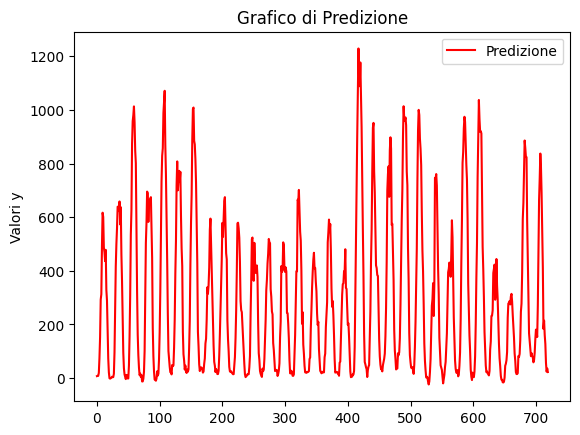

In [33]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [34]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [35]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [37]:
df.to_csv('B.csv')